In [1]:
from tensorflow import keras
import json
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import dataset
from util import (
    get_place_to_index_mapping,
    get_incident_to_index_mapping
)
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Flatten
from keras import Sequential
import keras.backend as kb
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import PIL

In [2]:
abs_path = "/kuacc/users/asafaya19/cv-project"
train_json = os.path.join(abs_path ,"eccv_train.json")
val_json = os.path.join(abs_path ,"eccv_val.json")
data_dir = os.path.join(abs_path, "data")
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

In [3]:
train_paths = json.loads(open(train_json).readline())
val_paths = json.loads(open(val_json).readline())

In [88]:
train_paths

{'track_crash_in_library_outdoor/8e7edea3da.jpg': {'url': 'https://images-na.ssl-images-amazon.com/images/I/91ywrXSiLPL._SY355_.jpg',
  'incidents': {'truck accident': 0},
  'places': {}},
 'van_wreck_in_ski_slope/816a13d3c4.jpg': {'url': 'https://cdn.jwplayer.com/thumbs/YSP0jzjK-720.jpg',
  'incidents': {'wildfire': 0},
  'places': {}},
 'motorcycle_incident_in_mosque_outdoor/114adb9c2c.jpg': {'url': 'http://www.globalwomenwhoride.com/wp-content/uploads/Anita_SaidinaAliMosque.jpg',
  'incidents': {'dirty contamined': 0},
  'places': {}},
 'burned_motel/09d4d7e4b5.jpg': {'url': 'https://media.nbcwashington.com/images/578*325/WRC_0000000018663746_1200x675_936005699772.jpg',
  'incidents': {'burned': 0},
  'places': {}},
 'boat_crash_in_landfill/f064995437.jpg': {'url': 'http://www.pwcgov.org/government/dept/finance/PublishingImages/Fireboat%20502%20Phoenix.jpg',
  'incidents': {'wildfire': 0},
  'places': {}},
 'van_incident_in_dam/1c902ee1cc.jpg': {'url': 'http://images.slideplayer.com

In [4]:
place_to_idx = get_place_to_index_mapping()
incident_to_idx = get_incident_to_index_mapping()

In [5]:
def get_dataset(paths,file_dir, threshold=1000):
    train_set = []
    for path in tqdm(paths, leave=False):
    #     print(path)
        if not os.path.exists(os.path.join(file_dir, path)):
            continue
        # Make sure image is not corrupt, try importing it
        try:
            PIL.Image.open(os.path.join(file_dir, path))
        except:
            continue
        nump = len(place_to_idx)+1
        numi = len(incident_to_idx)+1
        place_labels = np.zeros(nump, np.float32)
        place_weights = np.zeros(nump, np.float32)
        incident_labels = np.zeros(numi, np.float32)
        incident_weights = np.zeros(numi, np.float32)

        incidents = paths[path]["incidents"]
        for k in incidents:
            lbl = incidents[k]
            if lbl==1:
                # We are sure this instance is only this incident
                incident_labels[incident_to_idx[k]]=1
                incident_weights = np.ones(numi, np.float32)
            else:
                # We are only sure that this image is not that incident
                incident_weights[incident_to_idx[k]]=1
        if len(incidents)==0:
            # No incident
            incident_labels[-1]=1
            incident_weights = np.ones(numi, np.float32)

        places = paths[path]["places"]
        for k in places:
            lbl = places[k]
            if lbl==1:
                # We are sure this instance is only this incident
                place_labels[place_to_idx[k]]=1
                place_weights = np.ones(nump, np.float32)
            else:
                # We are only sure that this image is not that incident
                place_weights[place_to_idx[k]]=1
        if len(places)==0:
            # No place
            place_labels[-1]=1
            place_weights = np.ones(nump, np.float32)


        train_set.append({
            "path":path,
            "incident_labels":incident_labels,
            "incident_weights":incident_weights,
            "incidents":np.vstack((incident_labels, incident_weights)),
            "place_labels":place_labels,
            "place_weights":place_weights,
            "place":np.vstack((place_labels, place_weights))
        })
        if len(train_set)>=threshold:
            break
    return train_set

In [7]:
train_set = get_dataset(train_paths, train_dir, 1000)
val_set = get_dataset(val_paths, val_dir, 1000)

In [8]:
train_df = pd.DataFrame(train_set)
val_df = pd.DataFrame(val_set)

In [218]:
?ImageDataGenerator

In [234]:
?keras.layers.experimental.preprocessing.RandomCrop

In [6]:
def getpreprocessfunc():
    mean = np.asarray([0.485, 0.456, 0.406]).reshape(1, 1, 3).astype(np.float32)
    std = np.asarray([0.229, 0.224, 0.225]).reshape(1, 1, 3).astype(np.float32)
    def preprocessfunc(img):
        img /= 255
        img -= mean
        img /= std
        return img
    return preprocessfunc


In [25]:
imgen = ImageDataGenerator(
    horizontal_flip=True,
    preprocessing_function=getpreprocessfunc(),
)

imgen = imgen.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col="path",
    y_col=["incidents", "place"],
    weight_col=None,
    target_size=(256, 256),
    color_mode="rgb",
    classes=None,
    class_mode="multi_output",
    batch_size=64,
    shuffle=False,
    seed=True,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
    validate_filenames=True,
)

Found 1000 validated image filenames.


In [239]:
nxt = next(imgen)

In [119]:
a = np.asarray([1, 0, 0, 0, 0, 0]).astype(np.float32)
b = np.vstack((a*10, a))#np.asarray([[1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0]])

In [121]:
keras.losses.BinaryCrossentropy()(a, a)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.0>

In [120]:
weighted_loss(b.reshape((1, 2, 6)), a.reshape((1, 6)))

<tf.Tensor: shape=(), dtype=float32, numpy=-0.870167>

In [26]:
inp = keras.Input(shape=(256, 256, 3))

In [27]:
cropped = keras.layers.experimental.preprocessing.RandomCrop(224, 224)(inp)

In [28]:
model = ResNet50(include_top=False, pooling = "avg")(cropped)

In [29]:
trunk = Dense(1024, activation="relu", name="trunk")(model)

In [30]:
incident_proj = Dense(len(incident_to_idx)+1, name="incidents_projection")(trunk)

In [31]:
places_proj = Dense(len(place_to_idx)+1, name="places_projection")(trunk)

In [83]:
mdl = keras.Model(inputs=inp, outputs=[incident_proj, places_proj])

In [7]:
def get_final_model():
    inp = keras.Input(shape=(256, 256, 3))
    cropped = keras.layers.experimental.preprocessing.RandomCrop(224, 224)(inp)
    model = ResNet50(include_top=False, pooling = "avg")(cropped)    
    trunk = Dense(1024, activation="relu", name="trunk")(model)
    incident_proj = Dense(len(incident_to_idx)+1, name="incidents_projection")(trunk)
    places_proj = Dense(len(place_to_idx)+1, name="places_projection")(trunk)
    mdl = keras.Model(inputs=inp, outputs=[incident_proj, places_proj])    
    
    return mdl

In [40]:
# Enclosure to retain state
def get_weighted_accuracy():
    m = keras.metrics.CategoricalAccuracy()
    def weighted_accuracy(y_true, y_preds):
        y_true = tf.reshape(y_true, (bs, 2, -1))
        y_true_lbls = y_true[:,0,:]
        return m(y_true_lbls, y_preds)
    return weighted_accuracy

In [82]:
def weighted_loss(y_true, y_preds):
    bce = keras.losses.BinaryCrossentropy(keras.losses.Reduction.NONE)
#     tf.print(y_true)
#     tf.print(y_preds)
#     print(y_true.shape)
#     print(y_preds.shape)
    bs = y_true.shape[0]
    y_true = tf.reshape(y_true, (bs, 2, -1))
    y_true_lbls = y_true[:,0,:]
    y_true_weights = y_true[:,1,:]
    bce_loss = bce(y_true_lbls, y_preds)
#     import pdb
#     pdb.set_trace()
#     return bce_loss
    return tf.reduce_sum(tf.multiply(bce_loss, y_true_weights))

In [84]:
losses = {
    "incidents_projection": weighted_loss,
    "places_projection": weighted_loss,
}

In [85]:
opt = keras.optimizers.Adam(lr=1e-5)

In [86]:
mdl.compile(optimizer=opt, loss=losses, metrics=[get_weighted_accuracy()])

In [87]:
# itr = tqdm(imgen)
for x, y in imgen:
#     print(type(x), type(y))
    y1 = y[0]
    y2 = y[1]
    bs = y1.shape[0]
    print(mdl.train_on_batch(x, [y1.reshape(bs, -1), y2.reshape(bs, -1)], return_dict=True), "\r")
#     break

{'loss': 0.00021692138398066163, 'incidents_projection_loss': 8.288113895105198e-05, 'places_projection_loss': 0.00013404023775365204, 'incidents_projection_weighted_accuracy': 0.390625, 'places_projection_weighted_accuracy': 0.5859375} 
{'loss': 0.00032466117409057915, 'incidents_projection_loss': 0.00013062258949503303, 'places_projection_loss': 0.00019403858459554613, 'incidents_projection_weighted_accuracy': 0.5677083134651184, 'places_projection_weighted_accuracy': 0.59765625} 
{'loss': 0.0002839844673871994, 'incidents_projection_loss': 0.00012375629739835858, 'places_projection_loss': 0.00016022816998884082, 'incidents_projection_weighted_accuracy': 0.5874999761581421, 'places_projection_weighted_accuracy': 0.6041666865348816} 
{'loss': 0.00053631846094504, 'incidents_projection_loss': 0.00021637640020344406, 'places_projection_loss': 0.0003199420461896807, 'incidents_projection_weighted_accuracy': 0.59375, 'places_projection_weighted_accuracy': 0.609375} 
{'loss': 0.00022050595

{'loss': 0.0003690290614031255, 'incidents_projection_loss': 0.00017706170910969377, 'places_projection_loss': 0.00019196733774151653, 'incidents_projection_weighted_accuracy': 0.5811068415641785, 'places_projection_weighted_accuracy': 0.5827067494392395} 
{'loss': 0.0002693237329367548, 'incidents_projection_loss': 0.00014209307846613228, 'places_projection_loss': 0.00012723065447062254, 'incidents_projection_weighted_accuracy': 0.5817129611968994, 'places_projection_weighted_accuracy': 0.5832573175430298} 
{'loss': 0.0003135560837108642, 'incidents_projection_loss': 0.00014412964810617268, 'places_projection_loss': 0.0001694264356046915, 'incidents_projection_weighted_accuracy': 0.5825089812278748, 'places_projection_weighted_accuracy': 0.5846630930900574} 
{'loss': 0.0004486644174903631, 'incidents_projection_loss': 0.00017380535427946597, 'places_projection_loss': 0.0002748590486589819, 'incidents_projection_weighted_accuracy': 0.5839160680770874, 'places_projection_weighted_accura

{'loss': 0.00028254796052351594, 'incidents_projection_loss': 0.00014245131751522422, 'places_projection_loss': 0.0001400966284563765, 'incidents_projection_weighted_accuracy': 0.5814903974533081, 'places_projection_weighted_accuracy': 0.5822995901107788} 
{'loss': 0.00024844700237736106, 'incidents_projection_loss': 0.00013280143321026117, 'places_projection_loss': 0.00011564558371901512, 'incidents_projection_weighted_accuracy': 0.5819128751754761, 'places_projection_weighted_accuracy': 0.5831766724586487} 
{'loss': 0.0003312977496534586, 'incidents_projection_loss': 0.00012022953887935728, 'places_projection_loss': 0.0002110681962221861, 'incidents_projection_weighted_accuracy': 0.5829057693481445, 'places_projection_weighted_accuracy': 0.5832176208496094} 
{'loss': 0.00015138255548663437, 'incidents_projection_loss': 6.562069756910205e-05, 'places_projection_loss': 8.576185791753232e-05, 'incidents_projection_weighted_accuracy': 0.5814567804336548, 'places_projection_weighted_accur

{'loss': 0.00026455119950696826, 'incidents_projection_loss': 0.00012026500189676881, 'places_projection_loss': 0.00014428618305828422, 'incidents_projection_weighted_accuracy': 0.5819408893585205, 'places_projection_weighted_accuracy': 0.5827205777168274} 
{'loss': 0.00017006983398459852, 'incidents_projection_loss': 9.74232898443006e-05, 'places_projection_loss': 7.26465368643403e-05, 'incidents_projection_weighted_accuracy': 0.5825381875038147, 'places_projection_weighted_accuracy': 0.5827531814575195} 
{'loss': 0.00012583518400788307, 'incidents_projection_loss': 4.2884254071395844e-05, 'places_projection_loss': 8.295092993648723e-05, 'incidents_projection_weighted_accuracy': 0.5815491080284119, 'places_projection_weighted_accuracy': 0.5826284289360046} 
{'loss': 8.360080391867086e-05, 'incidents_projection_loss': 3.6073746741749346e-05, 'places_projection_loss': 4.752705717692152e-05, 'incidents_projection_weighted_accuracy': 0.5814370512962341, 'places_projection_weighted_accurac

{'loss': 0.00018477276898920536, 'incidents_projection_loss': 0.00010201759141637012, 'places_projection_loss': 8.275517757283524e-05, 'incidents_projection_weighted_accuracy': 0.5821669697761536, 'places_projection_weighted_accuracy': 0.5823317170143127} 
{'loss': 7.315786206163466e-05, 'incidents_projection_loss': 3.1582501833327115e-05, 'places_projection_loss': 4.157536386628635e-05, 'incidents_projection_weighted_accuracy': 0.5814176201820374, 'places_projection_weighted_accuracy': 0.5822399854660034} 
{'loss': 8.261096809292212e-05, 'incidents_projection_loss': 3.654618194559589e-05, 'places_projection_loss': 4.606478614732623e-05, 'incidents_projection_weighted_accuracy': 0.5812737345695496, 'places_projection_weighted_accuracy': 0.5822679996490479} 
{'loss': 9.197175677400082e-05, 'incidents_projection_loss': 4.585566057357937e-05, 'places_projection_loss': 4.611609620042145e-05, 'incidents_projection_weighted_accuracy': 0.581544816493988, 'places_projection_weighted_accuracy':

{'loss': 7.742756861262023e-05, 'incidents_projection_loss': 3.380837006261572e-05, 'places_projection_loss': 4.3619194912025705e-05, 'incidents_projection_weighted_accuracy': 0.5813369154930115, 'places_projection_weighted_accuracy': 0.5820011496543884} 
{'loss': 8.05916206445545e-05, 'incidents_projection_loss': 4.261842695996165e-05, 'places_projection_loss': 3.7973190046614036e-05, 'incidents_projection_weighted_accuracy': 0.5812212228775024, 'places_projection_weighted_accuracy': 0.5820252895355225} 
{'loss': 6.923992623342201e-05, 'incidents_projection_loss': 3.3734828321030363e-05, 'places_projection_loss': 3.550509791239165e-05, 'incidents_projection_weighted_accuracy': 0.5814408659934998, 'places_projection_weighted_accuracy': 0.5820015072822571} 
{'loss': 6.184049561852589e-05, 'incidents_projection_loss': 2.238875094917603e-05, 'places_projection_loss': 3.9451744669349864e-05, 'incidents_projection_weighted_accuracy': 0.5811836123466492, 'places_projection_weighted_accuracy'

{'loss': 6.207742990227416e-05, 'incidents_projection_loss': 3.040824958588928e-05, 'places_projection_loss': 3.166918031638488e-05, 'incidents_projection_weighted_accuracy': 0.5809842348098755, 'places_projection_weighted_accuracy': 0.5816195607185364} 
{'loss': 8.657723083160818e-05, 'incidents_projection_loss': 4.215192893752828e-05, 'places_projection_loss': 4.4425301894079894e-05, 'incidents_projection_weighted_accuracy': 0.581129789352417, 'places_projection_weighted_accuracy': 0.5816016793251038} 
{'loss': 0.0001350901584373787, 'incidents_projection_loss': 6.67030835757032e-05, 'places_projection_loss': 6.83870748616755e-05, 'incidents_projection_weighted_accuracy': 0.5809151530265808, 'places_projection_weighted_accuracy': 0.5815442204475403} 
{'loss': 8.402124512940645e-05, 'incidents_projection_loss': 4.335256016929634e-05, 'places_projection_loss': 4.066868496011011e-05, 'incidents_projection_weighted_accuracy': 0.5812183022499084, 'places_projection_weighted_accuracy': 0.5

{'loss': 0.0002666681248228997, 'incidents_projection_loss': 0.00016570507432334125, 'places_projection_loss': 0.00010096305049955845, 'incidents_projection_weighted_accuracy': 0.5808356404304504, 'places_projection_weighted_accuracy': 0.581243097782135} 
{'loss': 0.0127369724214077, 'incidents_projection_loss': 0.009756749495863914, 'places_projection_loss': 0.002980222459882498, 'incidents_projection_weighted_accuracy': 0.5806518197059631, 'places_projection_weighted_accuracy': 0.5812293887138367} 
{'loss': 0.0013529250863939524, 'incidents_projection_loss': 0.0010207908926531672, 'places_projection_loss': 0.0003321341937407851, 'incidents_projection_weighted_accuracy': 0.5808461308479309, 'places_projection_weighted_accuracy': 0.5813524723052979} 
{'loss': 0.001366647076793015, 'incidents_projection_loss': 0.0008546727476641536, 'places_projection_loss': 0.0005119743291288614, 'incidents_projection_weighted_accuracy': 0.5806979537010193, 'places_projection_weighted_accuracy': 0.5811

{'loss': 0.00027823899290524423, 'incidents_projection_loss': 5.14593230036553e-05, 'places_projection_loss': 0.00022677968081552535, 'incidents_projection_weighted_accuracy': 0.5802405476570129, 'places_projection_weighted_accuracy': 0.5807191133499146} 
{'loss': 0.000219525711145252, 'incidents_projection_loss': 0.00011255392018938437, 'places_projection_loss': 0.00010697179823182523, 'incidents_projection_weighted_accuracy': 0.5803829431533813, 'places_projection_weighted_accuracy': 0.5807692408561707} 
{'loss': 0.001408041687682271, 'incidents_projection_loss': 0.0008456053328700364, 'places_projection_loss': 0.0005624363548122346, 'incidents_projection_weighted_accuracy': 0.580194354057312, 'places_projection_weighted_accuracy': 0.5806094408035278} 
{'loss': 0.00028688766178674996, 'incidents_projection_loss': 0.00012423848966136575, 'places_projection_loss': 0.0001626491721253842, 'incidents_projection_weighted_accuracy': 0.5801267027854919, 'places_projection_weighted_accuracy':

{'loss': 0.00012473785318434238, 'incidents_projection_loss': 6.20989958406426e-05, 'places_projection_loss': 6.263885734369978e-05, 'incidents_projection_weighted_accuracy': 0.5800259113311768, 'places_projection_weighted_accuracy': 0.5804802179336548} 
{'loss': 0.00013222599227447063, 'incidents_projection_loss': 6.840722198830917e-05, 'places_projection_loss': 6.381877028616145e-05, 'incidents_projection_weighted_accuracy': 0.5801805853843689, 'places_projection_weighted_accuracy': 0.5805257558822632} 
{'loss': 0.00041391453123651445, 'incidents_projection_loss': 9.532712283544242e-05, 'places_projection_loss': 0.000318587408401072, 'incidents_projection_weighted_accuracy': 0.580012857913971, 'places_projection_weighted_accuracy': 0.5803571343421936} 
{'loss': 0.00012171059643151239, 'incidents_projection_loss': 8.232459367718548e-05, 'places_projection_loss': 3.938600275432691e-05, 'incidents_projection_weighted_accuracy': 0.5799263715744019, 'places_projection_weighted_accuracy': 

{'loss': 0.00011617856216616929, 'incidents_projection_loss': 6.399897392839193e-05, 'places_projection_loss': 5.2179584599798545e-05, 'incidents_projection_weighted_accuracy': 0.5800417065620422, 'places_projection_weighted_accuracy': 0.5803779363632202} 
{'loss': 0.0001989466545637697, 'incidents_projection_loss': 6.0050289903301746e-05, 'places_projection_loss': 0.00013889637193642557, 'incidents_projection_weighted_accuracy': 0.5799148678779602, 'places_projection_weighted_accuracy': 0.5802260637283325} 
{'loss': 0.0010162035468965769, 'incidents_projection_loss': 0.0008710491820238531, 'places_projection_loss': 0.00014515437942463905, 'incidents_projection_weighted_accuracy': 0.5798128843307495, 'places_projection_weighted_accuracy': 0.5801714062690735} 
{'loss': 6.911158561706543e-05, 'incidents_projection_loss': 3.89324122807011e-05, 'places_projection_loss': 3.0179171517374925e-05, 'incidents_projection_weighted_accuracy': 0.579855740070343, 'places_projection_weighted_accuracy

{'loss': 0.00017727178055793047, 'incidents_projection_loss': 4.381341568659991e-05, 'places_projection_loss': 0.00013345836487133056, 'incidents_projection_weighted_accuracy': 0.579900324344635, 'places_projection_weighted_accuracy': 0.5802061557769775} 
{'loss': 0.00011511916818562895, 'incidents_projection_loss': 6.471753295045346e-05, 'places_projection_loss': 5.040163523517549e-05, 'incidents_projection_weighted_accuracy': 0.5798293352127075, 'places_projection_weighted_accuracy': 0.5801563858985901} 
{'loss': 5.49979813513346e-05, 'incidents_projection_loss': 2.9887843993492424e-05, 'places_projection_loss': 2.5110135538852774e-05, 'incidents_projection_weighted_accuracy': 0.5798684358596802, 'places_projection_weighted_accuracy': 0.5800192952156067} 
{'loss': 8.457265357719734e-05, 'incidents_projection_loss': 5.6464996305294335e-05, 'places_projection_loss': 2.8107657271903008e-05, 'incidents_projection_weighted_accuracy': 0.5798197984695435, 'places_projection_weighted_accurac

{'loss': 0.0002661348262336105, 'incidents_projection_loss': 7.172889309003949e-05, 'places_projection_loss': 0.00019440593314357102, 'incidents_projection_weighted_accuracy': 0.5798633694648743, 'places_projection_weighted_accuracy': 0.5801638960838318} 
{'loss': 7.278121483977884e-05, 'incidents_projection_loss': 3.763529093703255e-05, 'places_projection_loss': 3.514592026476748e-05, 'incidents_projection_weighted_accuracy': 0.5798991918563843, 'places_projection_weighted_accuracy': 0.5800378322601318} 
{'loss': 0.00020209471404086798, 'incidents_projection_loss': 0.00010000592010328546, 'places_projection_loss': 0.00010208879393758252, 'incidents_projection_weighted_accuracy': 0.5798342823982239, 'places_projection_weighted_accuracy': 0.5799325108528137} 
{'loss': 4.833229468204081e-05, 'incidents_projection_loss': 2.3197831978905015e-05, 'places_projection_loss': 2.5134460884146392e-05, 'incidents_projection_weighted_accuracy': 0.579788088798523, 'places_projection_weighted_accurac

{'loss': 5.817156852572225e-05, 'incidents_projection_loss': 2.9255035769892856e-05, 'places_projection_loss': 2.8916532755829394e-05, 'incidents_projection_weighted_accuracy': 0.5799440145492554, 'places_projection_weighted_accuracy': 0.580072283744812} 
{'loss': 6.84619735693559e-05, 'incidents_projection_loss': 4.060355422552675e-05, 'places_projection_loss': 2.7858422981807962e-05, 'incidents_projection_weighted_accuracy': 0.5799024701118469, 'places_projection_weighted_accuracy': 0.5799933075904846} 
{'loss': 3.345814911881462e-05, 'incidents_projection_loss': 1.5263085515471175e-05, 'places_projection_loss': 1.8195063603343442e-05, 'incidents_projection_weighted_accuracy': 0.5798409581184387, 'places_projection_weighted_accuracy': 0.5800044536590576} 
{'loss': 0.0001609628088772297, 'incidents_projection_loss': 8.050136239035055e-05, 'places_projection_loss': 8.046145376283675e-05, 'incidents_projection_weighted_accuracy': 0.5798168182373047, 'places_projection_weighted_accuracy'

{'loss': 7.173404446803033e-05, 'incidents_projection_loss': 4.450817505130544e-05, 'places_projection_loss': 2.7225865778746083e-05, 'incidents_projection_weighted_accuracy': 0.5799438953399658, 'places_projection_weighted_accuracy': 0.5800283551216125} 
{'loss': 4.0139850170817226e-05, 'incidents_projection_loss': 2.287752431584522e-05, 'places_projection_loss': 1.7262325854972005e-05, 'incidents_projection_weighted_accuracy': 0.5799038410186768, 'places_projection_weighted_accuracy': 0.5800560116767883} 
{'loss': 0.00013386798673309386, 'incidents_projection_loss': 7.808124792063609e-05, 'places_projection_loss': 5.5786731536500156e-05, 'incidents_projection_weighted_accuracy': 0.579863965511322, 'places_projection_weighted_accuracy': 0.5800344944000244} 
{'loss': 8.564665768062696e-05, 'incidents_projection_loss': 5.36597945028916e-05, 'places_projection_loss': 3.198686317773536e-05, 'incidents_projection_weighted_accuracy': 0.5798084735870361, 'places_projection_weighted_accuracy'

{'loss': 3.756925798370503e-05, 'incidents_projection_loss': 2.225398930022493e-05, 'places_projection_loss': 1.53152686834801e-05, 'incidents_projection_weighted_accuracy': 0.5798777341842651, 'places_projection_weighted_accuracy': 0.5800200700759888} 
{'loss': 0.0002463191922288388, 'incidents_projection_loss': 0.00019024012726731598, 'places_projection_loss': 5.607907223748043e-05, 'incidents_projection_weighted_accuracy': 0.5798404812812805, 'places_projection_weighted_accuracy': 0.5799999833106995} 
{'loss': 6.472098175436258e-05, 'incidents_projection_loss': 3.6000372347189113e-05, 'places_projection_loss': 2.872060940717347e-05, 'incidents_projection_weighted_accuracy': 0.5797886252403259, 'places_projection_weighted_accuracy': 0.5799961090087891} 
{'loss': 0.00011054159404011443, 'incidents_projection_loss': 5.702415364794433e-05, 'places_projection_loss': 5.35174403921701e-05, 'incidents_projection_weighted_accuracy': 0.5799137949943542, 'places_projection_weighted_accuracy': 

{'loss': 0.00011031182657461613, 'incidents_projection_loss': 6.697006028844044e-05, 'places_projection_loss': 4.334176264819689e-05, 'incidents_projection_weighted_accuracy': 0.5798804759979248, 'places_projection_weighted_accuracy': 0.5800303220748901} 
{'loss': 9.285817213822156e-05, 'incidents_projection_loss': 4.818388697458431e-05, 'places_projection_loss': 4.467428516363725e-05, 'incidents_projection_weighted_accuracy': 0.5798467993736267, 'places_projection_weighted_accuracy': 0.580041766166687} 
{'loss': 0.00011065533180953935, 'incidents_projection_loss': 5.781630170531571e-05, 'places_projection_loss': 5.283903010422364e-05, 'incidents_projection_weighted_accuracy': 0.5799643397331238, 'places_projection_weighted_accuracy': 0.5800682306289673} 
{'loss': 0.00013052334543317556, 'incidents_projection_loss': 8.09269113233313e-05, 'places_projection_loss': 4.959644138580188e-05, 'incidents_projection_weighted_accuracy': 0.5800060033798218, 'places_projection_weighted_accuracy': 

{'loss': 5.796777622890659e-05, 'incidents_projection_loss': 3.1990144634619355e-05, 'places_projection_loss': 2.597763159428723e-05, 'incidents_projection_weighted_accuracy': 0.5799269080162048, 'places_projection_weighted_accuracy': 0.5801106691360474} 
{'loss': 0.00013623184349853545, 'incidents_projection_loss': 7.44773933547549e-05, 'places_projection_loss': 6.175445014378056e-05, 'incidents_projection_weighted_accuracy': 0.5800375938415527, 'places_projection_weighted_accuracy': 0.5801355242729187} 
{'loss': 0.0001606090518180281, 'incidents_projection_loss': 0.00011371121217962354, 'places_projection_loss': 4.689783600042574e-05, 'incidents_projection_weighted_accuracy': 0.5800909996032715, 'places_projection_weighted_accuracy': 0.5801886916160583} 
{'loss': 0.00012157608580309898, 'incidents_projection_loss': 6.800191476941109e-05, 'places_projection_loss': 5.357417103368789e-05, 'incidents_projection_weighted_accuracy': 0.5801442265510559, 'places_projection_weighted_accuracy'

{'loss': 0.00010385492350906134, 'incidents_projection_loss': 5.3885953093413264e-05, 'places_projection_loss': 4.996897041564807e-05, 'incidents_projection_weighted_accuracy': 0.5800490379333496, 'places_projection_weighted_accuracy': 0.5801416635513306} 
{'loss': 0.00011733369319699705, 'incidents_projection_loss': 7.210091280285269e-05, 'places_projection_loss': 4.523278403212316e-05, 'incidents_projection_weighted_accuracy': 0.5801130533218384, 'places_projection_weighted_accuracy': 0.5802054405212402} 
{'loss': 0.00017557948012836277, 'incidents_projection_loss': 9.581296762917191e-05, 'places_projection_loss': 7.976651249919087e-05, 'incidents_projection_weighted_accuracy': 0.5801633596420288, 'places_projection_weighted_accuracy': 0.5802958011627197} 
{'loss': 0.00011048835585825145, 'incidents_projection_loss': 5.150439392309636e-05, 'places_projection_loss': 5.8983958297176287e-05, 'incidents_projection_weighted_accuracy': 0.5802537202835083, 'places_projection_weighted_accura

{'loss': 0.00011013794573955238, 'incidents_projection_loss': 6.896124978084117e-05, 'places_projection_loss': 4.117669595871121e-05, 'incidents_projection_weighted_accuracy': 0.5801966190338135, 'places_projection_weighted_accuracy': 0.5802842378616333} 
{'loss': 0.00026697409339249134, 'incidents_projection_loss': 0.00013351364759728312, 'places_projection_loss': 0.000133460431243293, 'incidents_projection_weighted_accuracy': 0.580244243144989, 'places_projection_weighted_accuracy': 0.5803571343421936} 
{'loss': 8.812415035208687e-05, 'incidents_projection_loss': 4.801036266144365e-05, 'places_projection_loss': 4.011378769064322e-05, 'incidents_projection_weighted_accuracy': 0.5803298950195312, 'places_projection_weighted_accuracy': 0.5803789496421814} 
{'loss': 8.190725930035114e-05, 'incidents_projection_loss': 3.7872305256314576e-05, 'places_projection_loss': 4.4034957682015374e-05, 'incidents_projection_weighted_accuracy': 0.5801865458488464, 'places_projection_weighted_accuracy'

{'loss': 8.986532338894904e-05, 'incidents_projection_loss': 5.381264054449275e-05, 'places_projection_loss': 3.605268648243509e-05, 'incidents_projection_weighted_accuracy': 0.5803051590919495, 'places_projection_weighted_accuracy': 0.5804367661476135} 
{'loss': 0.00013336760457605124, 'incidents_projection_loss': 6.498485890915617e-05, 'places_projection_loss': 6.838273839093745e-05, 'incidents_projection_weighted_accuracy': 0.580398678779602, 'places_projection_weighted_accuracy': 0.580433189868927} 
{'loss': 6.021359149599448e-05, 'incidents_projection_loss': 2.7715175747289322e-05, 'places_projection_loss': 3.249841392971575e-05, 'incidents_projection_weighted_accuracy': 0.5802621245384216, 'places_projection_weighted_accuracy': 0.5804296135902405} 
{'loss': 7.8216937254183e-05, 'incidents_projection_loss': 3.6517394619295374e-05, 'places_projection_loss': 4.1699538996908814e-05, 'incidents_projection_weighted_accuracy': 0.5802467465400696, 'places_projection_weighted_accuracy': 0

{'loss': 0.00014186007319949567, 'incidents_projection_loss': 7.07402650732547e-05, 'places_projection_loss': 7.111980085028335e-05, 'incidents_projection_weighted_accuracy': 0.5804842114448547, 'places_projection_weighted_accuracy': 0.580517053604126} 
{'loss': 4.896763857686892e-05, 'incidents_projection_loss': 2.073421455861535e-05, 'places_projection_loss': 2.8233424018253572e-05, 'incidents_projection_weighted_accuracy': 0.5803422927856445, 'places_projection_weighted_accuracy': 0.5805020332336426} 
{'loss': 8.75497207744047e-05, 'incidents_projection_loss': 5.129874625708908e-05, 'places_projection_loss': 3.6250974517315626e-05, 'incidents_projection_weighted_accuracy': 0.5803160071372986, 'places_projection_weighted_accuracy': 0.5804985165596008} 
{'loss': 9.741639951243997e-05, 'incidents_projection_loss': 5.475871512317099e-05, 'places_projection_loss': 4.265768075129017e-05, 'incidents_projection_weighted_accuracy': 0.5803588032722473, 'places_projection_weighted_accuracy': 0

{'loss': 4.9636451876722276e-05, 'incidents_projection_loss': 2.7709082132787444e-05, 'places_projection_loss': 2.1927371562924236e-05, 'incidents_projection_weighted_accuracy': 0.580393373966217, 'places_projection_weighted_accuracy': 0.5805460214614868} 
{'loss': 6.4473832026124e-05, 'incidents_projection_loss': 3.5280176234664395e-05, 'places_projection_loss': 2.9193659429438412e-05, 'incidents_projection_weighted_accuracy': 0.5803791880607605, 'places_projection_weighted_accuracy': 0.5805646181106567} 
{'loss': 5.441607936518267e-05, 'incidents_projection_loss': 2.2400447051040828e-05, 'places_projection_loss': 3.201563231414184e-05, 'incidents_projection_weighted_accuracy': 0.5804309844970703, 'places_projection_weighted_accuracy': 0.5805611610412598} 
{'loss': 7.560661470051855e-05, 'incidents_projection_loss': 3.0378807423403487e-05, 'places_projection_loss': 4.5227803639136255e-05, 'incidents_projection_weighted_accuracy': 0.5803837776184082, 'places_projection_weighted_accurac

{'loss': 5.4780393838882446e-05, 'incidents_projection_loss': 2.6962748961523175e-05, 'places_projection_loss': 2.7817646696348675e-05, 'incidents_projection_weighted_accuracy': 0.5804475545883179, 'places_projection_weighted_accuracy': 0.5806251168251038} 
{'loss': 6.477016722783446e-05, 'incidents_projection_loss': 3.008935527759604e-05, 'places_projection_loss': 3.468081558821723e-05, 'incidents_projection_weighted_accuracy': 0.5804970264434814, 'places_projection_weighted_accuracy': 0.5806217193603516} 
{'loss': 6.846380711067468e-05, 'incidents_projection_loss': 2.688459790078923e-05, 'places_projection_loss': 4.157920557190664e-05, 'incidents_projection_weighted_accuracy': 0.5804517865180969, 'places_projection_weighted_accuracy': 0.5806183815002441} 
{'loss': 6.208816193975508e-05, 'incidents_projection_loss': 3.616002868511714e-05, 'places_projection_loss': 2.5928129616659135e-05, 'incidents_projection_weighted_accuracy': 0.5805221796035767, 'places_projection_weighted_accuracy

{'loss': 5.3369618399301544e-05, 'incidents_projection_loss': 2.517112261557486e-05, 'places_projection_loss': 2.8198495783726685e-05, 'incidents_projection_weighted_accuracy': 0.5805072784423828, 'places_projection_weighted_accuracy': 0.580626904964447} 
{'loss': 7.636406371602789e-05, 'incidents_projection_loss': 2.409778426226694e-05, 'places_projection_loss': 5.226627763477154e-05, 'incidents_projection_weighted_accuracy': 0.5804738998413086, 'places_projection_weighted_accuracy': 0.5806337594985962} 
{'loss': 6.192790169734508e-05, 'incidents_projection_loss': 2.7593487175181508e-05, 'places_projection_loss': 3.433441452216357e-05, 'incidents_projection_weighted_accuracy': 0.580521285533905, 'places_projection_weighted_accuracy': 0.5806506872177124} 
{'loss': 0.00010791623935801908, 'incidents_projection_loss': 1.6296011381200515e-05, 'places_projection_loss': 9.162022615782917e-05, 'incidents_projection_weighted_accuracy': 0.5804578065872192, 'places_projection_weighted_accuracy'

{'loss': 5.248688466963358e-05, 'incidents_projection_loss': 2.1503601601580158e-05, 'places_projection_loss': 3.0983283068053424e-05, 'incidents_projection_weighted_accuracy': 0.5805137157440186, 'places_projection_weighted_accuracy': 0.5806770324707031} 
{'loss': 9.831807983573526e-05, 'incidents_projection_loss': 4.229114711051807e-05, 'places_projection_loss': 5.602693272521719e-05, 'incidents_projection_weighted_accuracy': 0.5805689096450806, 'places_projection_weighted_accuracy': 0.580693244934082} 
{'loss': 4.6942739572841674e-05, 'incidents_projection_loss': 2.1654523152392358e-05, 'places_projection_loss': 2.5288216420449317e-05, 'incidents_projection_weighted_accuracy': 0.5805078148841858, 'places_projection_weighted_accuracy': 0.5806417465209961} 
{'loss': 4.193696076981723e-05, 'incidents_projection_loss': 2.1955616830382496e-05, 'places_projection_loss': 1.998134575842414e-05, 'incidents_projection_weighted_accuracy': 0.5804758667945862, 'places_projection_weighted_accurac

{'loss': 6.539009336847812e-05, 'incidents_projection_loss': 2.5886234652716666e-05, 'places_projection_loss': 3.950386235374026e-05, 'incidents_projection_weighted_accuracy': 0.5805879235267639, 'places_projection_weighted_accuracy': 0.5807264447212219} 
{'loss': 9.412572399014607e-05, 'incidents_projection_loss': 4.8328161938115954e-05, 'places_projection_loss': 4.5797562052030116e-05, 'incidents_projection_weighted_accuracy': 0.5806316137313843, 'places_projection_weighted_accuracy': 0.5807512998580933} 
{'loss': 7.534616452176124e-05, 'incidents_projection_loss': 3.261290839873254e-05, 'places_projection_loss': 4.273325248504989e-05, 'incidents_projection_weighted_accuracy': 0.5805820822715759, 'places_projection_weighted_accuracy': 0.5807109475135803} 
{'loss': 5.6977653002832085e-05, 'incidents_projection_loss': 2.3823922674637288e-05, 'places_projection_loss': 3.31537303281948e-05, 'incidents_projection_weighted_accuracy': 0.5805605053901672, 'places_projection_weighted_accuracy

{'loss': 5.409288132796064e-05, 'incidents_projection_loss': 2.5251592887798324e-05, 'places_projection_loss': 2.8841286621172912e-05, 'incidents_projection_weighted_accuracy': 0.5806448459625244, 'places_projection_weighted_accuracy': 0.5807692408561707} 
{'loss': 3.70197267329786e-05, 'incidents_projection_loss': 1.3999226212035865e-05, 'places_projection_loss': 2.3020500520942733e-05, 'incidents_projection_weighted_accuracy': 0.5805970430374146, 'places_projection_weighted_accuracy': 0.5807213187217712} 
{'loss': 3.865590042551048e-05, 'incidents_projection_loss': 2.224462150479667e-05, 'places_projection_loss': 1.6411278920713812e-05, 'incidents_projection_weighted_accuracy': 0.5805763006210327, 'places_projection_weighted_accuracy': 0.5807093381881714} 
{'loss': 3.349684993736446e-05, 'incidents_projection_loss': 1.5360450561274774e-05, 'places_projection_loss': 1.813639755710028e-05, 'incidents_projection_weighted_accuracy': 0.5805824398994446, 'places_projection_weighted_accurac

{'loss': 5.5576681916136295e-05, 'incidents_projection_loss': 2.874604797398206e-05, 'places_projection_loss': 2.683063576114364e-05, 'incidents_projection_weighted_accuracy': 0.5806745886802673, 'places_projection_weighted_accuracy': 0.5807945728302002} 
{'loss': 5.7060773542616516e-05, 'incidents_projection_loss': 3.1494801078224555e-05, 'places_projection_loss': 2.556597246439196e-05, 'incidents_projection_weighted_accuracy': 0.5806283950805664, 'places_projection_weighted_accuracy': 0.5807396173477173} 
{'loss': 4.4198022806085646e-05, 'incidents_projection_loss': 2.195068373112008e-05, 'places_projection_loss': 2.2247339074965566e-05, 'incidents_projection_weighted_accuracy': 0.5805909633636475, 'places_projection_weighted_accuracy': 0.5807194113731384} 
{'loss': 2.9640927095897496e-05, 'incidents_projection_loss': 1.584650090080686e-05, 'places_projection_loss': 1.3794427104585338e-05, 'incidents_projection_weighted_accuracy': 0.5806055068969727, 'places_projection_weighted_accur

{'loss': 7.149904558900744e-05, 'incidents_projection_loss': 3.6332115996629e-05, 'places_projection_loss': 3.5166933230357245e-05, 'incidents_projection_weighted_accuracy': 0.5806995034217834, 'places_projection_weighted_accuracy': 0.5808153748512268} 
{'loss': 3.971317346440628e-05, 'incidents_projection_loss': 1.7243279216927476e-05, 'places_projection_loss': 2.2469894247478805e-05, 'incidents_projection_weighted_accuracy': 0.5806800127029419, 'places_projection_weighted_accuracy': 0.5808041095733643} 
{'loss': 3.981268309871666e-05, 'incidents_projection_loss': 2.2809294023318216e-05, 'places_projection_loss': 1.7003389075398445e-05, 'incidents_projection_weighted_accuracy': 0.5806939601898193, 'places_projection_weighted_accuracy': 0.5807511210441589} 
{'loss': 6.657716585323215e-05, 'incidents_projection_loss': 4.254651867086068e-05, 'places_projection_loss': 2.4030647182371467e-05, 'incidents_projection_weighted_accuracy': 0.5806745290756226, 'places_projection_weighted_accuracy

{'loss': 2.823611066560261e-05, 'incidents_projection_loss': 1.4534506590280216e-05, 'places_projection_loss': 1.3701604984817095e-05, 'incidents_projection_weighted_accuracy': 0.5807551741600037, 'places_projection_weighted_accuracy': 0.5808752179145813} 
{'loss': 3.190648931195028e-05, 'incidents_projection_loss': 1.7291822587139904e-05, 'places_projection_loss': 1.4614666724810377e-05, 'incidents_projection_weighted_accuracy': 0.5807605385780334, 'places_projection_weighted_accuracy': 0.5808157324790955} 
{'loss': 3.752896736841649e-05, 'incidents_projection_loss': 2.270730874442961e-05, 'places_projection_loss': 1.4821658623986878e-05, 'incidents_projection_weighted_accuracy': 0.5807416439056396, 'places_projection_weighted_accuracy': 0.5807806849479675} 
{'loss': 1.824190803745296e-05, 'incidents_projection_loss': 9.332187801192049e-06, 'places_projection_loss': 8.90972023626091e-06, 'incidents_projection_weighted_accuracy': 0.5807222723960876, 'places_projection_weighted_accuracy

{'loss': 4.543777686194517e-05, 'incidents_projection_loss': 1.6149557268363424e-05, 'places_projection_loss': 2.9288219593581744e-05, 'incidents_projection_weighted_accuracy': 0.5807785391807556, 'places_projection_weighted_accuracy': 0.580902636051178} 
{'loss': 3.679198198369704e-05, 'incidents_projection_loss': 2.240937828901224e-05, 'places_projection_loss': 1.4382604604179505e-05, 'incidents_projection_weighted_accuracy': 0.580799400806427, 'places_projection_weighted_accuracy': 0.5808528661727905} 
{'loss': 5.4953132348600775e-05, 'incidents_projection_loss': 3.4473607229301706e-05, 'places_projection_loss': 2.0479523300309666e-05, 'incidents_projection_weighted_accuracy': 0.5807732343673706, 'places_projection_weighted_accuracy': 0.5808110237121582} 
{'loss': 2.9937305953353643e-05, 'incidents_projection_loss': 1.4005372577230446e-05, 'places_projection_loss': 1.5931933376123197e-05, 'incidents_projection_weighted_accuracy': 0.5807543992996216, 'places_projection_weighted_accur

{'loss': 2.801057416945696e-05, 'incidents_projection_loss': 1.4823102901573293e-05, 'places_projection_loss': 1.3187471267883666e-05, 'incidents_projection_weighted_accuracy': 0.5807750821113586, 'places_projection_weighted_accuracy': 0.5808269381523132} 
{'loss': 3.2943942642305046e-05, 'incidents_projection_loss': 2.070022492262069e-05, 'places_projection_loss': 1.2243715900694951e-05, 'incidents_projection_weighted_accuracy': 0.5807573199272156, 'places_projection_weighted_accuracy': 0.5807939767837524} 
{'loss': 2.3270538804354146e-05, 'incidents_projection_loss': 1.0772893801913597e-05, 'places_projection_loss': 1.249764500244055e-05, 'incidents_projection_weighted_accuracy': 0.5807391405105591, 'places_projection_weighted_accuracy': 0.5808056592941284} 
{'loss': 4.893438017461449e-05, 'incidents_projection_loss': 3.285975253675133e-05, 'places_projection_loss': 1.607462763786316e-05, 'incidents_projection_weighted_accuracy': 0.5807361006736755, 'places_projection_weighted_accura

{'loss': 3.932981417165138e-05, 'incidents_projection_loss': 2.3316881197388284e-05, 'places_projection_loss': 1.6012932974263094e-05, 'incidents_projection_weighted_accuracy': 0.5808259844779968, 'places_projection_weighted_accuracy': 0.5808762907981873} 
{'loss': 3.970236866734922e-05, 'incidents_projection_loss': 2.6400464776088484e-05, 'places_projection_loss': 1.3301902981766034e-05, 'incidents_projection_weighted_accuracy': 0.5808013081550598, 'places_projection_weighted_accuracy': 0.5808368921279907} 
{'loss': 2.0741928892675787e-05, 'incidents_projection_loss': 1.1201152119610924e-05, 'places_projection_loss': 9.540776773064863e-06, 'incidents_projection_weighted_accuracy': 0.5807909965515137, 'places_projection_weighted_accuracy': 0.5808554887771606} 
{'loss': 4.5801392843713984e-05, 'incidents_projection_loss': 2.6793448341777548e-05, 'places_projection_loss': 1.9007944501936436e-05, 'incidents_projection_weighted_accuracy': 0.5807806849479675, 'places_projection_weighted_acc

{'loss': 3.548441600287333e-05, 'incidents_projection_loss': 1.9929557311115786e-05, 'places_projection_loss': 1.555485687276814e-05, 'incidents_projection_weighted_accuracy': 0.5807926654815674, 'places_projection_weighted_accuracy': 0.5808272361755371} 
{'loss': 2.630896051414311e-05, 'incidents_projection_loss': 1.57989670697134e-05, 'places_projection_loss': 1.0509994353924412e-05, 'incidents_projection_weighted_accuracy': 0.580768346786499, 'places_projection_weighted_accuracy': 0.5808310508728027} 
{'loss': 6.409890193026513e-05, 'incidents_projection_loss': 3.8151658372953534e-05, 'places_projection_loss': 2.594724173832219e-05, 'incidents_projection_weighted_accuracy': 0.5807511806488037, 'places_projection_weighted_accuracy': 0.5808285474777222} 
{'loss': 4.748731225845404e-05, 'incidents_projection_loss': 2.853603109542746e-05, 'places_projection_loss': 1.895128116302658e-05, 'incidents_projection_weighted_accuracy': 0.5807416439056396, 'places_projection_weighted_accuracy': 

{'loss': 5.916413283557631e-05, 'incidents_projection_loss': 4.036724931211211e-05, 'places_projection_loss': 1.8796883523464203e-05, 'incidents_projection_weighted_accuracy': 0.5807845592498779, 'places_projection_weighted_accuracy': 0.5808181166648865} 
{'loss': 2.9295726562850177e-05, 'incidents_projection_loss': 1.4809264030191116e-05, 'places_projection_loss': 1.4486462532659061e-05, 'incidents_projection_weighted_accuracy': 0.5807678699493408, 'places_projection_weighted_accuracy': 0.5808287858963013} 
{'loss': 9.847179899225011e-05, 'incidents_projection_loss': 6.405304156942293e-05, 'places_projection_loss': 3.4418757422827184e-05, 'incidents_projection_weighted_accuracy': 0.5807511806488037, 'places_projection_weighted_accuracy': 0.5808264017105103} 
{'loss': 3.565163933672011e-05, 'incidents_projection_loss': 1.8333686966798268e-05, 'places_projection_loss': 1.731795236992184e-05, 'incidents_projection_weighted_accuracy': 0.5807349681854248, 'places_projection_weighted_accura

{'loss': 2.0873478206340224e-05, 'incidents_projection_loss': 1.0828961421793792e-05, 'places_projection_loss': 1.0044517694041133e-05, 'incidents_projection_weighted_accuracy': 0.5807605981826782, 'places_projection_weighted_accuracy': 0.5808199048042297} 
{'loss': 4.5355584006756544e-05, 'incidents_projection_loss': 2.641819264681544e-05, 'places_projection_loss': 1.8937391359941103e-05, 'incidents_projection_weighted_accuracy': 0.5807511210441589, 'places_projection_weighted_accuracy': 0.5808243155479431} 
{'loss': 4.113886825507507e-05, 'incidents_projection_loss': 2.245420910185203e-05, 'places_projection_loss': 1.8684657334233634e-05, 'incidents_projection_weighted_accuracy': 0.5807421207427979, 'places_projection_weighted_accuracy': 0.5808287262916565} 
{'loss': 8.518309914506972e-05, 'incidents_projection_loss': 5.702046109945513e-05, 'places_projection_loss': 2.8162638045614585e-05, 'incidents_projection_weighted_accuracy': 0.5807938575744629, 'places_projection_weighted_accur

{'loss': 5.112986400490627e-05, 'incidents_projection_loss': 3.245101106585935e-05, 'places_projection_loss': 1.867885293904692e-05, 'incidents_projection_weighted_accuracy': 0.5807182192802429, 'places_projection_weighted_accuracy': 0.5807828903198242} 
{'loss': 3.2599084079265594e-05, 'incidents_projection_loss': 1.5366853403975256e-05, 'places_projection_loss': 1.7232228856300935e-05, 'incidents_projection_weighted_accuracy': 0.5807094573974609, 'places_projection_weighted_accuracy': 0.5807937979698181} 
{'loss': 4.9934467824641615e-05, 'incidents_projection_loss': 2.6876263291342184e-05, 'places_projection_loss': 2.305820453329943e-05, 'incidents_projection_weighted_accuracy': 0.5807598233222961, 'places_projection_weighted_accuracy': 0.580804705619812} 
{'loss': 7.11341344867833e-05, 'incidents_projection_loss': 4.570671444525942e-05, 'places_projection_loss': 2.542741822253447e-05, 'incidents_projection_weighted_accuracy': 0.5807839035987854, 'places_projection_weighted_accuracy'

{'loss': 5.879170203115791e-05, 'incidents_projection_loss': 3.316746006021276e-05, 'places_projection_loss': 2.562424197094515e-05, 'incidents_projection_weighted_accuracy': 0.5807382464408875, 'places_projection_weighted_accuracy': 0.5808076858520508} 
{'loss': 2.992690133396536e-05, 'incidents_projection_loss': 1.7218038919963874e-05, 'places_projection_loss': 1.2708863323496189e-05, 'incidents_projection_weighted_accuracy': 0.5807361006736755, 'places_projection_weighted_accuracy': 0.5808182954788208} 
{'loss': 5.485284054884687e-05, 'incidents_projection_loss': 3.013712921529077e-05, 'places_projection_loss': 2.4715713152545504e-05, 'incidents_projection_weighted_accuracy': 0.5807915925979614, 'places_projection_weighted_accuracy': 0.5808352828025818} 
{'loss': 8.043635170906782e-05, 'incidents_projection_loss': 4.879463813267648e-05, 'places_projection_loss': 3.1641717214370146e-05, 'incidents_projection_weighted_accuracy': 0.5808085799217224, 'places_projection_weighted_accuracy

{'loss': 4.596589133143425e-05, 'incidents_projection_loss': 2.485353070369456e-05, 'places_projection_loss': 2.1112362446729094e-05, 'incidents_projection_weighted_accuracy': 0.5807573199272156, 'places_projection_weighted_accuracy': 0.5808249711990356} 
{'loss': 3.1076735467649996e-05, 'incidents_projection_loss': 1.895609420898836e-05, 'places_projection_loss': 1.2120639439672232e-05, 'incidents_projection_weighted_accuracy': 0.580748975276947, 'places_projection_weighted_accuracy': 0.5808290839195251} 
{'loss': 5.883748963242397e-05, 'incidents_projection_loss': 2.938287980214227e-05, 'places_projection_loss': 2.9454609830281697e-05, 'incidents_projection_weighted_accuracy': 0.5807967782020569, 'places_projection_weighted_accuracy': 0.5808456540107727} 
{'loss': 8.894568600226194e-05, 'incidents_projection_loss': 4.964861727785319e-05, 'places_projection_loss': 3.9297068724408746e-05, 'incidents_projection_weighted_accuracy': 0.5808258652687073, 'places_projection_weighted_accuracy

{'loss': 7.129230652935803e-05, 'incidents_projection_loss': 2.3816017346689478e-05, 'places_projection_loss': 4.747628918266855e-05, 'incidents_projection_weighted_accuracy': 0.580761194229126, 'places_projection_weighted_accuracy': 0.5808393359184265} 
{'loss': 5.633327236864716e-05, 'incidents_projection_loss': 3.1065992516232654e-05, 'places_projection_loss': 2.5267281671403907e-05, 'incidents_projection_weighted_accuracy': 0.5808078050613403, 'places_projection_weighted_accuracy': 0.5808554887771606} 
{'loss': 7.799996819812804e-05, 'incidents_projection_loss': 4.400859688757919e-05, 'places_projection_loss': 3.399136767257005e-05, 'incidents_projection_weighted_accuracy': 0.5808300971984863, 'places_projection_weighted_accuracy': 0.5808716416358948} 
{'loss': 9.578221215633675e-05, 'incidents_projection_loss': 5.9161699027754366e-05, 'places_projection_loss': 3.662051312858239e-05, 'incidents_projection_weighted_accuracy': 0.5808523297309875, 'places_projection_weighted_accuracy'

{'loss': 8.005879499251023e-05, 'incidents_projection_loss': 5.257510201772675e-05, 'places_projection_loss': 2.7483691155794077e-05, 'incidents_projection_weighted_accuracy': 0.580842137336731, 'places_projection_weighted_accuracy': 0.580882728099823} 
{'loss': 5.2228184358682483e-05, 'incidents_projection_loss': 2.8903508791700006e-05, 'places_projection_loss': 2.3324675566982478e-05, 'incidents_projection_weighted_accuracy': 0.5808638334274292, 'places_projection_weighted_accuracy': 0.5809043645858765} 
{'loss': 4.800617170985788e-05, 'incidents_projection_loss': 2.6484507543500513e-05, 'places_projection_loss': 2.1521664166357368e-05, 'incidents_projection_weighted_accuracy': 0.5808854699134827, 'places_projection_weighted_accuracy': 0.580943763256073} 
{'loss': 0.00011341453500790522, 'incidents_projection_loss': 4.065837856614962e-05, 'places_projection_loss': 7.275615644175559e-05, 'incidents_projection_weighted_accuracy': 0.580924928188324, 'places_projection_weighted_accuracy'

{'loss': 5.522578794625588e-05, 'incidents_projection_loss': 3.251462840125896e-05, 'places_projection_loss': 2.2711159544996917e-05, 'incidents_projection_weighted_accuracy': 0.5808727741241455, 'places_projection_weighted_accuracy': 0.5809124112129211} 
{'loss': 5.2049643272766843e-05, 'incidents_projection_loss': 3.0510080250678584e-05, 'places_projection_loss': 2.153956302208826e-05, 'incidents_projection_weighted_accuracy': 0.5808939337730408, 'places_projection_weighted_accuracy': 0.5809566974639893} 
{'loss': 5.518682155525312e-05, 'incidents_projection_loss': 3.0343524485942908e-05, 'places_projection_loss': 2.4843295250320807e-05, 'incidents_projection_weighted_accuracy': 0.5809440612792969, 'places_projection_weighted_accuracy': 0.5809603929519653} 
{'loss': 3.4452954423613846e-05, 'incidents_projection_loss': 1.4943521819077432e-05, 'places_projection_loss': 1.9509432604536414e-05, 'incidents_projection_weighted_accuracy': 0.5808724761009216, 'places_projection_weighted_accu

{'loss': 4.6016335545573384e-05, 'incidents_projection_loss': 3.0670107662444934e-05, 'places_projection_loss': 1.534622788312845e-05, 'incidents_projection_weighted_accuracy': 0.5808529853820801, 'places_projection_weighted_accuracy': 0.5808916687965393} 
{'loss': 6.896164268255234e-05, 'incidents_projection_loss': 3.722298424690962e-05, 'places_projection_loss': 3.173865843564272e-05, 'incidents_projection_weighted_accuracy': 0.5808736681938171, 'places_projection_weighted_accuracy': 0.5809236764907837} 
{'loss': 0.00012104701454518363, 'incidents_projection_loss': 3.950177051592618e-05, 'places_projection_loss': 8.154524402925745e-05, 'incidents_projection_weighted_accuracy': 0.5809056758880615, 'places_projection_weighted_accuracy': 0.5809216499328613} 
{'loss': 2.4109260266413912e-05, 'incidents_projection_loss': 1.0719561942096334e-05, 'places_projection_loss': 1.3389697414822876e-05, 'incidents_projection_weighted_accuracy': 0.5808414220809937, 'places_projection_weighted_accura

{'loss': 8.028213051147759e-05, 'incidents_projection_loss': 4.783444819622673e-05, 'places_projection_loss': 3.2447685953229666e-05, 'incidents_projection_weighted_accuracy': 0.5808119177818298, 'places_projection_weighted_accuracy': 0.5808497667312622} 
{'loss': 5.695800791727379e-05, 'incidents_projection_loss': 3.4945547668030486e-05, 'places_projection_loss': 2.2012460249243304e-05, 'incidents_projection_weighted_accuracy': 0.5808321237564087, 'places_projection_weighted_accuracy': 0.5808866024017334} 
{'loss': 3.737510633072816e-05, 'incidents_projection_loss': 2.1134854250703938e-05, 'places_projection_loss': 1.624025208002422e-05, 'incidents_projection_weighted_accuracy': 0.5808745622634888, 'places_projection_weighted_accuracy': 0.5808901786804199} 
{'loss': 2.9376094971667044e-05, 'incidents_projection_loss': 1.2622125723282807e-05, 'places_projection_loss': 1.6753969248384237e-05, 'incidents_projection_weighted_accuracy': 0.5808117389678955, 'places_projection_weighted_accur

{'loss': 5.7632925745565444e-05, 'incidents_projection_loss': 3.9819922676542774e-05, 'places_projection_loss': 1.7813004888012074e-05, 'incidents_projection_weighted_accuracy': 0.5808051228523254, 'places_projection_weighted_accuracy': 0.580842137336731} 
{'loss': 9.217824117513373e-05, 'incidents_projection_loss': 4.2550800571916625e-05, 'places_projection_loss': 4.962744060321711e-05, 'incidents_projection_weighted_accuracy': 0.5808249711990356, 'places_projection_weighted_accuracy': 0.5808727741241455} 
{'loss': 4.4172418711241335e-05, 'incidents_projection_loss': 2.178665999963414e-05, 'places_projection_loss': 2.2385756892617792e-05, 'incidents_projection_weighted_accuracy': 0.5808556079864502, 'places_projection_weighted_accuracy': 0.5808708667755127} 
{'loss': 6.567926902789623e-05, 'incidents_projection_loss': 3.441117951297201e-05, 'places_projection_loss': 3.1268085876945406e-05, 'incidents_projection_weighted_accuracy': 0.5807887315750122, 'places_projection_weighted_accura

{'loss': 6.336710066534579e-05, 'incidents_projection_loss': 3.809312329394743e-05, 'places_projection_loss': 2.527397737139836e-05, 'incidents_projection_weighted_accuracy': 0.5807827115058899, 'places_projection_weighted_accuracy': 0.5808189511299133} 
{'loss': 5.488180249813013e-05, 'incidents_projection_loss': 2.670420872163959e-05, 'places_projection_loss': 2.817759377649054e-05, 'incidents_projection_weighted_accuracy': 0.5808021426200867, 'places_projection_weighted_accuracy': 0.5808542966842651} 
{'loss': 4.259756678948179e-05, 'incidents_projection_loss': 2.2675638319924474e-05, 'places_projection_loss': 1.992193028854672e-05, 'incidents_projection_weighted_accuracy': 0.5808374285697937, 'places_projection_weighted_accuracy': 0.5808523893356323} 
{'loss': 2.0361723727546632e-05, 'incidents_projection_loss': 9.362043783767149e-06, 'places_projection_loss': 1.0999679034284782e-05, 'incidents_projection_weighted_accuracy': 0.5807719826698303, 'places_projection_weighted_accuracy'

{'loss': 5.101744318380952e-05, 'incidents_projection_loss': 3.6124136386206374e-05, 'places_projection_loss': 1.4893304978613742e-05, 'incidents_projection_weighted_accuracy': 0.5807612538337708, 'places_projection_weighted_accuracy': 0.5807967185974121} 
{'loss': 4.8916874220594764e-05, 'incidents_projection_loss': 2.4668670448591e-05, 'places_projection_loss': 2.4248205590993166e-05, 'incidents_projection_weighted_accuracy': 0.5807802677154541, 'places_projection_weighted_accuracy': 0.5808365345001221} 
{'loss': 6.687011773465201e-05, 'incidents_projection_loss': 2.884421519411262e-05, 'places_projection_loss': 3.802590072154999e-05, 'incidents_projection_weighted_accuracy': 0.5808200240135193, 'places_projection_weighted_accuracy': 0.5808347463607788} 
{'loss': 3.4713582863332704e-05, 'incidents_projection_loss': 2.242785194539465e-05, 'places_projection_loss': 1.2285730917938054e-05, 'incidents_projection_weighted_accuracy': 0.5807559490203857, 'places_projection_weighted_accuracy

{'loss': 5.999514542054385e-05, 'incidents_projection_loss': 3.723130066646263e-05, 'places_projection_loss': 2.276384475408122e-05, 'incidents_projection_weighted_accuracy': 0.580755889415741, 'places_projection_weighted_accuracy': 0.5807906985282898} 
{'loss': 4.432575587998144e-05, 'incidents_projection_loss': 2.312413380423095e-05, 'places_projection_loss': 2.1201622075750493e-05, 'incidents_projection_weighted_accuracy': 0.5807745456695557, 'places_projection_weighted_accuracy': 0.5808296799659729} 
{'loss': 6.591335113625973e-05, 'incidents_projection_loss': 3.861180448438972e-05, 'places_projection_loss': 2.7301543013891205e-05, 'incidents_projection_weighted_accuracy': 0.5808185935020447, 'places_projection_weighted_accuracy': 0.5808330178260803} 
{'loss': 2.2282314603216946e-05, 'incidents_projection_loss': 1.0510414540476631e-05, 'places_projection_loss': 1.1771899153245613e-05, 'incidents_projection_weighted_accuracy': 0.5807609558105469, 'places_projection_weighted_accuracy

{'loss': 5.2747393056051806e-05, 'incidents_projection_loss': 3.7563208024948835e-05, 'places_projection_loss': 1.5184185940597672e-05, 'incidents_projection_weighted_accuracy': 0.5807607769966125, 'places_projection_weighted_accuracy': 0.5807948708534241} 
{'loss': 4.234854714013636e-05, 'incidents_projection_loss': 2.343099367863033e-05, 'places_projection_loss': 1.8917551642516628e-05, 'incidents_projection_weighted_accuracy': 0.5807790756225586, 'places_projection_weighted_accuracy': 0.580828070640564} 
{'loss': 5.524636071640998e-05, 'incidents_projection_loss': 3.247339554945938e-05, 'places_projection_loss': 2.27729651669506e-05, 'incidents_projection_weighted_accuracy': 0.5808172225952148, 'places_projection_weighted_accuracy': 0.5808313488960266} 
{'loss': 2.723844772845041e-05, 'incidents_projection_loss': 1.3240638509159908e-05, 'places_projection_loss': 1.3997809219290502e-05, 'incidents_projection_weighted_accuracy': 0.5807557106018066, 'places_projection_weighted_accuracy

{'loss': 4.267950134817511e-05, 'incidents_projection_loss': 2.5707335225888528e-05, 'places_projection_loss': 1.6972167941275984e-05, 'incidents_projection_weighted_accuracy': 0.5807361006736755, 'places_projection_weighted_accuracy': 0.5807695388793945} 
{'loss': 3.39796461048536e-05, 'incidents_projection_loss': 1.8974003978655674e-05, 'places_projection_loss': 1.5005642126197927e-05, 'incidents_projection_weighted_accuracy': 0.5807540416717529, 'places_projection_weighted_accuracy': 0.5808069705963135} 
{'loss': 3.98978081648238e-05, 'incidents_projection_loss': 2.3354125005425885e-05, 'places_projection_loss': 1.654368497838732e-05, 'incidents_projection_weighted_accuracy': 0.5807963609695435, 'places_projection_weighted_accuracy': 0.5808101892471313} 
{'loss': 2.5966710381908342e-05, 'incidents_projection_loss': 1.4339075278257951e-05, 'places_projection_loss': 1.1627636013145093e-05, 'incidents_projection_weighted_accuracy': 0.5807361006736755, 'places_projection_weighted_accura

{'loss': 6.664713146165013e-05, 'incidents_projection_loss': 4.465550591703504e-05, 'places_projection_loss': 2.199162554461509e-05, 'incidents_projection_weighted_accuracy': 0.5807315707206726, 'places_projection_weighted_accuracy': 0.5807643532752991} 
{'loss': 6.121140904724598e-05, 'incidents_projection_loss': 3.0972700187703595e-05, 'places_projection_loss': 3.0238712497521192e-05, 'incidents_projection_weighted_accuracy': 0.5807491540908813, 'places_projection_weighted_accuracy': 0.5807963013648987} 
{'loss': 5.464793139253743e-05, 'incidents_projection_loss': 3.2754982385085896e-05, 'places_projection_loss': 2.1892949007451534e-05, 'incidents_projection_weighted_accuracy': 0.580781102180481, 'places_projection_weighted_accuracy': 0.5807946920394897} 
{'loss': 2.8969303457415663e-05, 'incidents_projection_loss': 1.646187956794165e-05, 'places_projection_loss': 1.2507423889474012e-05, 'incidents_projection_weighted_accuracy': 0.5807219743728638, 'places_projection_weighted_accurac

{'loss': 3.8217443943722174e-05, 'incidents_projection_loss': 2.3799810151103884e-05, 'places_projection_loss': 1.4417632883123588e-05, 'incidents_projection_weighted_accuracy': 0.5807130932807922, 'places_projection_weighted_accuracy': 0.580745279788971} 
{'loss': 4.14420101151336e-05, 'incidents_projection_loss': 2.3663920728722587e-05, 'places_projection_loss': 1.777808938641101e-05, 'incidents_projection_weighted_accuracy': 0.5807303190231323, 'places_projection_weighted_accuracy': 0.5807813405990601} 
{'loss': 5.186011185287498e-05, 'incidents_projection_loss': 2.365936597925611e-05, 'places_projection_loss': 2.820074587361887e-05, 'incidents_projection_weighted_accuracy': 0.5807663798332214, 'places_projection_weighted_accuracy': 0.5807797312736511} 
{'loss': 7.57432499085553e-05, 'incidents_projection_loss': 5.627744030789472e-05, 'places_projection_loss': 1.946581141964998e-05, 'incidents_projection_weighted_accuracy': 0.5807130932807922, 'places_projection_weighted_accuracy': 

{'loss': 6.626834510825574e-05, 'incidents_projection_loss': 3.616471076384187e-05, 'places_projection_loss': 3.0103632525424473e-05, 'incidents_projection_weighted_accuracy': 0.5807091593742371, 'places_projection_weighted_accuracy': 0.580740749835968} 
{'loss': 6.90647357259877e-05, 'incidents_projection_loss': 3.29162176058162e-05, 'places_projection_loss': 3.61485181201715e-05, 'incidents_projection_weighted_accuracy': 0.5807260870933533, 'places_projection_weighted_accuracy': 0.5807715058326721} 
{'loss': 4.708912456408143e-05, 'incidents_projection_loss': 2.4695043975953013e-05, 'places_projection_loss': 2.2394078769139014e-05, 'incidents_projection_weighted_accuracy': 0.5807568430900574, 'places_projection_weighted_accuracy': 0.580769956111908} 
{'loss': 3.6812343751080334e-05, 'incidents_projection_loss': 1.997979597945232e-05, 'places_projection_loss': 1.6832547771628015e-05, 'incidents_projection_weighted_accuracy': 0.5806999206542969, 'places_projection_weighted_accuracy': 0

{'loss': 3.8247424527071416e-05, 'incidents_projection_loss': 2.3284901544684544e-05, 'places_projection_loss': 1.4962521163397469e-05, 'incidents_projection_weighted_accuracy': 0.5806871652603149, 'places_projection_weighted_accuracy': 0.5807182192802429} 
{'loss': 3.3275508030783385e-05, 'incidents_projection_loss': 1.995658385567367e-05, 'places_projection_loss': 1.3318923265615012e-05, 'incidents_projection_weighted_accuracy': 0.580703854560852, 'places_projection_weighted_accuracy': 0.580752968788147} 
{'loss': 3.897325223078951e-05, 'incidents_projection_loss': 2.2850075765745714e-05, 'places_projection_loss': 1.61231782840332e-05, 'incidents_projection_weighted_accuracy': 0.5807386040687561, 'places_projection_weighted_accuracy': 0.5807514786720276} 
{'loss': 3.3991775126196444e-05, 'incidents_projection_loss': 2.2051823179936036e-05, 'places_projection_loss': 1.193995285575511e-05, 'incidents_projection_weighted_accuracy': 0.5806826949119568, 'places_projection_weighted_accurac

{'loss': 3.7336030800361186e-05, 'incidents_projection_loss': 2.1403735445346683e-05, 'places_projection_loss': 1.5932295355014503e-05, 'incidents_projection_weighted_accuracy': 0.5806882977485657, 'places_projection_weighted_accuracy': 0.5807187557220459} 
{'loss': 3.64911429642234e-05, 'incidents_projection_loss': 1.7588025002623908e-05, 'places_projection_loss': 1.890311796159949e-05, 'incidents_projection_weighted_accuracy': 0.5807046890258789, 'places_projection_weighted_accuracy': 0.5807529091835022} 
{'loss': 4.443827492650598e-05, 'incidents_projection_loss': 2.7632715500658378e-05, 'places_projection_loss': 1.68055576068582e-05, 'incidents_projection_weighted_accuracy': 0.5807388424873352, 'places_projection_weighted_accuracy': 0.5807514190673828} 
{'loss': 3.0488954507745802e-05, 'incidents_projection_loss': 1.642309143790044e-05, 'places_projection_loss': 1.4065862160350662e-05, 'incidents_projection_weighted_accuracy': 0.5806928277015686, 'places_projection_weighted_accurac

{'loss': 4.09865278925281e-05, 'incidents_projection_loss': 2.602661697892472e-05, 'places_projection_loss': 1.4959910004108679e-05, 'incidents_projection_weighted_accuracy': 0.5807068943977356, 'places_projection_weighted_accuracy': 0.5807368159294128} 
{'loss': 4.055978934047744e-05, 'incidents_projection_loss': 2.2593310859519988e-05, 'places_projection_loss': 1.796647848095745e-05, 'incidents_projection_weighted_accuracy': 0.580722987651825, 'places_projection_weighted_accuracy': 0.5807616114616394} 
{'loss': 3.497143188724294e-05, 'incidents_projection_loss': 1.906175384647213e-05, 'places_projection_loss': 1.5909678040770814e-05, 'incidents_projection_weighted_accuracy': 0.5807477831840515, 'places_projection_weighted_accuracy': 0.58076012134552} 
{'loss': 2.066131310130004e-05, 'incidents_projection_loss': 9.781935659702867e-06, 'places_projection_loss': 1.0879377441597171e-05, 'incidents_projection_weighted_accuracy': 0.5806981921195984, 'places_projection_weighted_accuracy': 0

{'loss': 4.962638922734186e-05, 'incidents_projection_loss': 2.9336544685065746e-05, 'places_projection_loss': 2.028984272328671e-05, 'incidents_projection_weighted_accuracy': 0.5806775093078613, 'places_projection_weighted_accuracy': 0.5807069540023804} 
{'loss': 6.264421972446144e-05, 'incidents_projection_loss': 3.546855441527441e-05, 'places_projection_loss': 2.717566712817643e-05, 'incidents_projection_weighted_accuracy': 0.5806933045387268, 'places_projection_weighted_accuracy': 0.5807356238365173} 
{'loss': 5.70665106351953e-05, 'incidents_projection_loss': 2.6984351279679686e-05, 'places_projection_loss': 3.0082159355515614e-05, 'incidents_projection_weighted_accuracy': 0.5807219743728638, 'places_projection_weighted_accuracy': 0.5807341933250427} 
{'loss': 2.2502090359921567e-05, 'incidents_projection_loss': 8.725655789021403e-06, 'places_projection_loss': 1.3776434570900165e-05, 'incidents_projection_weighted_accuracy': 0.5806689858436584, 'places_projection_weighted_accuracy

{'loss': 4.763515244121663e-05, 'incidents_projection_loss': 2.4863358703441918e-05, 'places_projection_loss': 2.2771793737774715e-05, 'incidents_projection_weighted_accuracy': 0.5806702971458435, 'places_projection_weighted_accuracy': 0.5806992053985596} 
{'loss': 3.6416746297618374e-05, 'incidents_projection_loss': 2.1468658815138042e-05, 'places_projection_loss': 1.4948087482480332e-05, 'incidents_projection_weighted_accuracy': 0.5806857943534851, 'places_projection_weighted_accuracy': 0.5807316303253174} 
{'loss': 4.417345189722255e-05, 'incidents_projection_loss': 2.502961433492601e-05, 'places_projection_loss': 1.914383756229654e-05, 'incidents_projection_weighted_accuracy': 0.5807182192802429, 'places_projection_weighted_accuracy': 0.5807301998138428} 
{'loss': 2.3809654521755874e-05, 'incidents_projection_loss': 1.1269000424363185e-05, 'places_projection_loss': 1.2540655006887391e-05, 'incidents_projection_weighted_accuracy': 0.5806703567504883, 'places_projection_weighted_accu

{'loss': 4.851727862842381e-05, 'incidents_projection_loss': 3.202447260264307e-05, 'places_projection_loss': 1.649280784477014e-05, 'incidents_projection_weighted_accuracy': 0.5806549787521362, 'places_projection_weighted_accuracy': 0.5806834101676941} 
{'loss': 3.33730858983472e-05, 'incidents_projection_loss': 2.14105148188537e-05, 'places_projection_loss': 1.1962572898482904e-05, 'incidents_projection_weighted_accuracy': 0.5806702375411987, 'places_projection_weighted_accuracy': 0.5807152986526489} 
{'loss': 5.1239207095932215e-05, 'incidents_projection_loss': 2.5614292098907754e-05, 'places_projection_loss': 2.5624913178035058e-05, 'incidents_projection_weighted_accuracy': 0.5807021260261536, 'places_projection_weighted_accuracy': 0.5807139277458191} 
{'loss': 2.3112861526897177e-05, 'incidents_projection_loss': 1.0170610039494932e-05, 'places_projection_loss': 1.2942250577907544e-05, 'incidents_projection_weighted_accuracy': 0.5806550979614258, 'places_projection_weighted_accurac

{'loss': 3.887229468091391e-05, 'incidents_projection_loss': 2.5063029170269147e-05, 'places_projection_loss': 1.3809266420139465e-05, 'incidents_projection_weighted_accuracy': 0.5806605815887451, 'places_projection_weighted_accuracy': 0.5806885957717896} 
{'loss': 3.539634053595364e-05, 'incidents_projection_loss': 2.101009522448294e-05, 'places_projection_loss': 1.4386245311470702e-05, 'incidents_projection_weighted_accuracy': 0.5806756615638733, 'places_projection_weighted_accuracy': 0.5807199478149414} 
{'loss': 4.057520709466189e-05, 'incidents_projection_loss': 2.006904105655849e-05, 'places_projection_loss': 2.05061660381034e-05, 'incidents_projection_weighted_accuracy': 0.5807070136070251, 'places_projection_weighted_accuracy': 0.5807186365127563} 
{'loss': 2.289349322381895e-05, 'incidents_projection_loss': 1.1010406524292193e-05, 'places_projection_loss': 1.1883086699526757e-05, 'incidents_projection_weighted_accuracy': 0.5806566476821899, 'places_projection_weighted_accuracy

{'loss': 2.8911781555507332e-05, 'incidents_projection_loss': 1.6489619156345725e-05, 'places_projection_loss': 1.2422162399161607e-05, 'incidents_projection_weighted_accuracy': 0.58064866065979, 'places_projection_weighted_accuracy': 0.5806922912597656} 
{'loss': 2.8332899091765285e-05, 'incidents_projection_loss': 1.7274762285524048e-05, 'places_projection_loss': 1.1058136806241237e-05, 'incidents_projection_weighted_accuracy': 0.5806795358657837, 'places_projection_weighted_accuracy': 0.5806949734687805} 
{'loss': 1.9631796021712944e-05, 'incidents_projection_loss': 9.149377547146287e-06, 'places_projection_loss': 1.0482418474566657e-05, 'incidents_projection_weighted_accuracy': 0.5806339979171753, 'places_projection_weighted_accuracy': 0.5806896090507507} 
{'loss': 1.8742401152849197e-05, 'incidents_projection_loss': 1.0544443284743465e-05, 'places_projection_loss': 8.19795695861103e-06, 'incidents_projection_weighted_accuracy': 0.5806246995925903, 'places_projection_weighted_accur

{'loss': 2.5913508579833433e-05, 'incidents_projection_loss': 1.621352021174971e-05, 'places_projection_loss': 9.699987458589021e-06, 'incidents_projection_weighted_accuracy': 0.5806423425674438, 'places_projection_weighted_accuracy': 0.5806852579116821} 
{'loss': 3.913811087841168e-05, 'incidents_projection_loss': 2.2011341570760123e-05, 'places_projection_loss': 1.7126767488662153e-05, 'incidents_projection_weighted_accuracy': 0.5806767344474792, 'places_projection_weighted_accuracy': 0.580687940120697} 
{'loss': 2.3860035071265884e-05, 'incidents_projection_loss': 1.1929914762731642e-05, 'places_projection_loss': 1.1930120308534242e-05, 'incidents_projection_weighted_accuracy': 0.5806319117546082, 'places_projection_weighted_accuracy': 0.580686628818512} 
{'loss': 1.5574376448057592e-05, 'incidents_projection_loss': 7.914584784884937e-06, 'places_projection_loss': 7.659791663172655e-06, 'incidents_projection_weighted_accuracy': 0.5806227326393127, 'places_projection_weighted_accurac

{'loss': 2.5310469936812297e-05, 'incidents_projection_loss': 1.3306098480825312e-05, 'places_projection_loss': 1.2004370546492282e-05, 'incidents_projection_weighted_accuracy': 0.5806518197059631, 'places_projection_weighted_accuracy': 0.5806940793991089} 
{'loss': 4.4634663936449215e-05, 'incidents_projection_loss': 2.8518976250779815e-05, 'places_projection_loss': 1.61156876856694e-05, 'incidents_projection_weighted_accuracy': 0.5806817412376404, 'places_projection_weighted_accuracy': 0.5806928277015686} 
{'loss': 1.9719254851224832e-05, 'incidents_projection_loss': 9.836559001996648e-06, 'places_projection_loss': 9.882695849228185e-06, 'incidents_projection_weighted_accuracy': 0.5806336998939514, 'places_projection_weighted_accuracy': 0.5806876420974731} 
{'loss': 2.6391579012852162e-05, 'incidents_projection_loss': 1.3888827197661158e-05, 'places_projection_loss': 1.2502750905696303e-05, 'incidents_projection_weighted_accuracy': 0.5806246995925903, 'places_projection_weighted_accu

{'loss': 3.2921314414124936e-05, 'incidents_projection_loss': 1.6599802620476112e-05, 'places_projection_loss': 1.6321513612638228e-05, 'incidents_projection_weighted_accuracy': 0.5806559324264526, 'places_projection_weighted_accuracy': 0.5806668400764465} 
{'loss': 1.4978726539993659e-05, 'incidents_projection_loss': 7.178090982051799e-06, 'places_projection_loss': 7.80063601268921e-06, 'incidents_projection_weighted_accuracy': 0.5806086659431458, 'places_projection_weighted_accuracy': 0.5806617140769958} 
{'loss': 1.4472505426965654e-05, 'incidents_projection_loss': 7.47340982343303e-06, 'places_projection_loss': 6.999095148785273e-06, 'incidents_projection_weighted_accuracy': 0.5806035995483398, 'places_projection_weighted_accuracy': 0.5806681513786316} 
{'loss': 1.9242728740209714e-05, 'incidents_projection_loss': 1.127054201788269e-05, 'places_projection_loss': 7.972185812832322e-06, 'incidents_projection_weighted_accuracy': 0.5806215405464172, 'places_projection_weighted_accuracy

{'loss': 2.6189507480012253e-05, 'incidents_projection_loss': 1.3867758752894588e-05, 'places_projection_loss': 1.2321748727117665e-05, 'incidents_projection_weighted_accuracy': 0.5806422233581543, 'places_projection_weighted_accuracy': 0.5806529521942139} 
{'loss': 1.5337120203184895e-05, 'incidents_projection_loss': 7.1203726292878855e-06, 'places_projection_loss': 8.216747119149659e-06, 'incidents_projection_weighted_accuracy': 0.5806032419204712, 'places_projection_weighted_accuracy': 0.5806555151939392} 
{'loss': 2.4570379537180997e-05, 'incidents_projection_loss': 1.2575235814438201e-05, 'places_projection_loss': 1.1995143722742796e-05, 'incidents_projection_weighted_accuracy': 0.5805944800376892, 'places_projection_weighted_accuracy': 0.5806543231010437} 
{'loss': 1.660105408518575e-05, 'incidents_projection_loss': 9.387733371113427e-06, 'places_projection_loss': 7.213321168819675e-06, 'incidents_projection_weighted_accuracy': 0.5806083679199219, 'places_projection_weighted_accu

{'loss': 2.1765405108453706e-05, 'incidents_projection_loss': 9.139263966062572e-06, 'places_projection_loss': 1.2626141142391134e-05, 'incidents_projection_weighted_accuracy': 0.580601692199707, 'places_projection_weighted_accuracy': 0.580653190612793} 
{'loss': 1.8033792002825066e-05, 'incidents_projection_loss': 9.6164103524643e-06, 'places_projection_loss': 8.417381650360767e-06, 'incidents_projection_weighted_accuracy': 0.5805931091308594, 'places_projection_weighted_accuracy': 0.5806556940078735} 
{'loss': 2.6171835997956805e-05, 'incidents_projection_loss': 1.1241472748224624e-05, 'places_projection_loss': 1.4930363249732181e-05, 'incidents_projection_weighted_accuracy': 0.5806105136871338, 'places_projection_weighted_accuracy': 0.580654501914978} 
{'loss': 2.763242991932202e-05, 'incidents_projection_loss': 7.852238923078403e-06, 'places_projection_loss': 1.978019099624362e-05, 'incidents_projection_weighted_accuracy': 0.5805907249450684, 'places_projection_weighted_accuracy': 

{'loss': 2.10792259167647e-05, 'incidents_projection_loss': 8.587664524384309e-06, 'places_projection_loss': 1.249156139238039e-05, 'incidents_projection_weighted_accuracy': 0.5805807113647461, 'places_projection_weighted_accuracy': 0.5806424617767334} 
{'loss': 1.6486885215272196e-05, 'incidents_projection_loss': 9.309192137152422e-06, 'places_projection_loss': 7.177693078119773e-06, 'incidents_projection_weighted_accuracy': 0.5805978775024414, 'places_projection_weighted_accuracy': 0.5806412696838379} 
{'loss': 1.7926451619132422e-05, 'incidents_projection_loss': 8.119021003949456e-06, 'places_projection_loss': 9.807430615182966e-06, 'incidents_projection_weighted_accuracy': 0.5805857181549072, 'places_projection_weighted_accuracy': 0.5806474089622498} 
{'loss': 4.159837408224121e-05, 'incidents_projection_loss': 2.5864903363981284e-05, 'places_projection_loss': 1.5733472537249327e-05, 'incidents_projection_weighted_accuracy': 0.5806102156639099, 'places_projection_weighted_accuracy'

{'loss': 2.4570876121288165e-05, 'incidents_projection_loss': 1.1936153896385804e-05, 'places_projection_loss': 1.263472131540766e-05, 'incidents_projection_weighted_accuracy': 0.5806000828742981, 'places_projection_weighted_accuracy': 0.580642819404602} 
{'loss': 2.2604666810366325e-05, 'incidents_projection_loss': 9.440986104891635e-06, 'places_projection_loss': 1.316368070547469e-05, 'incidents_projection_weighted_accuracy': 0.5805845260620117, 'places_projection_weighted_accuracy': 0.5806416869163513} 
{'loss': 1.9911536583094858e-05, 'incidents_projection_loss': 1.0297881090082228e-05, 'places_projection_loss': 9.61365549301263e-06, 'incidents_projection_weighted_accuracy': 0.580608606338501, 'places_projection_weighted_accuracy': 0.5806549191474915} 
{'loss': 2.5100604034378193e-05, 'incidents_projection_loss': 6.536318323924206e-06, 'places_projection_loss': 1.8564285710453987e-05, 'incidents_projection_weighted_accuracy': 0.5805858373641968, 'places_projection_weighted_accuracy

{'loss': 1.8223776351078413e-05, 'incidents_projection_loss': 8.041795808821917e-06, 'places_projection_loss': 1.0181980542256497e-05, 'incidents_projection_weighted_accuracy': 0.5805655121803284, 'places_projection_weighted_accuracy': 0.5806254148483276} 
{'loss': 2.8800270229112357e-05, 'incidents_projection_loss': 1.528103166492656e-05, 'places_projection_loss': 1.3519238564185798e-05, 'incidents_projection_weighted_accuracy': 0.5805892944335938, 'places_projection_weighted_accuracy': 0.5806385278701782} 
{'loss': 2.909980685217306e-05, 'incidents_projection_loss': 1.0283922165399417e-05, 'places_projection_loss': 1.8815884686773643e-05, 'incidents_projection_weighted_accuracy': 0.5805703997612, 'places_projection_weighted_accuracy': 0.5806195735931396} 
{'loss': 1.1422906027291901e-05, 'incidents_projection_loss': 6.5215217546210624e-06, 'places_projection_loss': 4.901384272670839e-06, 'incidents_projection_weighted_accuracy': 0.580562174320221, 'places_projection_weighted_accuracy

{'loss': 2.388450775470119e-05, 'incidents_projection_loss': 1.1699374226736836e-05, 'places_projection_loss': 1.2185133527964354e-05, 'incidents_projection_weighted_accuracy': 0.58058100938797, 'places_projection_weighted_accuracy': 0.5806330442428589} 
{'loss': 1.3905699233873747e-05, 'incidents_projection_loss': 5.389068519434659e-06, 'places_projection_loss': 8.516630259691738e-06, 'incidents_projection_weighted_accuracy': 0.5805694460868835, 'places_projection_weighted_accuracy': 0.5806179046630859} 
{'loss': 1.4434313925448805e-05, 'incidents_projection_loss': 6.8626904976554215e-06, 'places_projection_loss': 7.571623427793384e-06, 'incidents_projection_weighted_accuracy': 0.5805578231811523, 'places_projection_weighted_accuracy': 0.5806097984313965} 
{'loss': 2.3020798835204914e-05, 'incidents_projection_loss': 7.5472953540156595e-06, 'places_projection_loss': 1.5473502571694553e-05, 'incidents_projection_weighted_accuracy': 0.5805602073669434, 'places_projection_weighted_accura

{'loss': 2.2155209080665372e-05, 'incidents_projection_loss': 1.1420659575378522e-05, 'places_projection_loss': 1.073454950528685e-05, 'incidents_projection_weighted_accuracy': 0.580586850643158, 'places_projection_weighted_accuracy': 0.5806346535682678} 
{'loss': 1.1298572644591331e-05, 'incidents_projection_loss': 4.3693476072803605e-06, 'places_projection_loss': 6.92922458256362e-06, 'incidents_projection_weighted_accuracy': 0.5805684328079224, 'places_projection_weighted_accuracy': 0.580616295337677} 
{'loss': 1.1942158380406909e-05, 'incidents_projection_loss': 6.157059942779597e-06, 'places_projection_loss': 5.785098437627312e-06, 'incidents_projection_weighted_accuracy': 0.5805604457855225, 'places_projection_weighted_accuracy': 0.5806117653846741} 
{'loss': 1.725521360640414e-05, 'incidents_projection_loss': 9.804654837353155e-06, 'places_projection_loss': 7.4505587690509856e-06, 'incidents_projection_weighted_accuracy': 0.5805628299713135, 'places_projection_weighted_accuracy'

{'loss': 1.231049100169912e-05, 'incidents_projection_loss': 4.705400442617247e-06, 'places_projection_loss': 7.605091013829224e-06, 'incidents_projection_weighted_accuracy': 0.5805538892745972, 'places_projection_weighted_accuracy': 0.5806010961532593} 
{'loss': 1.1853808246087283e-05, 'incidents_projection_loss': 6.079168088035658e-06, 'places_projection_loss': 5.774640158051625e-06, 'incidents_projection_weighted_accuracy': 0.5805460214614868, 'places_projection_weighted_accuracy': 0.5805965662002563} 
{'loss': 1.3899281839258038e-05, 'incidents_projection_loss': 7.132638074835995e-06, 'places_projection_loss': 6.766643764422042e-06, 'incidents_projection_weighted_accuracy': 0.5805483460426331, 'places_projection_weighted_accuracy': 0.5805716514587402} 
{'loss': 1.2714999684249051e-05, 'incidents_projection_loss': 6.7934383878309745e-06, 'places_projection_loss': 5.921561751165427e-06, 'incidents_projection_weighted_accuracy': 0.5805370807647705, 'places_projection_weighted_accuracy

{'loss': 1.1318720680719707e-05, 'incidents_projection_loss': 5.057467660662951e-06, 'places_projection_loss': 6.261253020056756e-06, 'incidents_projection_weighted_accuracy': 0.5805565118789673, 'places_projection_weighted_accuracy': 0.5806030631065369} 
{'loss': 1.2664610039792024e-05, 'incidents_projection_loss': 6.72266924084397e-06, 'places_projection_loss': 5.941941253695404e-06, 'incidents_projection_weighted_accuracy': 0.5805487632751465, 'places_projection_weighted_accuracy': 0.5805986523628235} 
{'loss': 1.0750607543741353e-05, 'incidents_projection_loss': 5.520156264537945e-06, 'places_projection_loss': 5.230450824456057e-06, 'incidents_projection_weighted_accuracy': 0.5805510878562927, 'places_projection_weighted_accuracy': 0.580574095249176} 
{'loss': 1.3679493349627592e-05, 'incidents_projection_loss': 7.3264582169940695e-06, 'places_projection_loss': 6.353034677886171e-06, 'incidents_projection_weighted_accuracy': 0.5805399417877197, 'places_projection_weighted_accuracy'

{'loss': 1.2439153579180129e-05, 'incidents_projection_loss': 4.006162271252833e-06, 'places_projection_loss': 8.432991307927296e-06, 'incidents_projection_weighted_accuracy': 0.5805425047874451, 'places_projection_weighted_accuracy': 0.5805884599685669} 
{'loss': 1.0535661203903146e-05, 'incidents_projection_loss': 5.507165042217821e-06, 'places_projection_loss': 5.028495706937974e-06, 'incidents_projection_weighted_accuracy': 0.580534815788269, 'places_projection_weighted_accuracy': 0.5805840492248535} 
{'loss': 1.7784856026992202e-05, 'incidents_projection_loss': 9.440018402528949e-06, 'places_projection_loss': 8.344836714968551e-06, 'incidents_projection_weighted_accuracy': 0.5805371403694153, 'places_projection_weighted_accuracy': 0.5805598497390747} 
{'loss': 2.5315479433629662e-05, 'incidents_projection_loss': 1.8416591046843678e-05, 'places_projection_loss': 6.898887477291282e-06, 'incidents_projection_weighted_accuracy': 0.5805261731147766, 'places_projection_weighted_accuracy

{'loss': 1.0829706297954544e-05, 'incidents_projection_loss': 5.833266186527908e-06, 'places_projection_loss': 4.996440111426637e-06, 'incidents_projection_weighted_accuracy': 0.5805180072784424, 'places_projection_weighted_accuracy': 0.5805665850639343} 
{'loss': 1.9742776203202084e-05, 'incidents_projection_loss': 1.3458365174301434e-05, 'places_projection_loss': 6.284411028900649e-06, 'incidents_projection_weighted_accuracy': 0.5805202722549438, 'places_projection_weighted_accuracy': 0.5805426836013794} 
{'loss': 3.0846782465232536e-05, 'incidents_projection_loss': 1.3308851521287579e-05, 'places_projection_loss': 1.753793185343966e-05, 'incidents_projection_weighted_accuracy': 0.5805094838142395, 'places_projection_weighted_accuracy': 0.5805253386497498} 
{'loss': 9.932349712471478e-06, 'incidents_projection_loss': 3.6880294373986544e-06, 'places_projection_loss': 6.244320047699148e-06, 'incidents_projection_weighted_accuracy': 0.5805017352104187, 'places_projection_weighted_accura

{'loss': 1.6508880435139872e-05, 'incidents_projection_loss': 6.639022103627212e-06, 'places_projection_loss': 9.86985833151266e-06, 'incidents_projection_weighted_accuracy': 0.5805113315582275, 'places_projection_weighted_accuracy': 0.5805593132972717} 
{'loss': 1.0112118616234511e-05, 'incidents_projection_loss': 5.813010375277372e-06, 'places_projection_loss': 4.299107786209788e-06, 'incidents_projection_weighted_accuracy': 0.5805135369300842, 'places_projection_weighted_accuracy': 0.5805356502532959} 
{'loss': 1.2383321518427692e-05, 'incidents_projection_loss': 7.007595741015393e-06, 'places_projection_loss': 5.375725777412299e-06, 'incidents_projection_weighted_accuracy': 0.5805028676986694, 'places_projection_weighted_accuracy': 0.5805185437202454} 
{'loss': 7.6054966484662145e-06, 'incidents_projection_loss': 3.7581207834591623e-06, 'places_projection_loss': 3.847375410259701e-06, 'incidents_projection_weighted_accuracy': 0.5804920196533203, 'places_projection_weighted_accuracy

{'loss': 1.5220408386085182e-05, 'incidents_projection_loss': 9.49192872212734e-06, 'places_projection_loss': 5.728480118705193e-06, 'incidents_projection_weighted_accuracy': 0.5805134177207947, 'places_projection_weighted_accuracy': 0.5805352330207825} 
{'loss': 1.540199082228355e-05, 'incidents_projection_loss': 9.083143595489673e-06, 'places_projection_loss': 6.318846317299176e-06, 'incidents_projection_weighted_accuracy': 0.5805060267448425, 'places_projection_weighted_accuracy': 0.5805214643478394} 
{'loss': 8.004606570466422e-06, 'incidents_projection_loss': 4.246468961355276e-06, 'places_projection_loss': 3.7581371543637943e-06, 'incidents_projection_weighted_accuracy': 0.580495297908783, 'places_projection_weighted_accuracy': 0.5805232524871826} 
{'loss': 2.106790998368524e-05, 'incidents_projection_loss': 1.308202354266541e-05, 'places_projection_loss': 7.985887350514531e-06, 'incidents_projection_weighted_accuracy': 0.5804909467697144, 'places_projection_weighted_accuracy': 0

{'loss': 1.3891707567381673e-05, 'incidents_projection_loss': 8.821110895951279e-06, 'places_projection_loss': 5.070597126177745e-06, 'incidents_projection_weighted_accuracy': 0.5804839134216309, 'places_projection_weighted_accuracy': 0.5804991722106934} 
{'loss': 8.198794603231363e-06, 'incidents_projection_loss': 4.119950517633697e-06, 'places_projection_loss': 4.078843630850315e-06, 'incidents_projection_weighted_accuracy': 0.5804733037948608, 'places_projection_weighted_accuracy': 0.5805009603500366} 
{'loss': 1.688246993580833e-05, 'incidents_projection_loss': 9.165029041469097e-06, 'places_projection_loss': 7.717441803833935e-06, 'incidents_projection_weighted_accuracy': 0.580469012260437, 'places_projection_weighted_accuracy': 0.5805031657218933} 
{'loss': 1.418603915226413e-05, 'incidents_projection_loss': 7.950840881676413e-06, 'places_projection_loss': 6.235198270587716e-06, 'incidents_projection_weighted_accuracy': 0.5804649591445923, 'places_projection_weighted_accuracy': 0

{'loss': 9.04997705220012e-06, 'incidents_projection_loss': 6.204422788869124e-06, 'places_projection_loss': 2.845554263330996e-06, 'incidents_projection_weighted_accuracy': 0.5804643630981445, 'places_projection_weighted_accuracy': 0.5804916024208069} 
{'loss': 1.6002453776309267e-05, 'incidents_projection_loss': 8.923272616812028e-06, 'places_projection_loss': 7.079180250002537e-06, 'incidents_projection_weighted_accuracy': 0.5804600715637207, 'places_projection_weighted_accuracy': 0.5804907083511353} 
{'loss': 2.498357935110107e-05, 'incidents_projection_loss': 1.2643143236346077e-05, 'places_projection_loss': 1.2340435205260292e-05, 'incidents_projection_weighted_accuracy': 0.5804529786109924, 'places_projection_weighted_accuracy': 0.5804928541183472} 
{'loss': 2.4958028006949462e-05, 'incidents_projection_loss': 1.5100421478564385e-05, 'places_projection_loss': 9.857606528385077e-06, 'incidents_projection_weighted_accuracy': 0.5804799795150757, 'places_projection_weighted_accuracy

{'loss': 1.6895402950467542e-05, 'incidents_projection_loss': 1.0041114364867099e-05, 'places_projection_loss': 6.854289040347794e-06, 'incidents_projection_weighted_accuracy': 0.5804636478424072, 'places_projection_weighted_accuracy': 0.5804969072341919} 
{'loss': 1.320232422585832e-05, 'incidents_projection_loss': 7.025944796623662e-06, 'places_projection_loss': 6.1763794292346574e-06, 'incidents_projection_weighted_accuracy': 0.5804596543312073, 'places_projection_weighted_accuracy': 0.5804990530014038} 
{'loss': 2.8985728931729682e-05, 'incidents_projection_loss': 1.6101179426186718e-05, 'places_projection_loss': 1.2884549505542964e-05, 'incidents_projection_weighted_accuracy': 0.5804832577705383, 'places_projection_weighted_accuracy': 0.5805042386054993} 
{'loss': 4.9933805712498724e-05, 'incidents_projection_loss': 3.640146314864978e-05, 'places_projection_loss': 1.3532343473343644e-05, 'incidents_projection_weighted_accuracy': 0.5804915428161621, 'places_projection_weighted_accu

{'loss': 1.728262213873677e-05, 'incidents_projection_loss': 1.0069492418551818e-05, 'places_projection_loss': 7.213129720184952e-06, 'incidents_projection_weighted_accuracy': 0.5804550051689148, 'places_projection_weighted_accuracy': 0.5804879069328308} 
{'loss': 1.379771583742695e-05, 'incidents_projection_loss': 7.78222965891473e-06, 'places_projection_loss': 6.015486178512219e-06, 'incidents_projection_weighted_accuracy': 0.5804510712623596, 'places_projection_weighted_accuracy': 0.580489993095398} 
{'loss': 2.1487097910721786e-05, 'incidents_projection_loss': 1.2229271305841394e-05, 'places_projection_loss': 9.257826604880393e-06, 'incidents_projection_weighted_accuracy': 0.5804743766784668, 'places_projection_weighted_accuracy': 0.5804951190948486} 
{'loss': 2.9183211154304445e-05, 'incidents_projection_loss': 1.8265633116243407e-05, 'places_projection_loss': 1.0917578038061038e-05, 'incidents_projection_weighted_accuracy': 0.5804855823516846, 'places_projection_weighted_accuracy

{'loss': 1.471118230256252e-05, 'incidents_projection_loss': 9.141767804976553e-06, 'places_projection_loss': 5.569414952333318e-06, 'incidents_projection_weighted_accuracy': 0.5804396867752075, 'places_projection_weighted_accuracy': 0.5804781317710876} 
{'loss': 2.028279413934797e-05, 'incidents_projection_loss': 1.1835950317617971e-05, 'places_projection_loss': 8.4468447312247e-06, 'incidents_projection_weighted_accuracy': 0.5804657340049744, 'places_projection_weighted_accuracy': 0.5804862380027771} 
{'loss': 3.246818232582882e-05, 'incidents_projection_loss': 1.8309727238374762e-05, 'places_projection_loss': 1.4158455087454058e-05, 'incidents_projection_weighted_accuracy': 0.5804767608642578, 'places_projection_weighted_accuracy': 0.5804972648620605} 
{'loss': 2.7563979529077187e-05, 'incidents_projection_loss': 1.5714333130745217e-05, 'places_projection_loss': 1.184964639833197e-05, 'incidents_projection_weighted_accuracy': 0.580487847328186, 'places_projection_weighted_accuracy':

{'loss': 1.3068376574665308e-05, 'incidents_projection_loss': 6.34725256531965e-06, 'places_projection_loss': 6.721124009345658e-06, 'incidents_projection_weighted_accuracy': 0.5804404020309448, 'places_projection_weighted_accuracy': 0.5804783701896667} 
{'loss': 2.515302003303077e-05, 'incidents_projection_loss': 1.425499067408964e-05, 'places_projection_loss': 1.089802935894113e-05, 'incidents_projection_weighted_accuracy': 0.5804661512374878, 'places_projection_weighted_accuracy': 0.5804863572120667} 
{'loss': 2.1088242647238076e-05, 'incidents_projection_loss': 1.296517439186573e-05, 'places_projection_loss': 8.123068255372345e-06, 'incidents_projection_weighted_accuracy': 0.5804740786552429, 'places_projection_weighted_accuracy': 0.5804943442344666} 
{'loss': 2.351464718231e-05, 'incidents_projection_loss': 1.3780363588011824e-05, 'places_projection_loss': 9.734284503792878e-06, 'incidents_projection_weighted_accuracy': 0.5804850459098816, 'places_projection_weighted_accuracy': 0.

{'loss': 3.858328273054212e-05, 'incidents_projection_loss': 2.3269994926522486e-05, 'places_projection_loss': 1.5313285985030234e-05, 'incidents_projection_weighted_accuracy': 0.5804519057273865, 'places_projection_weighted_accuracy': 0.580471932888031} 
{'loss': 2.429262167424895e-05, 'incidents_projection_loss': 1.0896328603848815e-05, 'places_projection_loss': 1.3396292160905432e-05, 'incidents_projection_weighted_accuracy': 0.5804627537727356, 'places_projection_weighted_accuracy': 0.5804827213287354} 
{'loss': 3.832106449408457e-05, 'incidents_projection_loss': 2.2254236682783812e-05, 'places_projection_loss': 1.606682599231135e-05, 'incidents_projection_weighted_accuracy': 0.5804735422134399, 'places_projection_weighted_accuracy': 0.5805022716522217} 
{'loss': 2.308112379978411e-05, 'incidents_projection_loss': 1.2117726328142453e-05, 'places_projection_loss': 1.0963398381136358e-05, 'incidents_projection_weighted_accuracy': 0.5804930925369263, 'places_projection_weighted_accura

{'loss': 2.728111758187879e-05, 'incidents_projection_loss': 1.579323179612402e-05, 'places_projection_loss': 1.148788578575477e-05, 'incidents_projection_weighted_accuracy': 0.5804689526557922, 'places_projection_weighted_accuracy': 0.5804886817932129} 
{'loss': 1.937851993716322e-05, 'incidents_projection_loss': 1.0573930012469646e-05, 'places_projection_loss': 8.804589015198871e-06, 'incidents_projection_weighted_accuracy': 0.580479621887207, 'places_projection_weighted_accuracy': 0.5805109143257141} 
{'loss': 1.688892371021211e-05, 'incidents_projection_loss': 9.589807632437441e-06, 'places_projection_loss': 7.299116532522021e-06, 'incidents_projection_weighted_accuracy': 0.5805017948150635, 'places_projection_weighted_accuracy': 0.5805100202560425} 
{'loss': 1.0463645594427362e-05, 'incidents_projection_loss': 5.091430011816556e-06, 'places_projection_loss': 5.3722155826108065e-06, 'incidents_projection_weighted_accuracy': 0.5804691910743713, 'places_projection_weighted_accuracy':

{'loss': 2.2856744180899113e-05, 'incidents_projection_loss': 1.1479065506136976e-05, 'places_projection_loss': 1.1377679584256839e-05, 'incidents_projection_weighted_accuracy': 0.5804684162139893, 'places_projection_weighted_accuracy': 0.5804965496063232} 
{'loss': 1.4631019439548254e-05, 'incidents_projection_loss': 8.385627552343067e-06, 'places_projection_loss': 6.245392341952538e-06, 'incidents_projection_weighted_accuracy': 0.5804875493049622, 'places_projection_weighted_accuracy': 0.5804956555366516} 
{'loss': 1.166806850960711e-05, 'incidents_projection_loss': 6.235783075680956e-06, 'places_projection_loss': 5.432285433926154e-06, 'incidents_projection_weighted_accuracy': 0.5804553031921387, 'places_projection_weighted_accuracy': 0.5804948210716248} 
{'loss': 1.2729568879876751e-05, 'incidents_projection_loss': 7.651829946553335e-06, 'places_projection_loss': 5.077738933323417e-06, 'incidents_projection_weighted_accuracy': 0.5804487466812134, 'places_projection_weighted_accurac

{'loss': 2.013638732023537e-05, 'incidents_projection_loss': 1.0399600796517916e-05, 'places_projection_loss': 9.736786523717456e-06, 'incidents_projection_weighted_accuracy': 0.5804792046546936, 'places_projection_weighted_accuracy': 0.5804900527000427} 
{'loss': 1.906371471704915e-05, 'incidents_projection_loss': 1.139801497629378e-05, 'places_projection_loss': 7.665699740755372e-06, 'incidents_projection_weighted_accuracy': 0.5804473757743835, 'places_projection_weighted_accuracy': 0.5804864168167114} 
{'loss': 1.1217333849344868e-05, 'incidents_projection_loss': 6.104662134021055e-06, 'places_projection_loss': 5.112671715323813e-06, 'incidents_projection_weighted_accuracy': 0.5804436802864075, 'places_projection_weighted_accuracy': 0.580488383769989} 
{'loss': 1.290250202146126e-05, 'incidents_projection_loss': 7.84347594162682e-06, 'places_projection_loss': 5.059026079834439e-06, 'incidents_projection_weighted_accuracy': 0.5804541110992432, 'places_projection_weighted_accuracy': 0

{'loss': 1.6403253539465368e-05, 'incidents_projection_loss': 7.846681000955869e-06, 'places_projection_loss': 8.5565725385095e-06, 'incidents_projection_weighted_accuracy': 0.5804451704025269, 'places_projection_weighted_accuracy': 0.5804837942123413} 
{'loss': 1.129002521338407e-05, 'incidents_projection_loss': 6.260638201638358e-06, 'places_projection_loss': 5.029387011745712e-06, 'incidents_projection_weighted_accuracy': 0.5804415345191956, 'places_projection_weighted_accuracy': 0.5804857015609741} 
{'loss': 1.2447144399629906e-05, 'incidents_projection_loss': 5.353433152777143e-06, 'places_projection_loss': 7.093711701600114e-06, 'incidents_projection_weighted_accuracy': 0.5804518461227417, 'places_projection_weighted_accuracy': 0.5804848670959473} 
{'loss': 1.0434288924443536e-05, 'incidents_projection_loss': 3.8756961657782085e-06, 'places_projection_loss': 6.558592303917976e-06, 'incidents_projection_weighted_accuracy': 0.5804371237754822, 'places_projection_weighted_accuracy':

{'loss': 1.192185482068453e-05, 'incidents_projection_loss': 5.641158622893272e-06, 'places_projection_loss': 6.280696652538609e-06, 'incidents_projection_weighted_accuracy': 0.5804485082626343, 'places_projection_weighted_accuracy': 0.5804867148399353} 
{'loss': 1.3498326552507933e-05, 'incidents_projection_loss': 6.89224816596834e-06, 'places_projection_loss': 6.606078386539593e-06, 'incidents_projection_weighted_accuracy': 0.5804449319839478, 'places_projection_weighted_accuracy': 0.5804913640022278} 
{'loss': 2.1764779376098886e-05, 'incidents_projection_loss': 1.5409133993671276e-05, 'places_projection_loss': 6.355644472932909e-06, 'incidents_projection_weighted_accuracy': 0.5804579257965088, 'places_projection_weighted_accuracy': 0.5804905295372009} 
{'loss': 2.6446265110280365e-05, 'incidents_projection_loss': 8.545689524908084e-06, 'places_projection_loss': 1.7900576494866982e-05, 'incidents_projection_weighted_accuracy': 0.5804433226585388, 'places_projection_weighted_accuracy

{'loss': 8.577070730098058e-06, 'incidents_projection_loss': 4.025581347377738e-06, 'places_projection_loss': 4.5514893827203196e-06, 'incidents_projection_weighted_accuracy': 0.5804482698440552, 'places_projection_weighted_accuracy': 0.5804914832115173} 
{'loss': 1.0853977073566057e-05, 'incidents_projection_loss': 5.094305834063562e-06, 'places_projection_loss': 5.759670784755144e-06, 'incidents_projection_weighted_accuracy': 0.5804583430290222, 'places_projection_weighted_accuracy': 0.5804933905601501} 
{'loss': 1.5759909729240462e-05, 'incidents_projection_loss': 5.402252554631559e-06, 'places_projection_loss': 1.0357656719861552e-05, 'incidents_projection_weighted_accuracy': 0.5804494023323059, 'places_projection_weighted_accuracy': 0.580495297908783} 
{'loss': 2.1378984456532635e-05, 'incidents_projection_loss': 1.0537600246607326e-05, 'places_projection_loss': 1.0841384209925309e-05, 'incidents_projection_weighted_accuracy': 0.5804703235626221, 'places_projection_weighted_accura

{'loss': 1.1303149221930653e-05, 'incidents_projection_loss': 5.8319337767898105e-06, 'places_projection_loss': 5.471215899888193e-06, 'incidents_projection_weighted_accuracy': 0.5804561376571655, 'places_projection_weighted_accuracy': 0.58049076795578} 
{'loss': 1.558217263664119e-05, 'incidents_projection_loss': 6.535618013003841e-06, 'places_projection_loss': 9.046554623637348e-06, 'incidents_projection_weighted_accuracy': 0.5804445147514343, 'places_projection_weighted_accuracy': 0.5804899334907532} 
{'loss': 1.9052184143220074e-05, 'incidents_projection_loss': 9.811406016524415e-06, 'places_projection_loss': 9.240778126695659e-06, 'incidents_projection_weighted_accuracy': 0.5804652571678162, 'places_projection_weighted_accuracy': 0.5805052518844604} 
{'loss': 8.467563020531088e-06, 'incidents_projection_loss': 3.8430048334703315e-06, 'places_projection_loss': 4.6245586418081075e-06, 'incidents_projection_weighted_accuracy': 0.5804536938667297, 'places_projection_weighted_accuracy'

{'loss': 1.0922095498244744e-05, 'incidents_projection_loss': 3.559669949027011e-06, 'places_projection_loss': 7.362425549217733e-06, 'incidents_projection_weighted_accuracy': 0.5804451107978821, 'places_projection_weighted_accuracy': 0.5804900527000427} 
{'loss': 1.1858421203214675e-05, 'incidents_projection_loss': 6.205650606716517e-06, 'places_projection_loss': 5.652770596498158e-06, 'incidents_projection_weighted_accuracy': 0.5804656744003296, 'places_projection_weighted_accuracy': 0.5805052518844604} 
{'loss': 8.920143045543227e-06, 'incidents_projection_loss': 3.249284645789885e-06, 'places_projection_loss': 5.670858172379667e-06, 'incidents_projection_weighted_accuracy': 0.5804541707038879, 'places_projection_weighted_accuracy': 0.5804884433746338} 
{'loss': 1.1667598300846294e-05, 'incidents_projection_loss': 4.2832011786231305e-06, 'places_projection_loss': 7.384397122223163e-06, 'incidents_projection_weighted_accuracy': 0.580445408821106, 'places_projection_weighted_accuracy'

{'loss': 2.5153480237349868e-05, 'incidents_projection_loss': 1.2682082342507783e-05, 'places_projection_loss': 1.2471398804336786e-05, 'incidents_projection_weighted_accuracy': 0.5804581046104431, 'places_projection_weighted_accuracy': 0.5804919600486755} 
{'loss': 1.742610038490966e-05, 'incidents_projection_loss': 4.301804438000545e-06, 'places_projection_loss': 1.3124295037414413e-05, 'incidents_projection_weighted_accuracy': 0.5804414749145508, 'places_projection_weighted_accuracy': 0.5804780125617981} 
{'loss': 8.171682566171512e-06, 'incidents_projection_loss': 4.150523182033794e-06, 'places_projection_loss': 4.021159838885069e-06, 'incidents_projection_weighted_accuracy': 0.5804354548454285, 'places_projection_weighted_accuracy': 0.5804745554924011} 
{'loss': 7.517042377003236e-06, 'incidents_projection_loss': 4.3077338887087535e-06, 'places_projection_loss': 3.2093084882944822e-06, 'incidents_projection_weighted_accuracy': 0.5804399251937866, 'places_projection_weighted_accura

{'loss': 1.375670763081871e-05, 'incidents_projection_loss': 4.382812676340109e-06, 'places_projection_loss': 9.37389449973125e-06, 'incidents_projection_weighted_accuracy': 0.580434262752533, 'places_projection_weighted_accuracy': 0.5804703831672668} 
{'loss': 8.080009138211608e-06, 'incidents_projection_loss': 3.932193521904992e-06, 'places_projection_loss': 4.147816071053967e-06, 'incidents_projection_weighted_accuracy': 0.5804256796836853, 'places_projection_weighted_accuracy': 0.5804644227027893} 
{'loss': 1.597893060534261e-05, 'incidents_projection_loss': 6.517905603686813e-06, 'places_projection_loss': 9.4610259111505e-06, 'incidents_projection_weighted_accuracy': 0.5804275274276733, 'places_projection_weighted_accuracy': 0.580445408821106} 
{'loss': 1.5756755601614714e-05, 'incidents_projection_loss': 8.584395800426137e-06, 'places_projection_loss': 7.172360255935928e-06, 'incidents_projection_weighted_accuracy': 0.5804189443588257, 'places_projection_weighted_accuracy': 0.580

{'loss': 6.6214261096320115e-06, 'incidents_projection_loss': 3.6489195736066904e-06, 'places_projection_loss': 2.972506536025321e-06, 'incidents_projection_weighted_accuracy': 0.5804187059402466, 'places_projection_weighted_accuracy': 0.5804570317268372} 
{'loss': 8.76508329383796e-06, 'incidents_projection_loss': 3.9019032556097955e-06, 'places_projection_loss': 4.863180038228165e-06, 'incidents_projection_weighted_accuracy': 0.5804205536842346, 'places_projection_weighted_accuracy': 0.5804381966590881} 
{'loss': 2.5070952688110992e-05, 'incidents_projection_loss': 1.2036937732773367e-05, 'places_projection_loss': 1.3034015864832327e-05, 'incidents_projection_weighted_accuracy': 0.5804120302200317, 'places_projection_weighted_accuracy': 0.5804245471954346} 
{'loss': 4.295592589187436e-06, 'incidents_projection_loss': 2.103452516166726e-06, 'places_projection_loss': 2.192140300394385e-06, 'incidents_projection_weighted_accuracy': 0.5804059505462646, 'places_projection_weighted_accurac

{'loss': 7.54090888221981e-06, 'incidents_projection_loss': 3.779356802624534e-06, 'places_projection_loss': 3.761552079595276e-06, 'incidents_projection_weighted_accuracy': 0.580423891544342, 'places_projection_weighted_accuracy': 0.580441415309906} 
{'loss': 9.317556759924628e-06, 'incidents_projection_loss': 5.963950115983607e-06, 'places_projection_loss': 3.3536061891936697e-06, 'incidents_projection_weighted_accuracy': 0.5804154872894287, 'places_projection_weighted_accuracy': 0.580427885055542} 
{'loss': 6.858505457785213e-06, 'incidents_projection_loss': 3.2547391128900927e-06, 'places_projection_loss': 3.60376589014777e-06, 'incidents_projection_weighted_accuracy': 0.580406904220581, 'places_projection_weighted_accuracy': 0.5804293155670166} 
{'loss': 1.1976360838161781e-05, 'incidents_projection_loss': 6.8475342231977265e-06, 'places_projection_loss': 5.128826160216704e-06, 'incidents_projection_weighted_accuracy': 0.5804034471511841, 'places_projection_weighted_accuracy': 0.5

{'loss': 1.1998604350083042e-05, 'incidents_projection_loss': 8.636093298264313e-06, 'places_projection_loss': 3.362511279192404e-06, 'incidents_projection_weighted_accuracy': 0.5804011821746826, 'places_projection_weighted_accuracy': 0.5804134607315063} 
{'loss': 4.5341657823883e-06, 'incidents_projection_loss': 2.454259629303124e-06, 'places_projection_loss': 2.079906153085176e-06, 'incidents_projection_weighted_accuracy': 0.5803927183151245, 'places_projection_weighted_accuracy': 0.580414891242981} 
{'loss': 1.9291270291432738e-05, 'incidents_projection_loss': 8.206581696867943e-06, 'places_projection_loss': 1.1084687685070094e-05, 'incidents_projection_weighted_accuracy': 0.580386757850647, 'places_projection_weighted_accuracy': 0.5804141163825989} 
{'loss': 1.0054493031930178e-05, 'incidents_projection_loss': 4.8623542170389555e-06, 'places_projection_loss': 5.192139269638574e-06, 'incidents_projection_weighted_accuracy': 0.5803834795951843, 'places_projection_weighted_accuracy': 

{'loss': 5.452150162454927e-06, 'incidents_projection_loss': 2.943065510407905e-06, 'places_projection_loss': 2.5090846520470222e-06, 'incidents_projection_weighted_accuracy': 0.5803812742233276, 'places_projection_weighted_accuracy': 0.580403208732605} 
{'loss': 1.477929163229419e-05, 'incidents_projection_loss': 8.729595720069483e-06, 'places_projection_loss': 6.049695912224706e-06, 'incidents_projection_weighted_accuracy': 0.5803753733634949, 'places_projection_weighted_accuracy': 0.5804024934768677} 
{'loss': 1.3991879313834943e-05, 'incidents_projection_loss': 5.811024948343402e-06, 'places_projection_loss': 8.180854820238892e-06, 'incidents_projection_weighted_accuracy': 0.580372154712677, 'places_projection_weighted_accuracy': 0.5804042816162109} 
{'loss': 1.8686734620132484e-05, 'incidents_projection_loss': 9.989562386181206e-06, 'places_projection_loss': 8.697172233951278e-06, 'incidents_projection_weighted_accuracy': 0.58039391040802, 'places_projection_weighted_accuracy': 0.

{'loss': 1.4392038792720996e-05, 'incidents_projection_loss': 8.270376383734401e-06, 'places_projection_loss': 6.1216624089865945e-06, 'incidents_projection_weighted_accuracy': 0.5803666710853577, 'places_projection_weighted_accuracy': 0.5803935527801514} 
{'loss': 1.316424004471628e-05, 'incidents_projection_loss': 8.163266102201305e-06, 'places_projection_loss': 5.000973942514975e-06, 'incidents_projection_weighted_accuracy': 0.5803635120391846, 'places_projection_weighted_accuracy': 0.5803953409194946} 
{'loss': 1.546917155792471e-05, 'incidents_projection_loss': 7.530215498263715e-06, 'places_projection_loss': 7.938955604913644e-06, 'incidents_projection_weighted_accuracy': 0.5803825855255127, 'places_projection_weighted_accuracy': 0.5803995728492737} 
{'loss': 1.6936737665673718e-05, 'incidents_projection_loss': 1.0149100489798002e-05, 'places_projection_loss': 6.787637175875716e-06, 'incidents_projection_weighted_accuracy': 0.5803917646408081, 'places_projection_weighted_accuracy

{'loss': 9.203312401950825e-06, 'incidents_projection_loss': 5.100477210362442e-06, 'places_projection_loss': 4.102835191588383e-06, 'incidents_projection_weighted_accuracy': 0.580359935760498, 'places_projection_weighted_accuracy': 0.5803914666175842} 
{'loss': 1.2763027370965574e-05, 'incidents_projection_loss': 7.262750841618981e-06, 'places_projection_loss': 5.500276529346593e-06, 'incidents_projection_weighted_accuracy': 0.5803812742233276, 'places_projection_weighted_accuracy': 0.5803980827331543} 
{'loss': 1.4983233086240944e-05, 'incidents_projection_loss': 8.80869174579857e-06, 'places_projection_loss': 6.174541340442374e-06, 'incidents_projection_weighted_accuracy': 0.5803879499435425, 'places_projection_weighted_accuracy': 0.5804046988487244} 
{'loss': 1.698014239082113e-05, 'incidents_projection_loss': 1.049623006110778e-05, 'places_projection_loss': 6.48391323920805e-06, 'incidents_projection_weighted_accuracy': 0.5803970098495483, 'places_projection_weighted_accuracy': 0.

{'loss': 1.7531030607642606e-05, 'incidents_projection_loss': 1.0384701454313472e-05, 'places_projection_loss': 7.146329608076485e-06, 'incidents_projection_weighted_accuracy': 0.580370306968689, 'places_projection_weighted_accuracy': 0.5803869366645813} 
{'loss': 2.020314786932431e-05, 'incidents_projection_loss': 9.076430615095887e-06, 'places_projection_loss': 1.1126718163723126e-05, 'incidents_projection_weighted_accuracy': 0.58037930727005, 'places_projection_weighted_accuracy': 0.5803959369659424} 
{'loss': 1.8392765923636034e-05, 'incidents_projection_loss': 9.047819730767515e-06, 'places_projection_loss': 9.34494619286852e-06, 'incidents_projection_weighted_accuracy': 0.5803883075714111, 'places_projection_weighted_accuracy': 0.5804146528244019} 
{'loss': 2.1645853848895058e-05, 'incidents_projection_loss': 1.2986060028197244e-05, 'places_projection_loss': 8.659793820697814e-06, 'incidents_projection_weighted_accuracy': 0.5804070234298706, 'places_projection_weighted_accuracy':

{'loss': 3.6242105124983937e-05, 'incidents_projection_loss': 1.6630236132186837e-05, 'places_projection_loss': 1.9611870811786503e-05, 'incidents_projection_weighted_accuracy': 0.5803684592247009, 'places_projection_weighted_accuracy': 0.5803849101066589} 
{'loss': 1.4675622878712602e-05, 'incidents_projection_loss': 6.68776510792668e-06, 'places_projection_loss': 7.987857316038571e-06, 'incidents_projection_weighted_accuracy': 0.5803773999214172, 'places_projection_weighted_accuracy': 0.5804034471511841} 
{'loss': 1.4378752894117497e-05, 'incidents_projection_loss': 7.415280833811266e-06, 'places_projection_loss': 6.9634720603062306e-06, 'incidents_projection_weighted_accuracy': 0.5803958773612976, 'places_projection_weighted_accuracy': 0.5804051756858826} 
{'loss': 9.403147487319075e-06, 'incidents_projection_loss': 4.5855908865632955e-06, 'places_projection_loss': 4.81755705550313e-06, 'incidents_projection_weighted_accuracy': 0.5803712010383606, 'places_projection_weighted_accurac

{'loss': 1.803260420274455e-05, 'incidents_projection_loss': 1.0021109119406901e-05, 'places_projection_loss': 8.01149508333765e-06, 'incidents_projection_weighted_accuracy': 0.580385684967041, 'places_projection_weighted_accuracy': 0.5804114937782288} 
{'loss': 1.4333608305605594e-05, 'incidents_projection_loss': 7.680449016334023e-06, 'places_projection_loss': 6.653159289271571e-06, 'incidents_projection_weighted_accuracy': 0.5804040431976318, 'places_projection_weighted_accuracy': 0.5804131627082825} 
{'loss': 7.913567969808355e-06, 'incidents_projection_loss': 4.324940164224245e-06, 'places_projection_loss': 3.5886278055841103e-06, 'incidents_projection_weighted_accuracy': 0.5803771615028381, 'places_projection_weighted_accuracy': 0.5804101228713989} 
{'loss': 1.1370197171345353e-05, 'incidents_projection_loss': 6.064780791348312e-06, 'places_projection_loss': 5.305416379997041e-06, 'incidents_projection_weighted_accuracy': 0.5803717374801636, 'places_projection_weighted_accuracy':

{'loss': 1.5891790098976344e-05, 'incidents_projection_loss': 7.525740329583641e-06, 'places_projection_loss': 8.366050678887405e-06, 'incidents_projection_weighted_accuracy': 0.5803978443145752, 'places_projection_weighted_accuracy': 0.5804045796394348} 
{'loss': 5.923310891375877e-05, 'incidents_projection_loss': 9.559736099618021e-06, 'places_projection_loss': 4.967337372363545e-05, 'incidents_projection_weighted_accuracy': 0.5803689360618591, 'places_projection_weighted_accuracy': 0.5804015398025513} 
{'loss': 8.138118573697284e-06, 'incidents_projection_loss': 4.710303528554505e-06, 'places_projection_loss': 3.42781549989013e-06, 'incidents_projection_weighted_accuracy': 0.5803658962249756, 'places_projection_weighted_accuracy': 0.5804055333137512} 
{'loss': 1.2419458471413236e-05, 'incidents_projection_loss': 7.26968573872e-06, 'places_projection_loss': 5.149772732693236e-06, 'incidents_projection_weighted_accuracy': 0.5803769826889038, 'places_projection_weighted_accuracy': 0.58

{'loss': 6.983025741646998e-06, 'incidents_projection_loss': 3.427986939641414e-06, 'places_projection_loss': 3.555038574631908e-06, 'incidents_projection_weighted_accuracy': 0.5803631544113159, 'places_projection_weighted_accuracy': 0.5803954601287842} 
{'loss': 6.468901119660586e-06, 'incidents_projection_loss': 3.2314333111571614e-06, 'places_projection_loss': 3.2374675811297493e-06, 'incidents_projection_weighted_accuracy': 0.5803577899932861, 'places_projection_weighted_accuracy': 0.5803948044776917} 
{'loss': 1.3002204468648415e-05, 'incidents_projection_loss': 7.673037544009276e-06, 'places_projection_loss': 5.329166924639139e-06, 'incidents_projection_weighted_accuracy': 0.5803664922714233, 'places_projection_weighted_accuracy': 0.5803940892219543} 
{'loss': 6.510092134703882e-06, 'incidents_projection_loss': 2.6667960355553078e-06, 'places_projection_loss': 3.84329632652225e-06, 'incidents_projection_weighted_accuracy': 0.5803541541099548, 'places_projection_weighted_accuracy'

{'loss': 1.021482876240043e-05, 'incidents_projection_loss': 4.976531727152178e-06, 'places_projection_loss': 5.238297035248252e-06, 'incidents_projection_weighted_accuracy': 0.5803429484367371, 'places_projection_weighted_accuracy': 0.5803818702697754} 
{'loss': 1.5223942682496272e-05, 'incidents_projection_loss': 8.020069799385965e-06, 'places_projection_loss': 7.203873337857658e-06, 'incidents_projection_weighted_accuracy': 0.580353856086731, 'places_projection_weighted_accuracy': 0.5803812146186829} 
{'loss': 5.786046131106559e-06, 'incidents_projection_loss': 2.6728619104687823e-06, 'places_projection_loss': 3.113184220637777e-06, 'incidents_projection_weighted_accuracy': 0.5803462862968445, 'places_projection_weighted_accuracy': 0.580385148525238} 
{'loss': 1.5084645383467432e-05, 'incidents_projection_loss': 7.673294931009877e-06, 'places_projection_loss': 7.411350452457555e-06, 'incidents_projection_weighted_accuracy': 0.5803617835044861, 'places_projection_weighted_accuracy': 

{'loss': 1.121964851336088e-05, 'incidents_projection_loss': 6.690277132292977e-06, 'places_projection_loss': 4.529371835815255e-06, 'incidents_projection_weighted_accuracy': 0.5803460478782654, 'places_projection_weighted_accuracy': 0.5803731679916382} 
{'loss': 5.963827788946219e-06, 'incidents_projection_loss': 2.724133537412854e-06, 'places_projection_loss': 3.239694251533365e-06, 'incidents_projection_weighted_accuracy': 0.5803362131118774, 'places_projection_weighted_accuracy': 0.5803747773170471} 
{'loss': 1.220992453454528e-05, 'incidents_projection_loss': 6.630661118833814e-06, 'places_projection_loss': 5.579262960964115e-06, 'incidents_projection_weighted_accuracy': 0.580353856086731, 'places_projection_weighted_accuracy': 0.58038330078125} 
{'loss': 4.9261675485468e-06, 'incidents_projection_loss': 1.8521815263738972e-06, 'places_projection_loss': 3.0739859084860655e-06, 'incidents_projection_weighted_accuracy': 0.5803394913673401, 'places_projection_weighted_accuracy': 0.58

{'loss': 1.2356407751212828e-05, 'incidents_projection_loss': 4.561549758363981e-06, 'places_projection_loss': 7.794857992848847e-06, 'incidents_projection_weighted_accuracy': 0.5803377032279968, 'places_projection_weighted_accuracy': 0.5803759098052979} 
{'loss': 9.29746875044657e-06, 'incidents_projection_loss': 5.376878561946796e-06, 'places_projection_loss': 3.920590188499773e-06, 'incidents_projection_weighted_accuracy': 0.5803552269935608, 'places_projection_weighted_accuracy': 0.5803865790367126} 
{'loss': 6.793371994717745e-06, 'incidents_projection_loss': 3.073534799113986e-06, 'places_projection_loss': 3.719837195603759e-06, 'incidents_projection_weighted_accuracy': 0.5803432464599609, 'places_projection_weighted_accuracy': 0.5803723335266113} 
{'loss': 6.450134151236853e-06, 'incidents_projection_loss': 3.3479955163784325e-06, 'places_projection_loss': 3.10213863485842e-06, 'incidents_projection_weighted_accuracy': 0.5803335309028625, 'places_projection_weighted_accuracy': 0

{'loss': 1.061519196809968e-05, 'incidents_projection_loss': 5.811340088257566e-06, 'places_projection_loss': 4.803851879842114e-06, 'incidents_projection_weighted_accuracy': 0.5803430080413818, 'places_projection_weighted_accuracy': 0.580376386642456} 
{'loss': 8.423239705734886e-06, 'incidents_projection_loss': 2.1623900465783663e-06, 'places_projection_loss': 6.260849204409169e-06, 'incidents_projection_weighted_accuracy': 0.580333411693573, 'places_projection_weighted_accuracy': 0.5803645253181458} 
{'loss': 8.16912688605953e-06, 'incidents_projection_loss': 4.25293455919018e-06, 'places_projection_loss': 3.91619232686935e-06, 'incidents_projection_weighted_accuracy': 0.5803282856941223, 'places_projection_weighted_accuracy': 0.5803616046905518} 
{'loss': 7.44471299185534e-06, 'incidents_projection_loss': 3.365612883499125e-06, 'places_projection_loss': 4.079100108356215e-06, 'incidents_projection_weighted_accuracy': 0.5803298950195312, 'places_projection_weighted_accuracy': 0.5803

{'loss': 1.2330609024502337e-05, 'incidents_projection_loss': 2.3376537683361676e-06, 'places_projection_loss': 9.992954801418819e-06, 'incidents_projection_weighted_accuracy': 0.5803282260894775, 'places_projection_weighted_accuracy': 0.5803590416908264} 
{'loss': 5.695202162314672e-06, 'incidents_projection_loss': 2.826020590873668e-06, 'places_projection_loss': 2.869181571441004e-06, 'incidents_projection_weighted_accuracy': 0.5803208947181702, 'places_projection_weighted_accuracy': 0.5803539752960205} 
{'loss': 8.84671499079559e-06, 'incidents_projection_loss': 6.1986083892406896e-06, 'places_projection_loss': 2.6481061468075495e-06, 'incidents_projection_weighted_accuracy': 0.5803225040435791, 'places_projection_weighted_accuracy': 0.5803377628326416} 
{'loss': 6.993831448198762e-06, 'incidents_projection_loss': 4.384821295388974e-06, 'places_projection_loss': 2.6090101528097875e-06, 'incidents_projection_weighted_accuracy': 0.5803152322769165, 'places_projection_weighted_accuracy

{'loss': 6.700806352455402e-06, 'incidents_projection_loss': 3.078138888668036e-06, 'places_projection_loss': 3.6226674637873657e-06, 'incidents_projection_weighted_accuracy': 0.5803357362747192, 'places_projection_weighted_accuracy': 0.5803684592247009} 
{'loss': 5.972630788164679e-06, 'incidents_projection_loss': 3.293539293736103e-06, 'places_projection_loss': 2.6790917218022514e-06, 'incidents_projection_weighted_accuracy': 0.5803372859954834, 'places_projection_weighted_accuracy': 0.5803524255752563} 
{'loss': 7.532091785833472e-06, 'incidents_projection_loss': 4.81148344988469e-06, 'places_projection_loss': 2.720608335948782e-06, 'incidents_projection_weighted_accuracy': 0.5803322792053223, 'places_projection_weighted_accuracy': 0.5803429484367371} 
{'loss': 6.235181899683084e-06, 'incidents_projection_loss': 2.8277511319174664e-06, 'places_projection_loss': 3.4074309951392934e-06, 'incidents_projection_weighted_accuracy': 0.5803248882293701, 'places_projection_weighted_accuracy'

{'loss': 6.862469490442891e-06, 'incidents_projection_loss': 3.413032118260162e-06, 'places_projection_loss': 3.4494371448090533e-06, 'incidents_projection_weighted_accuracy': 0.580338716506958, 'places_projection_weighted_accuracy': 0.5803537368774414} 
{'loss': 9.197382496495266e-06, 'incidents_projection_loss': 5.95444089412922e-06, 'places_projection_loss': 3.242941602366045e-06, 'incidents_projection_weighted_accuracy': 0.580331563949585, 'places_projection_weighted_accuracy': 0.580342173576355} 
{'loss': 2.7913838493986987e-06, 'incidents_projection_loss': 1.5993006172720925e-06, 'places_projection_loss': 1.1920833458134439e-06, 'incidents_projection_weighted_accuracy': 0.5803263783454895, 'places_projection_weighted_accuracy': 0.5803455710411072} 
{'loss': 1.4393454875971656e-05, 'incidents_projection_loss': 8.153612725436687e-06, 'places_projection_loss': 6.239842150534969e-06, 'incidents_projection_weighted_accuracy': 0.5803234577178955, 'places_projection_weighted_accuracy': 

{'loss': 1.146694012277294e-05, 'incidents_projection_loss': 7.322699730138993e-06, 'places_projection_loss': 4.144239937886596e-06, 'incidents_projection_weighted_accuracy': 0.5803287029266357, 'places_projection_weighted_accuracy': 0.5803391933441162} 
{'loss': 4.597676252160454e-06, 'incidents_projection_loss': 2.0988486539863516e-06, 'places_projection_loss': 2.4988275981741026e-06, 'incidents_projection_weighted_accuracy': 0.5803235769271851, 'places_projection_weighted_accuracy': 0.5803425908088684} 
{'loss': 9.113263331528287e-06, 'incidents_projection_loss': 5.746177976106992e-06, 'places_projection_loss': 3.367085582794971e-06, 'incidents_projection_weighted_accuracy': 0.5803185105323792, 'places_projection_weighted_accuracy': 0.5803419947624207} 
{'loss': 7.319808446482057e-06, 'incidents_projection_loss': 4.27516215495416e-06, 'places_projection_loss': 3.044646291527897e-06, 'incidents_projection_weighted_accuracy': 0.5803157091140747, 'places_projection_weighted_accuracy': 

{'loss': 5.006598257750738e-06, 'incidents_projection_loss': 2.273341351610725e-06, 'places_projection_loss': 2.7332569061400136e-06, 'incidents_projection_weighted_accuracy': 0.5803229212760925, 'places_projection_weighted_accuracy': 0.5803418159484863} 
{'loss': 1.0503235898795538e-05, 'incidents_projection_loss': 5.578818672802299e-06, 'places_projection_loss': 4.924417225993238e-06, 'incidents_projection_weighted_accuracy': 0.5803200602531433, 'places_projection_weighted_accuracy': 0.5803412199020386} 
{'loss': 6.406968168448657e-06, 'incidents_projection_loss': 3.646564209702774e-06, 'places_projection_loss': 2.7604037313722074e-06, 'incidents_projection_weighted_accuracy': 0.5803130269050598, 'places_projection_weighted_accuracy': 0.580340564250946} 
{'loss': 1.1139523849124089e-05, 'incidents_projection_loss': 6.268367087614024e-06, 'places_projection_loss': 4.871156306762714e-06, 'incidents_projection_weighted_accuracy': 0.5803316831588745, 'places_projection_weighted_accuracy'

{'loss': 8.791615982772782e-06, 'incidents_projection_loss': 5.520571448869305e-06, 'places_projection_loss': 3.2710449886508286e-06, 'incidents_projection_weighted_accuracy': 0.5803130865097046, 'places_projection_weighted_accuracy': 0.5803340673446655} 
{'loss': 2.0251474779797718e-05, 'incidents_projection_loss': 1.1536684723978397e-05, 'places_projection_loss': 8.714790965314023e-06, 'incidents_projection_weighted_accuracy': 0.5803103446960449, 'places_projection_weighted_accuracy': 0.5803377032279968} 
{'loss': 1.1732650818885304e-05, 'incidents_projection_loss': 7.500856099795783e-06, 'places_projection_loss': 4.231795173836872e-06, 'incidents_projection_weighted_accuracy': 0.5803267359733582, 'places_projection_weighted_accuracy': 0.58034348487854} 
{'loss': 1.5982444892870262e-05, 'incidents_projection_loss': 7.171883225964848e-06, 'places_projection_loss': 8.810562576400116e-06, 'incidents_projection_weighted_accuracy': 0.5803346633911133, 'places_projection_weighted_accuracy'

{'loss': 6.78596688885591e-06, 'incidents_projection_loss': 3.196955503881327e-06, 'places_projection_loss': 3.589011384974583e-06, 'incidents_projection_weighted_accuracy': 0.5803098082542419, 'places_projection_weighted_accuracy': 0.5803369283676147} 
{'loss': 1.1514321158756502e-05, 'incidents_projection_loss': 6.001004294375889e-06, 'places_projection_loss': 5.513316864380613e-06, 'incidents_projection_weighted_accuracy': 0.5803261399269104, 'places_projection_weighted_accuracy': 0.580340564250946} 
{'loss': 1.2130230970797129e-05, 'incidents_projection_loss': 7.411577826132998e-06, 'places_projection_loss': 4.71865268991678e-06, 'incidents_projection_weighted_accuracy': 0.5803318619728088, 'places_projection_weighted_accuracy': 0.5803462862968445} 
{'loss': 1.2537500879261643e-05, 'incidents_projection_loss': 6.5338699641870335e-06, 'places_projection_loss': 6.003630915074609e-06, 'incidents_projection_weighted_accuracy': 0.5803396701812744, 'places_projection_weighted_accuracy': 

{'loss': 1.6607707948423922e-05, 'incidents_projection_loss': 8.909877578844316e-06, 'places_projection_loss': 7.697830369579606e-06, 'incidents_projection_weighted_accuracy': 0.5803233981132507, 'places_projection_weighted_accuracy': 0.5803377032279968} 
{'loss': 9.921206583385356e-06, 'incidents_projection_loss': 5.856363259226782e-06, 'places_projection_loss': 4.064842869411223e-06, 'incidents_projection_weighted_accuracy': 0.5803311467170715, 'places_projection_weighted_accuracy': 0.5803455114364624} 
{'loss': 1.2302913091843948e-05, 'incidents_projection_loss': 6.419969849957852e-06, 'places_projection_loss': 5.882943241886096e-06, 'incidents_projection_weighted_accuracy': 0.5803389549255371, 'places_projection_weighted_accuracy': 0.5803616046905518} 
{'loss': 9.007412700157147e-06, 'incidents_projection_loss': 4.976408945367439e-06, 'places_projection_loss': 4.031003754789708e-06, 'incidents_projection_weighted_accuracy': 0.5803550481796265, 'places_projection_weighted_accuracy':

{'loss': 2.0314964785939083e-05, 'incidents_projection_loss': 1.0284452400810551e-05, 'places_projection_loss': 1.0030513294623233e-05, 'incidents_projection_weighted_accuracy': 0.5803325772285461, 'places_projection_weighted_accuracy': 0.5803467631340027} 
{'loss': 1.0380126695963554e-05, 'incidents_projection_loss': 5.559198143600952e-06, 'places_projection_loss': 4.820928552362602e-06, 'incidents_projection_weighted_accuracy': 0.5803402662277222, 'places_projection_weighted_accuracy': 0.5803627967834473} 
{'loss': 2.4756183847784996e-05, 'incidents_projection_loss': 8.004147275642026e-06, 'places_projection_loss': 1.6752035662648268e-05, 'incidents_projection_weighted_accuracy': 0.580356240272522, 'places_projection_weighted_accuracy': 0.5803622007369995} 
{'loss': 5.071802661404945e-06, 'incidents_projection_loss': 2.2993101538304472e-06, 'places_projection_loss': 2.7724925075744977e-06, 'incidents_projection_weighted_accuracy': 0.5803307890892029, 'places_projection_weighted_accur

{'loss': 2.069426773232408e-05, 'incidents_projection_loss': 9.85301721811993e-06, 'places_projection_loss': 1.0841249604709446e-05, 'incidents_projection_weighted_accuracy': 0.5803210139274597, 'places_projection_weighted_accuracy': 0.580339252948761} 
{'loss': 1.3556667909142561e-05, 'incidents_projection_loss': 7.970742444740608e-06, 'places_projection_loss': 5.585925464401953e-06, 'incidents_projection_weighted_accuracy': 0.5803327560424805, 'places_projection_weighted_accuracy': 0.5803406834602356} 
{'loss': 8.362489097635262e-06, 'incidents_projection_loss': 3.2720595299906563e-06, 'places_projection_loss': 5.090430022391956e-06, 'incidents_projection_weighted_accuracy': 0.5803095698356628, 'places_projection_weighted_accuracy': 0.5803380608558655} 
{'loss': 7.423573606502032e-06, 'incidents_projection_loss': 3.495132204989204e-06, 'places_projection_loss': 3.928441401512828e-06, 'incidents_projection_weighted_accuracy': 0.5803049206733704, 'places_projection_weighted_accuracy': 

{'loss': 1.544907172501553e-05, 'incidents_projection_loss': 9.31672639126191e-06, 'places_projection_loss': 6.1323448790062685e-06, 'incidents_projection_weighted_accuracy': 0.5803321003913879, 'places_projection_weighted_accuracy': 0.5803399682044983} 
{'loss': 5.976588454359444e-06, 'incidents_projection_loss': 2.631492179716588e-06, 'places_projection_loss': 3.345096274642856e-06, 'incidents_projection_weighted_accuracy': 0.580311119556427, 'places_projection_weighted_accuracy': 0.5803393721580505} 
{'loss': 9.080090421775822e-06, 'incidents_projection_loss': 5.478959792526439e-06, 'places_projection_loss': 3.6011304018757073e-06, 'incidents_projection_weighted_accuracy': 0.5803085565567017, 'places_projection_weighted_accuracy': 0.5803428888320923} 
{'loss': 7.356479272857541e-06, 'incidents_projection_loss': 3.3827186598500703e-06, 'places_projection_loss': 3.973760613007471e-06, 'incidents_projection_weighted_accuracy': 0.5803181529045105, 'places_projection_weighted_accuracy': 

{'loss': 5.823585524922237e-06, 'incidents_projection_loss': 2.962052803923143e-06, 'places_projection_loss': 2.861532948372769e-06, 'incidents_projection_weighted_accuracy': 0.5803065896034241, 'places_projection_weighted_accuracy': 0.5803346037864685} 
{'loss': 5.574793249252252e-06, 'incidents_projection_loss': 3.0208423140720697e-06, 'places_projection_loss': 2.553951162553858e-06, 'incidents_projection_weighted_accuracy': 0.5803040266036987, 'places_projection_weighted_accuracy': 0.5803381204605103} 
{'loss': 7.154633749451023e-06, 'incidents_projection_loss': 3.456397280388046e-06, 'places_projection_loss': 3.698236696436652e-06, 'incidents_projection_weighted_accuracy': 0.5803135633468628, 'places_projection_weighted_accuracy': 0.5803375244140625} 
{'loss': 6.735963324899785e-06, 'incidents_projection_loss': 3.0082417197263567e-06, 'places_projection_loss': 3.727721832547104e-06, 'incidents_projection_weighted_accuracy': 0.5803049206733704, 'places_projection_weighted_accuracy':

{'loss': 6.909159310453106e-06, 'incidents_projection_loss': 3.3733683721948182e-06, 'places_projection_loss': 3.535790710884612e-06, 'incidents_projection_weighted_accuracy': 0.5803015828132629, 'places_projection_weighted_accuracy': 0.5803353786468506} 
{'loss': 9.514445991953835e-06, 'incidents_projection_loss': 4.732668912765803e-06, 'places_projection_loss': 4.781777079188032e-06, 'incidents_projection_weighted_accuracy': 0.5803110599517822, 'places_projection_weighted_accuracy': 0.5803348422050476} 
{'loss': 8.67580183694372e-06, 'incidents_projection_loss': 3.907742211595178e-06, 'places_projection_loss': 4.768059625348542e-06, 'incidents_projection_weighted_accuracy': 0.5803004503250122, 'places_projection_weighted_accuracy': 0.5803322196006775} 
{'loss': 8.353405064553954e-06, 'incidents_projection_loss': 4.74162425234681e-06, 'places_projection_loss': 3.611780357459793e-06, 'incidents_projection_weighted_accuracy': 0.5803119540214539, 'places_projection_weighted_accuracy': 0.

{'loss': 9.92035165836569e-06, 'incidents_projection_loss': 5.926434369030176e-06, 'places_projection_loss': 3.993916834588163e-06, 'incidents_projection_weighted_accuracy': 0.5803025960922241, 'places_projection_weighted_accuracy': 0.5803261995315552} 
{'loss': 8.243549928010907e-06, 'incidents_projection_loss': 3.703146603584173e-06, 'places_projection_loss': 4.540403551800409e-06, 'incidents_projection_weighted_accuracy': 0.5802921056747437, 'places_projection_weighted_accuracy': 0.5803256034851074} 
{'loss': 6.526014658447821e-06, 'incidents_projection_loss': 3.8010582557035377e-06, 'places_projection_loss': 2.7249561753706075e-06, 'incidents_projection_weighted_accuracy': 0.5803034901618958, 'places_projection_weighted_accuracy': 0.5803290605545044} 
{'loss': 4.989037734048907e-06, 'incidents_projection_loss': 1.9150468233419815e-06, 'places_projection_loss': 3.073990910706925e-06, 'incidents_projection_weighted_accuracy': 0.5802910327911377, 'places_projection_weighted_accuracy':

{'loss': 6.037412276782561e-06, 'incidents_projection_loss': 2.8118065529270098e-06, 'places_projection_loss': 3.2256059512292268e-06, 'incidents_projection_weighted_accuracy': 0.5802937746047974, 'places_projection_weighted_accuracy': 0.5803269743919373} 
{'loss': 1.2505438462540042e-05, 'incidents_projection_loss': 6.154466973384842e-06, 'places_projection_loss': 6.350971489155199e-06, 'incidents_projection_weighted_accuracy': 0.5803089737892151, 'places_projection_weighted_accuracy': 0.580336332321167} 
{'loss': 4.439084932528203e-06, 'incidents_projection_loss': 1.662550516812189e-06, 'places_projection_loss': 2.7765343020291766e-06, 'incidents_projection_weighted_accuracy': 0.5802986025810242, 'places_projection_weighted_accuracy': 0.5803239345550537} 
{'loss': 4.920168066746555e-06, 'incidents_projection_loss': 2.142749053746229e-06, 'places_projection_loss': 2.7774190130003262e-06, 'incidents_projection_weighted_accuracy': 0.5802921056747437, 'places_projection_weighted_accuracy

{'loss': 9.286551176046487e-06, 'incidents_projection_loss': 4.78026277050958e-06, 'places_projection_loss': 4.506288405536907e-06, 'incidents_projection_weighted_accuracy': 0.5803006887435913, 'places_projection_weighted_accuracy': 0.5803278088569641} 
{'loss': 4.5610740926349536e-06, 'incidents_projection_loss': 2.0587096969393315e-06, 'places_projection_loss': 2.502364395695622e-06, 'incidents_projection_weighted_accuracy': 0.5802903771400452, 'places_projection_weighted_accuracy': 0.5803155303001404} 
{'loss': 5.318031981005333e-06, 'incidents_projection_loss': 2.923819693023688e-06, 'places_projection_loss': 2.3942120606079698e-06, 'incidents_projection_weighted_accuracy': 0.5802839398384094, 'places_projection_weighted_accuracy': 0.5803130269050598} 
{'loss': 5.035815775045194e-06, 'incidents_projection_loss': 3.18819775202428e-06, 'places_projection_loss': 1.847617909334076e-06, 'incidents_projection_weighted_accuracy': 0.580285370349884, 'places_projection_weighted_accuracy': 0

{'loss': 4.6049208322074264e-06, 'incidents_projection_loss': 1.5716749430794152e-06, 'places_projection_loss': 3.0332457754411735e-06, 'incidents_projection_weighted_accuracy': 0.5802978277206421, 'places_projection_weighted_accuracy': 0.5803247094154358} 
{'loss': 4.1712846723385155e-06, 'incidents_projection_loss': 1.858645873653586e-06, 'places_projection_loss': 2.312638571311254e-06, 'incidents_projection_weighted_accuracy': 0.5802914500236511, 'places_projection_weighted_accuracy': 0.5803202986717224} 
{'loss': 4.455253474588972e-06, 'incidents_projection_loss': 2.617543486849172e-06, 'places_projection_loss': 1.837710215113475e-06, 'incidents_projection_weighted_accuracy': 0.5802928805351257, 'places_projection_weighted_accuracy': 0.5803061723709106} 
{'loss': 3.790057917285594e-06, 'incidents_projection_loss': 2.231600547020207e-06, 'places_projection_loss': 1.558457370265387e-06, 'incidents_projection_weighted_accuracy': 0.5802865028381348, 'places_projection_weighted_accuracy

{'loss': 8.210575288103428e-06, 'incidents_projection_loss': 3.539769977578544e-06, 'places_projection_loss': 4.670805537898559e-06, 'incidents_projection_weighted_accuracy': 0.5802911520004272, 'places_projection_weighted_accuracy': 0.5803197622299194} 
{'loss': 5.221385890763486e-06, 'incidents_projection_loss': 1.7795400708564557e-06, 'places_projection_loss': 3.44184581990703e-06, 'incidents_projection_weighted_accuracy': 0.5802925229072571, 'places_projection_weighted_accuracy': 0.5803057551383972} 
{'loss': 1.0628044947225135e-05, 'incidents_projection_loss': 6.187374765431741e-06, 'places_projection_loss': 4.4406701817933936e-06, 'incidents_projection_weighted_accuracy': 0.5802862048149109, 'places_projection_weighted_accuracy': 0.5802955627441406} 
{'loss': 3.740886768355267e-06, 'incidents_projection_loss': 2.4637108708702726e-06, 'places_projection_loss': 1.2771758974849945e-06, 'incidents_projection_weighted_accuracy': 0.5802817344665527, 'places_projection_weighted_accuracy

{'loss': 4.259479737811489e-06, 'incidents_projection_loss': 2.411174136796035e-06, 'places_projection_loss': 1.8483054873286164e-06, 'incidents_projection_weighted_accuracy': 0.5802807211875916, 'places_projection_weighted_accuracy': 0.5802938342094421} 
{'loss': 7.973474566824734e-06, 'incidents_projection_loss': 5.238612175162416e-06, 'places_projection_loss': 2.7348619369149674e-06, 'incidents_projection_weighted_accuracy': 0.5802764296531677, 'places_projection_weighted_accuracy': 0.5802856683731079} 
{'loss': 3.735871814569691e-06, 'incidents_projection_loss': 1.7128874105765135e-06, 'places_projection_loss': 2.0229845176800154e-06, 'incidents_projection_weighted_accuracy': 0.5802718997001648, 'places_projection_weighted_accuracy': 0.5802887082099915} 
{'loss': 6.701860002067406e-06, 'incidents_projection_loss': 3.600010359150474e-06, 'places_projection_loss': 3.1018498702906072e-06, 'incidents_projection_weighted_accuracy': 0.5802674293518066, 'places_projection_weighted_accurac

{'loss': 8.06366642791545e-06, 'incidents_projection_loss': 5.970443908154266e-06, 'places_projection_loss': 2.0932227471348597e-06, 'incidents_projection_weighted_accuracy': 0.5802742838859558, 'places_projection_weighted_accuracy': 0.580283522605896} 
{'loss': 3.6193118830851745e-06, 'incidents_projection_loss': 2.192366991948802e-06, 'places_projection_loss': 1.4269447774495347e-06, 'incidents_projection_weighted_accuracy': 0.5802679657936096, 'places_projection_weighted_accuracy': 0.580284595489502} 
{'loss': 8.431929018115625e-06, 'incidents_projection_loss': 5.557783424592344e-06, 'places_projection_loss': 2.8741455935232807e-06, 'incidents_projection_weighted_accuracy': 0.5802673101425171, 'places_projection_weighted_accuracy': 0.5802878737449646} 
{'loss': 5.678712113876827e-06, 'incidents_projection_loss': 3.301743618067121e-06, 'places_projection_loss': 2.3769682684360305e-06, 'incidents_projection_weighted_accuracy': 0.5802648663520813, 'places_projection_weighted_accuracy':

{'loss': 3.281581030023517e-06, 'incidents_projection_loss': 1.912199877551757e-06, 'places_projection_loss': 1.3693810387849226e-06, 'incidents_projection_weighted_accuracy': 0.5802866220474243, 'places_projection_weighted_accuracy': 0.5803031325340271} 
{'loss': 8.716999218449928e-06, 'incidents_projection_loss': 4.662278115574736e-06, 'places_projection_loss': 4.054721557622543e-06, 'incidents_projection_weighted_accuracy': 0.5802841186523438, 'places_projection_weighted_accuracy': 0.5803045034408569} 
{'loss': 6.034983016434126e-06, 'incidents_projection_loss': 3.8949856389081106e-06, 'places_projection_loss': 2.139997377526015e-06, 'incidents_projection_weighted_accuracy': 0.580281674861908, 'places_projection_weighted_accuracy': 0.5803058743476868} 
{'loss': 1.1330039342283271e-05, 'incidents_projection_loss': 6.882246452732943e-06, 'places_projection_loss': 4.447792889550328e-06, 'incidents_projection_weighted_accuracy': 0.5802962183952332, 'places_projection_weighted_accuracy':

{'loss': 7.273847586475313e-06, 'incidents_projection_loss': 3.7149266063352115e-06, 'places_projection_loss': 3.558920980140101e-06, 'incidents_projection_weighted_accuracy': 0.5802913308143616, 'places_projection_weighted_accuracy': 0.5803096890449524} 
{'loss': 6.6165398493467364e-06, 'incidents_projection_loss': 3.4479253372410312e-06, 'places_projection_loss': 3.1686145121057052e-06, 'incidents_projection_weighted_accuracy': 0.5802870392799377, 'places_projection_weighted_accuracy': 0.5803110599517822} 
{'loss': 8.843640898703597e-06, 'incidents_projection_loss': 5.0557227950776e-06, 'places_projection_loss': 3.7879185583733488e-06, 'incidents_projection_weighted_accuracy': 0.5803014636039734, 'places_projection_weighted_accuracy': 0.5803161263465881} 
{'loss': 8.329757292813156e-06, 'incidents_projection_loss': 4.766461188410176e-06, 'places_projection_loss': 3.56329610440298e-06, 'incidents_projection_weighted_accuracy': 0.5803102850914001, 'places_projection_weighted_accuracy':

{'loss': 1.3380045857047662e-05, 'incidents_projection_loss': 9.596010386303533e-06, 'places_projection_loss': 3.78403592549148e-06, 'incidents_projection_weighted_accuracy': 0.5802831053733826, 'places_projection_weighted_accuracy': 0.580306887626648} 
{'loss': 8.19203160062898e-06, 'incidents_projection_loss': 5.24424194736639e-06, 'places_projection_loss': 2.94779010800994e-06, 'incidents_projection_weighted_accuracy': 0.5802973508834839, 'places_projection_weighted_accuracy': 0.580310046672821} 
{'loss': 1.576748036313802e-05, 'incidents_projection_loss': 7.559468485851539e-06, 'places_projection_loss': 8.20801142253913e-06, 'incidents_projection_weighted_accuracy': 0.5803042650222778, 'places_projection_weighted_accuracy': 0.580316960811615} 
{'loss': 9.739505912875757e-06, 'incidents_projection_loss': 4.578723292070208e-06, 'places_projection_loss': 5.160783075552899e-06, 'incidents_projection_weighted_accuracy': 0.580311119556427, 'places_projection_weighted_accuracy': 0.5803294

{'loss': 9.011744623421691e-06, 'incidents_projection_loss': 5.045758371124975e-06, 'places_projection_loss': 3.965986252296716e-06, 'incidents_projection_weighted_accuracy': 0.5802915096282959, 'places_projection_weighted_accuracy': 0.5803041458129883} 
{'loss': 9.041827070177533e-06, 'incidents_projection_loss': 5.052776941738557e-06, 'places_projection_loss': 3.9890505831863265e-06, 'incidents_projection_weighted_accuracy': 0.5802983641624451, 'places_projection_weighted_accuracy': 0.5803109407424927} 
{'loss': 1.1446042663010303e-05, 'incidents_projection_loss': 5.560706540563842e-06, 'places_projection_loss': 5.885336122446461e-06, 'incidents_projection_weighted_accuracy': 0.5803052186965942, 'places_projection_weighted_accuracy': 0.5803232789039612} 
{'loss': 7.275160896824673e-06, 'incidents_projection_loss': 3.9551737245346885e-06, 'places_projection_loss': 3.3199871722899843e-06, 'incidents_projection_weighted_accuracy': 0.5803175568580627, 'places_projection_weighted_accuracy

{'loss': 1.0164565537706949e-05, 'incidents_projection_loss': 5.212934411247261e-06, 'places_projection_loss': 4.951631126459688e-06, 'incidents_projection_weighted_accuracy': 0.5802980065345764, 'places_projection_weighted_accuracy': 0.5803105235099792} 
{'loss': 9.930769010679796e-06, 'incidents_projection_loss': 5.077240075479494e-06, 'places_projection_loss': 4.853528935200302e-06, 'incidents_projection_weighted_accuracy': 0.5803048014640808, 'places_projection_weighted_accuracy': 0.5803245902061462} 
{'loss': 7.5081875365867745e-06, 'incidents_projection_loss': 3.948299763578689e-06, 'places_projection_loss': 3.5598877730080858e-06, 'incidents_projection_weighted_accuracy': 0.5803188681602478, 'places_projection_weighted_accuracy': 0.5803240537643433} 
{'loss': 6.19512047705939e-06, 'incidents_projection_loss': 3.7474223972822074e-06, 'places_projection_loss': 2.447698079777183e-06, 'incidents_projection_weighted_accuracy': 0.5802964568138123, 'places_projection_weighted_accuracy'

{'loss': 7.1284675868810154e-06, 'incidents_projection_loss': 3.503760581224924e-06, 'places_projection_loss': 3.624707233029767e-06, 'incidents_projection_weighted_accuracy': 0.5803061723709106, 'places_projection_weighted_accuracy': 0.5803258419036865} 
{'loss': 9.921173841576092e-06, 'incidents_projection_loss': 5.7588649724493735e-06, 'places_projection_loss': 4.162309323874069e-06, 'incidents_projection_weighted_accuracy': 0.5803201794624329, 'places_projection_weighted_accuracy': 0.5803253650665283} 
{'loss': 4.671511760534486e-06, 'incidents_projection_loss': 2.471848119967035e-06, 'places_projection_loss': 2.1996636405674508e-06, 'incidents_projection_weighted_accuracy': 0.5802997350692749, 'places_projection_weighted_accuracy': 0.5803248286247253} 
{'loss': 3.9622391341254115e-06, 'incidents_projection_loss': 2.1307550923665985e-06, 'places_projection_loss': 1.8314838143851375e-06, 'incidents_projection_weighted_accuracy': 0.5802956223487854, 'places_projection_weighted_accura

{'loss': 7.652115527889691e-06, 'incidents_projection_loss': 3.888112132699462e-06, 'places_projection_loss': 3.7640038499375805e-06, 'incidents_projection_weighted_accuracy': 0.5803196430206299, 'places_projection_weighted_accuracy': 0.5803248286247253} 
{'loss': 4.97711243951926e-06, 'incidents_projection_loss': 2.3565762603539042e-06, 'places_projection_loss': 2.620536179165356e-06, 'incidents_projection_weighted_accuracy': 0.580297589302063, 'places_projection_weighted_accuracy': 0.5803225040435791} 
{'loss': 5.4156089390744455e-06, 'incidents_projection_loss': 3.1223860332829645e-06, 'places_projection_loss': 2.2932231331651565e-06, 'incidents_projection_weighted_accuracy': 0.5802935361862183, 'places_projection_weighted_accuracy': 0.5803238153457642} 
{'loss': 6.739523541909875e-06, 'incidents_projection_loss': 3.4493868952267803e-06, 'places_projection_loss': 3.290136646683095e-06, 'incidents_projection_weighted_accuracy': 0.5803020000457764, 'places_projection_weighted_accuracy

{'loss': 5.7972079048340674e-06, 'incidents_projection_loss': 3.230589754821267e-06, 'places_projection_loss': 2.5666181500128005e-06, 'incidents_projection_weighted_accuracy': 0.5803043842315674, 'places_projection_weighted_accuracy': 0.5803291201591492} 
{'loss': 5.324390258465428e-06, 'incidents_projection_loss': 2.434056568745291e-06, 'places_projection_loss': 2.8903334623464616e-06, 'incidents_projection_weighted_accuracy': 0.5803003311157227, 'places_projection_weighted_accuracy': 0.580328643321991} 
{'loss': 5.120235073263757e-06, 'incidents_projection_loss': 3.0819105631962884e-06, 'places_projection_loss': 2.038324282693793e-06, 'incidents_projection_weighted_accuracy': 0.5803069472312927, 'places_projection_weighted_accuracy': 0.580328106880188} 
{'loss': 4.434576567291515e-06, 'incidents_projection_loss': 2.122802925441647e-06, 'places_projection_loss': 2.311773641849868e-06, 'incidents_projection_weighted_accuracy': 0.580297589302063, 'places_projection_weighted_accuracy': 

{'loss': 4.930662726110313e-06, 'incidents_projection_loss': 2.892164502554806e-06, 'places_projection_loss': 2.0384979961818317e-06, 'incidents_projection_weighted_accuracy': 0.5803017616271973, 'places_projection_weighted_accuracy': 0.5803316235542297} 
{'loss': 4.76729928777786e-06, 'incidents_projection_loss': 2.371308255533222e-06, 'places_projection_loss': 2.3959910322446376e-06, 'incidents_projection_weighted_accuracy': 0.5803101062774658, 'places_projection_weighted_accuracy': 0.5803310871124268} 
{'loss': 4.337960490374826e-06, 'incidents_projection_loss': 1.506138005424873e-06, 'places_projection_loss': 2.8318227123236284e-06, 'incidents_projection_weighted_accuracy': 0.5803007483482361, 'places_projection_weighted_accuracy': 0.5803306102752686} 
{'loss': 8.199065632652491e-06, 'incidents_projection_loss': 4.312875262257876e-06, 'places_projection_loss': 3.8861903703946155e-06, 'incidents_projection_weighted_accuracy': 0.5803144574165344, 'places_projection_weighted_accuracy'

{'loss': 4.17182582168607e-06, 'incidents_projection_loss': 2.3942432108015055e-06, 'places_projection_loss': 1.7775823835108895e-06, 'incidents_projection_weighted_accuracy': 0.5803149342536926, 'places_projection_weighted_accuracy': 0.580335795879364} 
{'loss': 5.117495675222017e-06, 'incidents_projection_loss': 1.9732876808120636e-06, 'places_projection_loss': 3.1442082217836287e-06, 'incidents_projection_weighted_accuracy': 0.5803056955337524, 'places_projection_weighted_accuracy': 0.5803353190422058} 
{'loss': 4.980157427780796e-06, 'incidents_projection_loss': 2.861140501408954e-06, 'places_projection_loss': 2.119017153745517e-06, 'incidents_projection_weighted_accuracy': 0.5803157091140747, 'places_projection_weighted_accuracy': 0.5803400874137878} 
{'loss': 5.864634658792056e-06, 'incidents_projection_loss': 2.2769449969928246e-06, 'places_projection_loss': 3.587689434425556e-06, 'incidents_projection_weighted_accuracy': 0.580308198928833, 'places_projection_weighted_accuracy':

{'loss': 5.464748483063886e-06, 'incidents_projection_loss': 2.3956076802278403e-06, 'places_projection_loss': 3.0691408028360456e-06, 'incidents_projection_weighted_accuracy': 0.5803000330924988, 'places_projection_weighted_accuracy': 0.5803277492523193} 
{'loss': 6.3347051764139906e-06, 'incidents_projection_loss': 3.653966587080504e-06, 'places_projection_loss': 2.6807383619598113e-06, 'incidents_projection_weighted_accuracy': 0.5803083181381226, 'places_projection_weighted_accuracy': 0.5803307294845581} 
{'loss': 4.427980456966907e-06, 'incidents_projection_loss': 2.1089397250761976e-06, 'places_projection_loss': 2.3190405045170337e-06, 'incidents_projection_weighted_accuracy': 0.5802973508834839, 'places_projection_weighted_accuracy': 0.5803214907646179} 
{'loss': 3.6476662899076473e-06, 'incidents_projection_loss': 1.6318975895046606e-06, 'places_projection_loss': 2.015768586716149e-06, 'incidents_projection_weighted_accuracy': 0.5802916288375854, 'places_projection_weighted_accu

{'loss': 5.129728378960863e-06, 'incidents_projection_loss': 2.455041112625622e-06, 'places_projection_loss': 2.6746872663352406e-06, 'incidents_projection_weighted_accuracy': 0.5803079009056091, 'places_projection_weighted_accuracy': 0.5803319215774536} 
{'loss': 4.447279934538528e-06, 'incidents_projection_loss': 1.479906472923176e-06, 'places_projection_loss': 2.9673733479285147e-06, 'incidents_projection_weighted_accuracy': 0.5802987217903137, 'places_projection_weighted_accuracy': 0.5803227424621582} 
{'loss': 3.756347723538056e-06, 'incidents_projection_loss': 1.6753925820012228e-06, 'places_projection_loss': 2.0809550278499955e-06, 'incidents_projection_weighted_accuracy': 0.5802930593490601, 'places_projection_weighted_accuracy': 0.580318808555603} 
{'loss': 4.379686288302764e-06, 'incidents_projection_loss': 2.3028032956062816e-06, 'places_projection_loss': 2.0768829926964827e-06, 'incidents_projection_weighted_accuracy': 0.5802943110466003, 'places_projection_weighted_accurac

{'loss': 3.3178394005517475e-06, 'incidents_projection_loss': 1.0371608141213073e-06, 'places_projection_loss': 2.2806784727436025e-06, 'incidents_projection_weighted_accuracy': 0.5802898406982422, 'places_projection_weighted_accuracy': 0.5803136229515076} 
{'loss': 5.064423930889461e-06, 'incidents_projection_loss': 2.0766833586094435e-06, 'places_projection_loss': 2.9877403449063422e-06, 'incidents_projection_weighted_accuracy': 0.5802841782569885, 'places_projection_weighted_accuracy': 0.5803097486495972} 
{'loss': 4.553906819637632e-06, 'incidents_projection_loss': 2.563607267802581e-06, 'places_projection_loss': 1.990299551835051e-06, 'incidents_projection_weighted_accuracy': 0.5802854299545288, 'places_projection_weighted_accuracy': 0.5802972316741943} 
{'loss': 8.618353604106233e-06, 'incidents_projection_loss': 4.020834239781834e-06, 'places_projection_loss': 4.597519819071749e-06, 'incidents_projection_weighted_accuracy': 0.5802814960479736, 'places_projection_weighted_accurac

{'loss': 9.365887308376841e-06, 'incidents_projection_loss': 7.536152224929538e-06, 'places_projection_loss': 1.8297354245078168e-06, 'incidents_projection_weighted_accuracy': 0.5802758932113647, 'places_projection_weighted_accuracy': 0.5802978277206421} 
{'loss': 3.526811269694008e-06, 'incidents_projection_loss': 1.633866645533999e-06, 'places_projection_loss': 1.892944624160009e-06, 'incidents_projection_weighted_accuracy': 0.5802685618400574, 'places_projection_weighted_accuracy': 0.5802939534187317} 
{'loss': 8.026061550481245e-06, 'incidents_projection_loss': 4.8741781029093545e-06, 'places_projection_loss': 3.1518834475718904e-06, 'incidents_projection_weighted_accuracy': 0.5802698135375977, 'places_projection_weighted_accuracy': 0.5802815556526184} 
{'loss': 3.2320324407919543e-06, 'incidents_projection_loss': 1.7796260181057733e-06, 'places_projection_loss': 1.452406422686181e-06, 'incidents_projection_weighted_accuracy': 0.5802642107009888, 'places_projection_weighted_accurac

{'loss': 2.9666766749869566e-06, 'incidents_projection_loss': 1.369007577523007e-06, 'places_projection_loss': 1.5976692111507873e-06, 'incidents_projection_weighted_accuracy': 0.5802633762359619, 'places_projection_weighted_accuracy': 0.5802885890007019} 
{'loss': 3.4324916668992955e-06, 'incidents_projection_loss': 1.5456547544090427e-06, 'places_projection_loss': 1.8868369124902529e-06, 'incidents_projection_weighted_accuracy': 0.5802645683288574, 'places_projection_weighted_accuracy': 0.5802762508392334} 
{'loss': 4.595762675307924e-06, 'incidents_projection_loss': 3.2661509976605885e-06, 'places_projection_loss': 1.3296116776473355e-06, 'incidents_projection_weighted_accuracy': 0.5802607536315918, 'places_projection_weighted_accuracy': 0.5802689790725708} 
{'loss': 2.825720457622083e-06, 'incidents_projection_loss': 1.4610516245738836e-06, 'places_projection_loss': 1.3646688330481993e-06, 'incidents_projection_weighted_accuracy': 0.5802550315856934, 'places_projection_weighted_acc

{'loss': 3.014631147379987e-06, 'incidents_projection_loss': 1.5209404864435783e-06, 'places_projection_loss': 1.493690547249571e-06, 'incidents_projection_weighted_accuracy': 0.5802611112594604, 'places_projection_weighted_accuracy': 0.5802726745605469} 
{'loss': 6.743805442965822e-06, 'incidents_projection_loss': 3.6378728509589564e-06, 'places_projection_loss': 3.105932592006866e-06, 'incidents_projection_weighted_accuracy': 0.5802556276321411, 'places_projection_weighted_accuracy': 0.5802637934684753} 
{'loss': 2.05462811209145e-06, 'incidents_projection_loss': 1.2291278608245193e-06, 'places_projection_loss': 8.255003081103496e-07, 'incidents_projection_weighted_accuracy': 0.5802516341209412, 'places_projection_weighted_accuracy': 0.5802664756774902} 
{'loss': 5.433910700958222e-06, 'incidents_projection_loss': 3.2480638765264302e-06, 'places_projection_loss': 2.1858470518054673e-06, 'incidents_projection_weighted_accuracy': 0.5802493691444397, 'places_projection_weighted_accuracy

{'loss': 3.5075513551419135e-06, 'incidents_projection_loss': 2.2151564280648017e-06, 'places_projection_loss': 1.292394813390274e-06, 'incidents_projection_weighted_accuracy': 0.5802710652351379, 'places_projection_weighted_accuracy': 0.5802825689315796} 
{'loss': 5.115308795211604e-06, 'incidents_projection_loss': 3.873890364047838e-06, 'places_projection_loss': 1.2414184311637655e-06, 'incidents_projection_weighted_accuracy': 0.5802672505378723, 'places_projection_weighted_accuracy': 0.5802754163742065} 
{'loss': 2.6586162675812375e-06, 'incidents_projection_loss': 8.666339681440149e-07, 'places_projection_loss': 1.791982526810898e-06, 'incidents_projection_weighted_accuracy': 0.5802633762359619, 'places_projection_weighted_accuracy': 0.5802780389785767} 
{'loss': 5.151493496668991e-06, 'incidents_projection_loss': 2.9610512228828156e-06, 'places_projection_loss': 2.1904425011598505e-06, 'incidents_projection_weighted_accuracy': 0.5802611112594604, 'places_projection_weighted_accura

{'loss': 5.260044417809695e-06, 'incidents_projection_loss': 3.3747905945347156e-06, 'places_projection_loss': 1.885253595901304e-06, 'incidents_projection_weighted_accuracy': 0.5802704691886902, 'places_projection_weighted_accuracy': 0.5802785754203796} 
{'loss': 7.880449629737996e-06, 'incidents_projection_loss': 6.503383247036254e-06, 'places_projection_loss': 1.3770655868938775e-06, 'incidents_projection_weighted_accuracy': 0.5802649259567261, 'places_projection_weighted_accuracy': 0.580279529094696} 
{'loss': 6.8067079155298416e-06, 'incidents_projection_loss': 3.922489668184426e-06, 'places_projection_loss': 2.884218247345416e-06, 'incidents_projection_weighted_accuracy': 0.5802626609802246, 'places_projection_weighted_accuracy': 0.5802790522575378} 
{'loss': 5.52721758140251e-06, 'incidents_projection_loss': 3.2398847906733863e-06, 'places_projection_loss': 2.2873325633554487e-06, 'incidents_projection_weighted_accuracy': 0.5802605748176575, 'places_projection_weighted_accuracy'

{'loss': 3.433862048041192e-06, 'incidents_projection_loss': 2.1957282569928793e-06, 'places_projection_loss': 1.2381334499877994e-06, 'incidents_projection_weighted_accuracy': 0.5802648067474365, 'places_projection_weighted_accuracy': 0.5802793502807617} 
{'loss': 8.159389835782349e-06, 'incidents_projection_loss': 5.9054909797851e-06, 'places_projection_loss': 2.2538993107446004e-06, 'incidents_projection_weighted_accuracy': 0.5802609324455261, 'places_projection_weighted_accuracy': 0.5802772045135498} 
{'loss': 5.8229461501468904e-06, 'incidents_projection_loss': 2.7962778403889388e-06, 'places_projection_loss': 3.026668537131627e-06, 'incidents_projection_weighted_accuracy': 0.580258846282959, 'places_projection_weighted_accuracy': 0.580280065536499} 
{'loss': 7.688971891184337e-06, 'incidents_projection_loss': 4.024644113087561e-06, 'places_projection_loss': 3.664327550723101e-06, 'incidents_projection_weighted_accuracy': 0.5802716016769409, 'places_projection_weighted_accuracy': 

{'loss': 5.704358954972122e-06, 'incidents_projection_loss': 3.747817117982777e-06, 'places_projection_loss': 1.956541836989345e-06, 'incidents_projection_weighted_accuracy': 0.5802559852600098, 'places_projection_weighted_accuracy': 0.5802737474441528} 
{'loss': 4.478223672776949e-06, 'incidents_projection_loss': 2.3896047878224635e-06, 'places_projection_loss': 2.0886186575808097e-06, 'incidents_projection_weighted_accuracy': 0.5802538990974426, 'places_projection_weighted_accuracy': 0.5802749395370483} 
{'loss': 5.536908702197252e-06, 'incidents_projection_loss': 3.204873564754962e-06, 'places_projection_loss': 2.33203513744229e-06, 'incidents_projection_weighted_accuracy': 0.5802682042121887, 'places_projection_weighted_accuracy': 0.5802810788154602} 
{'loss': 8.95575612958055e-06, 'incidents_projection_loss': 5.30833995071589e-06, 'places_projection_loss': 3.647415724117309e-06, 'incidents_projection_weighted_accuracy': 0.5802758932113647, 'places_projection_weighted_accuracy': 0.

{'loss': 4.476584763324354e-06, 'incidents_projection_loss': 2.3300697193917586e-06, 'places_projection_loss': 2.1465150439325953e-06, 'incidents_projection_weighted_accuracy': 0.5802473425865173, 'places_projection_weighted_accuracy': 0.5802682638168335} 
{'loss': 6.139959168649511e-06, 'incidents_projection_loss': 3.5391763049119618e-06, 'places_projection_loss': 2.6007828637375496e-06, 'incidents_projection_weighted_accuracy': 0.5802599191665649, 'places_projection_weighted_accuracy': 0.5802727341651917} 
{'loss': 6.1475366237573326e-06, 'incidents_projection_loss': 3.385451236681547e-06, 'places_projection_loss': 2.76208515970211e-06, 'incidents_projection_weighted_accuracy': 0.580267608165741, 'places_projection_weighted_accuracy': 0.580278754234314} 
{'loss': 5.4920983529882506e-06, 'incidents_projection_loss': 2.9997681849636137e-06, 'places_projection_loss': 2.492330168024637e-06, 'incidents_projection_weighted_accuracy': 0.5802736878395081, 'places_projection_weighted_accuracy

{'loss': 3.7613353924825788e-06, 'incidents_projection_loss': 1.922340743476525e-06, 'places_projection_loss': 1.8389947626928915e-06, 'incidents_projection_weighted_accuracy': 0.5802473425865173, 'places_projection_weighted_accuracy': 0.580268144607544} 
{'loss': 7.824732165317982e-06, 'incidents_projection_loss': 4.222667485009879e-06, 'places_projection_loss': 3.6020651350554544e-06, 'incidents_projection_weighted_accuracy': 0.5802614688873291, 'places_projection_weighted_accuracy': 0.5802741646766663} 
{'loss': 5.196172878640937e-06, 'incidents_projection_loss': 2.733679821176338e-06, 'places_projection_loss': 2.4624930574645987e-06, 'incidents_projection_weighted_accuracy': 0.5802674889564514, 'places_projection_weighted_accuracy': 0.5802785754203796} 
{'loss': 1.3036175914749037e-05, 'incidents_projection_loss': 5.537323886528611e-06, 'places_projection_loss': 7.498852028220426e-06, 'incidents_projection_weighted_accuracy': 0.5802735090255737, 'places_projection_weighted_accuracy

{'loss': 3.1657527870265767e-06, 'incidents_projection_loss': 1.590945771567931e-06, 'places_projection_loss': 1.574806901771808e-06, 'incidents_projection_weighted_accuracy': 0.5802521705627441, 'places_projection_weighted_accuracy': 0.5802728533744812} 
{'loss': 6.813744221290108e-06, 'incidents_projection_loss': 3.755621264645015e-06, 'places_projection_loss': 3.0581227292714175e-06, 'incidents_projection_weighted_accuracy': 0.5802646279335022, 'places_projection_weighted_accuracy': 0.5802756547927856} 
{'loss': 6.349277100525796e-06, 'incidents_projection_loss': 3.4960373795911437e-06, 'places_projection_loss': 2.8532397209346527e-06, 'incidents_projection_weighted_accuracy': 0.5802689790725708, 'places_projection_weighted_accuracy': 0.5802800059318542} 
{'loss': 6.351926913339412e-06, 'incidents_projection_loss': 3.937467226933222e-06, 'places_projection_loss': 2.4144596864061896e-06, 'incidents_projection_weighted_accuracy': 0.5802749991416931, 'places_projection_weighted_accurac

{'loss': 7.513625860156026e-06, 'incidents_projection_loss': 4.238320343574742e-06, 'places_projection_loss': 3.2753057439549593e-06, 'incidents_projection_weighted_accuracy': 0.5802505612373352, 'places_projection_weighted_accuracy': 0.5802711248397827} 
{'loss': 7.043717687338358e-06, 'incidents_projection_loss': 4.4914777390658855e-06, 'places_projection_loss': 2.5522399482724722e-06, 'incidents_projection_weighted_accuracy': 0.5802645087242126, 'places_projection_weighted_accuracy': 0.5802754759788513} 
{'loss': 7.4032241172972135e-06, 'incidents_projection_loss': 4.468204224394867e-06, 'places_projection_loss': 2.9350201202760218e-06, 'incidents_projection_weighted_accuracy': 0.5802688598632812, 'places_projection_weighted_accuracy': 0.5802798271179199} 
{'loss': 6.611839125980623e-06, 'incidents_projection_loss': 4.0997456380864605e-06, 'places_projection_loss': 2.512093260520487e-06, 'incidents_projection_weighted_accuracy': 0.5802748203277588, 'places_projection_weighted_accura

{'loss': 4.481767064135056e-06, 'incidents_projection_loss': 2.517827851988841e-06, 'places_projection_loss': 1.9639389847725397e-06, 'incidents_projection_weighted_accuracy': 0.5802426338195801, 'places_projection_weighted_accuracy': 0.580263078212738} 
{'loss': 5.817541023134254e-06, 'incidents_projection_loss': 3.2711500352888834e-06, 'places_projection_loss': 2.546390760471695e-06, 'incidents_projection_weighted_accuracy': 0.5802565217018127, 'places_projection_weighted_accuracy': 0.5802673697471619} 
{'loss': 6.031767952663358e-06, 'incidents_projection_loss': 3.115116669505369e-06, 'places_projection_loss': 2.916651055784314e-06, 'incidents_projection_weighted_accuracy': 0.5802624225616455, 'places_projection_weighted_accuracy': 0.5802732706069946} 
{'loss': 5.6653443607501686e-06, 'incidents_projection_loss': 3.4376139410596807e-06, 'places_projection_loss': 2.2277301923168125e-06, 'incidents_projection_weighted_accuracy': 0.5802683234214783, 'places_projection_weighted_accuracy

{'loss': 8.163528036675416e-06, 'incidents_projection_loss': 4.532780167210149e-06, 'places_projection_loss': 3.6307480968389427e-06, 'incidents_projection_weighted_accuracy': 0.5802348256111145, 'places_projection_weighted_accuracy': 0.5802550911903381} 
{'loss': 7.306897259695688e-06, 'incidents_projection_loss': 4.037086910102516e-06, 'places_projection_loss': 3.269810349593172e-06, 'incidents_projection_weighted_accuracy': 0.5802469849586487, 'places_projection_weighted_accuracy': 0.5802578330039978} 
{'loss': 8.508299288223498e-06, 'incidents_projection_loss': 5.837314347445499e-06, 'places_projection_loss': 2.6709853955253493e-06, 'incidents_projection_weighted_accuracy': 0.5802528858184814, 'places_projection_weighted_accuracy': 0.5802636742591858} 
{'loss': 7.3940841502917465e-06, 'incidents_projection_loss': 4.095269105164334e-06, 'places_projection_loss': 3.2988150451274123e-06, 'incidents_projection_weighted_accuracy': 0.5802587270736694, 'places_projection_weighted_accuracy

{'loss': 4.169321073277388e-06, 'incidents_projection_loss': 2.1445869151648367e-06, 'places_projection_loss': 2.0247339307388756e-06, 'incidents_projection_weighted_accuracy': 0.580231785774231, 'places_projection_weighted_accuracy': 0.580251932144165} 
{'loss': 5.232358944340376e-06, 'incidents_projection_loss': 2.9796742637699936e-06, 'places_projection_loss': 2.2526846805703826e-06, 'incidents_projection_weighted_accuracy': 0.5802454352378845, 'places_projection_weighted_accuracy': 0.580257773399353} 
{'loss': 6.585882147192024e-06, 'incidents_projection_loss': 3.904147888533771e-06, 'places_projection_loss': 2.6817340312845772e-06, 'incidents_projection_weighted_accuracy': 0.5802512764930725, 'places_projection_weighted_accuracy': 0.5802620649337769} 
{'loss': 5.1825354603352025e-06, 'incidents_projection_loss': 2.642225581439561e-06, 'places_projection_loss': 2.5403101062693167e-06, 'incidents_projection_weighted_accuracy': 0.5802571177482605, 'places_projection_weighted_accuracy

{'loss': 6.415199095499702e-06, 'incidents_projection_loss': 3.9867154555395246e-06, 'places_projection_loss': 2.4284838673338527e-06, 'incidents_projection_weighted_accuracy': 0.5802485942840576, 'places_projection_weighted_accuracy': 0.5802592635154724} 
{'loss': 8.806662663118914e-06, 'incidents_projection_loss': 5.558060365729034e-06, 'places_projection_loss': 3.24860229738988e-06, 'incidents_projection_weighted_accuracy': 0.5802528262138367, 'places_projection_weighted_accuracy': 0.5802634954452515} 
{'loss': 6.627120001212461e-06, 'incidents_projection_loss': 3.922716132365167e-06, 'places_projection_loss': 2.7044038688472938e-06, 'incidents_projection_weighted_accuracy': 0.5802586078643799, 'places_projection_weighted_accuracy': 0.5802755355834961} 
{'loss': 5.628427061310504e-06, 'incidents_projection_loss': 2.9581096896436065e-06, 'places_projection_loss': 2.6703171442932216e-06, 'incidents_projection_weighted_accuracy': 0.5802706480026245, 'places_projection_weighted_accuracy

{'loss': 7.317589734157082e-06, 'incidents_projection_loss': 3.7900867937423754e-06, 'places_projection_loss': 3.5275029404147062e-06, 'incidents_projection_weighted_accuracy': 0.5802528262138367, 'places_projection_weighted_accuracy': 0.5802634358406067} 
{'loss': 4.899488430964993e-06, 'incidents_projection_loss': 2.7863829927810002e-06, 'places_projection_loss': 2.113105438183993e-06, 'incidents_projection_weighted_accuracy': 0.5802586078643799, 'places_projection_weighted_accuracy': 0.5802753567695618} 
{'loss': 5.683509243681328e-06, 'incidents_projection_loss': 3.2846382964635268e-06, 'places_projection_loss': 2.3988709472178016e-06, 'incidents_projection_weighted_accuracy': 0.580270528793335, 'places_projection_weighted_accuracy': 0.5802749395370483} 
{'loss': 3.881338670908008e-06, 'incidents_projection_loss': 1.7687016224954277e-06, 'places_projection_loss': 2.1126368210389046e-06, 'incidents_projection_weighted_accuracy': 0.5802515745162964, 'places_projection_weighted_accura

{'loss': 7.102054951246828e-06, 'incidents_projection_loss': 3.1898889574222267e-06, 'places_projection_loss': 3.912165993824601e-06, 'incidents_projection_weighted_accuracy': 0.5802435874938965, 'places_projection_weighted_accuracy': 0.5802541375160217} 
{'loss': 5.577709998760838e-06, 'incidents_projection_loss': 3.0337973839777987e-06, 'places_projection_loss': 2.5439128421567148e-06, 'incidents_projection_weighted_accuracy': 0.5802493095397949, 'places_projection_weighted_accuracy': 0.580265998840332} 
{'loss': 6.516985195048619e-06, 'incidents_projection_loss': 3.7813429116795305e-06, 'places_projection_loss': 2.735642055995413e-06, 'incidents_projection_weighted_accuracy': 0.5802611708641052, 'places_projection_weighted_accuracy': 0.5802655816078186} 
{'loss': 3.2890484362724237e-06, 'incidents_projection_loss': 1.6946708001341904e-06, 'places_projection_loss': 1.5943775224513956e-06, 'incidents_projection_weighted_accuracy': 0.5802423357963562, 'places_projection_weighted_accura

{'loss': 5.2712530305143446e-06, 'incidents_projection_loss': 3.1536492315353826e-06, 'places_projection_loss': 2.1176035716052866e-06, 'incidents_projection_weighted_accuracy': 0.5802359580993652, 'places_projection_weighted_accuracy': 0.5802464485168457} 
{'loss': 4.557152351480909e-06, 'incidents_projection_loss': 2.4237174329755362e-06, 'places_projection_loss': 2.133435145879048e-06, 'incidents_projection_weighted_accuracy': 0.5802416801452637, 'places_projection_weighted_accuracy': 0.5802582502365112} 
{'loss': 5.732483259635046e-06, 'incidents_projection_loss': 3.3362789508828428e-06, 'places_projection_loss': 2.3962043087522034e-06, 'incidents_projection_weighted_accuracy': 0.5802534818649292, 'places_projection_weighted_accuracy': 0.580259382724762} 
{'loss': 2.9327852644200902e-06, 'incidents_projection_loss': 1.5851202306293999e-06, 'places_projection_loss': 1.3476649201038526e-06, 'incidents_projection_weighted_accuracy': 0.5802362561225891, 'places_projection_weighted_accu

{'loss': 5.669739039149135e-06, 'incidents_projection_loss': 3.112290642093285e-06, 'places_projection_loss': 2.5574483970558504e-06, 'incidents_projection_weighted_accuracy': 0.5802436470985413, 'places_projection_weighted_accuracy': 0.580254077911377} 
{'loss': 5.407293429016136e-06, 'incidents_projection_loss': 3.103562676187721e-06, 'places_projection_loss': 2.30373098020209e-06, 'incidents_projection_weighted_accuracy': 0.5802493095397949, 'places_projection_weighted_accuracy': 0.5802658200263977} 
{'loss': 5.298518772178795e-06, 'incidents_projection_loss': 2.9692682801396586e-06, 'places_projection_loss': 2.329250264665461e-06, 'incidents_projection_weighted_accuracy': 0.5802610516548157, 'places_projection_weighted_accuracy': 0.5802654027938843} 
{'loss': 4.061813797306968e-06, 'incidents_projection_loss': 1.8693518768486683e-06, 'places_projection_loss': 2.1924620341451373e-06, 'incidents_projection_weighted_accuracy': 0.5802439451217651, 'places_projection_weighted_accuracy':

{'loss': 4.426436589710647e-06, 'incidents_projection_loss': 2.696998535611783e-06, 'places_projection_loss': 1.7294381677857018e-06, 'incidents_projection_weighted_accuracy': 0.5802523493766785, 'places_projection_weighted_accuracy': 0.5802687406539917} 
{'loss': 7.189491498138523e-06, 'incidents_projection_loss': 4.922864718537312e-06, 'places_projection_loss': 2.2666267796012107e-06, 'incidents_projection_weighted_accuracy': 0.5802639722824097, 'places_projection_weighted_accuracy': 0.5802683234214783} 
{'loss': 3.5636808206618298e-06, 'incidents_projection_loss': 1.7007054111672915e-06, 'places_projection_loss': 1.8629752958077006e-06, 'incidents_projection_weighted_accuracy': 0.5802454948425293, 'places_projection_weighted_accuracy': 0.5802664160728455} 
{'loss': 4.042494765599258e-06, 'incidents_projection_loss': 2.078905936286901e-06, 'places_projection_loss': 1.9635886019386817e-06, 'incidents_projection_weighted_accuracy': 0.5802435874938965, 'places_projection_weighted_accura

{'loss': 6.157717507448979e-06, 'incidents_projection_loss': 3.427042884140974e-06, 'places_projection_loss': 2.730674623308005e-06, 'incidents_projection_weighted_accuracy': 0.5802553296089172, 'places_projection_weighted_accuracy': 0.5802701115608215} 
{'loss': 7.278188604686875e-06, 'incidents_projection_loss': 4.0758700379228685e-06, 'places_projection_loss': 3.2023185667640064e-06, 'incidents_projection_weighted_accuracy': 0.5802654027938843, 'places_projection_weighted_accuracy': 0.5802696943283081} 
{'loss': 2.9463053579092957e-06, 'incidents_projection_loss': 1.171817757494864e-06, 'places_projection_loss': 1.7744877141012694e-06, 'incidents_projection_weighted_accuracy': 0.5802485346794128, 'places_projection_weighted_accuracy': 0.5802692770957947} 
{'loss': 2.5067554361157818e-06, 'incidents_projection_loss': 1.5190313433777192e-06, 'places_projection_loss': 9.877240927380626e-07, 'incidents_projection_weighted_accuracy': 0.5802450776100159, 'places_projection_weighted_accura

{'loss': 4.665157575800549e-06, 'incidents_projection_loss': 2.558228970883647e-06, 'places_projection_loss': 2.106928377543227e-06, 'incidents_projection_weighted_accuracy': 0.5802582502365112, 'places_projection_weighted_accuracy': 0.5802744626998901} 
{'loss': 9.268062058254145e-06, 'incidents_projection_loss': 4.9916261559701525e-06, 'places_projection_loss': 4.276435447536642e-06, 'incidents_projection_weighted_accuracy': 0.5802698135375977, 'places_projection_weighted_accuracy': 0.5802740454673767} 
{'loss': 3.2051850666903192e-06, 'incidents_projection_loss': 1.4317181467049522e-06, 'places_projection_loss': 1.773466919985367e-06, 'incidents_projection_weighted_accuracy': 0.5802515149116516, 'places_projection_weighted_accuracy': 0.5802721381187439} 
{'loss': 4.523622919805348e-06, 'incidents_projection_loss': 2.079332716675708e-06, 'places_projection_loss': 2.4442904305033153e-06, 'incidents_projection_weighted_accuracy': 0.5802481174468994, 'places_projection_weighted_accuracy

{'loss': 7.1567446866538376e-06, 'incidents_projection_loss': 3.781745363085065e-06, 'places_projection_loss': 3.374999096195097e-06, 'incidents_projection_weighted_accuracy': 0.5802567601203918, 'places_projection_weighted_accuracy': 0.5802713632583618} 
{'loss': 7.042806828394532e-06, 'incidents_projection_loss': 3.919371920346748e-06, 'places_projection_loss': 3.123434908047784e-06, 'incidents_projection_weighted_accuracy': 0.5802667140960693, 'places_projection_weighted_accuracy': 0.5802709460258484} 
{'loss': 3.735864993359428e-06, 'incidents_projection_loss': 1.6165944316526293e-06, 'places_projection_loss': 2.1192706753936363e-06, 'incidents_projection_weighted_accuracy': 0.5802485346794128, 'places_projection_weighted_accuracy': 0.5802690982818604} 
{'loss': 4.753602297569159e-06, 'incidents_projection_loss': 2.3686761778662913e-06, 'places_projection_loss': 2.3849263470765436e-06, 'incidents_projection_weighted_accuracy': 0.5802451372146606, 'places_projection_weighted_accurac

{'loss': 6.568482604052406e-06, 'incidents_projection_loss': 3.3205094496224774e-06, 'places_projection_loss': 3.2479731544299284e-06, 'incidents_projection_weighted_accuracy': 0.5802478790283203, 'places_projection_weighted_accuracy': 0.5802638530731201} 
{'loss': 5.684308234776836e-06, 'incidents_projection_loss': 2.9572222501883516e-06, 'places_projection_loss': 2.7270862119621597e-06, 'incidents_projection_weighted_accuracy': 0.5802592635154724, 'places_projection_weighted_accuracy': 0.5802634954452515} 
{'loss': 4.106577762286179e-06, 'incidents_projection_loss': 2.591081283753738e-06, 'places_projection_loss': 1.5154963648456032e-06, 'incidents_projection_weighted_accuracy': 0.5802411437034607, 'places_projection_weighted_accuracy': 0.5802615880966187} 
{'loss': 5.717124622606207e-06, 'incidents_projection_loss': 3.964102688769344e-06, 'places_projection_loss': 1.753021706463187e-06, 'incidents_projection_weighted_accuracy': 0.5802378058433533, 'places_projection_weighted_accurac

{'loss': 5.118749868415762e-06, 'incidents_projection_loss': 2.776937208182062e-06, 'places_projection_loss': 2.341812887607375e-06, 'incidents_projection_weighted_accuracy': 0.5802449584007263, 'places_projection_weighted_accuracy': 0.580259382724762} 
{'loss': 3.87073623642209e-06, 'incidents_projection_loss': 2.1314931473170873e-06, 'places_projection_loss': 1.7392432027918403e-06, 'incidents_projection_weighted_accuracy': 0.5802547931671143, 'places_projection_weighted_accuracy': 0.5802589654922485} 
{'loss': 5.125673851580359e-06, 'incidents_projection_loss': 3.2996667869156227e-06, 'places_projection_loss': 1.8260072920384118e-06, 'incidents_projection_weighted_accuracy': 0.5802397727966309, 'places_projection_weighted_accuracy': 0.5802600383758545} 
{'loss': 3.8577363739022985e-06, 'incidents_projection_loss': 1.7472233366788714e-06, 'places_projection_loss': 2.1105129235365894e-06, 'incidents_projection_weighted_accuracy': 0.5802364349365234, 'places_projection_weighted_accurac

{'loss': 1.012261418509297e-05, 'incidents_projection_loss': 5.244686690275557e-06, 'places_projection_loss': 4.8779270400700625e-06, 'incidents_projection_weighted_accuracy': 0.5802474617958069, 'places_projection_weighted_accuracy': 0.5802516341209412} 
{'loss': 3.2513096357433824e-06, 'incidents_projection_loss': 1.522678644505504e-06, 'places_projection_loss': 1.7286309912378783e-06, 'incidents_projection_weighted_accuracy': 0.580232560634613, 'places_projection_weighted_accuracy': 0.5802527070045471} 
{'loss': 3.359144557180116e-06, 'incidents_projection_loss': 1.6285713400066015e-06, 'places_projection_loss': 1.7305731034866767e-06, 'incidents_projection_weighted_accuracy': 0.5802292227745056, 'places_projection_weighted_accuracy': 0.5802537798881531} 
{'loss': 4.304107278585434e-06, 'incidents_projection_loss': 2.655244088600739e-06, 'places_projection_loss': 1.6488630762978573e-06, 'incidents_projection_weighted_accuracy': 0.5802361369132996, 'places_projection_weighted_accurac

{'loss': 5.654228061757749e-06, 'incidents_projection_loss': 2.924403815995902e-06, 'places_projection_loss': 2.729824245761847e-06, 'incidents_projection_weighted_accuracy': 0.5802431702613831, 'places_projection_weighted_accuracy': 0.5802472829818726} 
{'loss': 2.9640741558978334e-06, 'incidents_projection_loss': 1.1614216646194109e-06, 'places_projection_loss': 1.8026523775915848e-06, 'incidents_projection_weighted_accuracy': 0.5802282691001892, 'places_projection_weighted_accuracy': 0.5802483558654785} 
{'loss': 2.5856834326987155e-06, 'incidents_projection_loss': 1.48375090702757e-06, 'places_projection_loss': 1.1019326393579831e-06, 'incidents_projection_weighted_accuracy': 0.5802249908447266, 'places_projection_weighted_accuracy': 0.5802494287490845} 
{'loss': 2.7769688131229486e-06, 'incidents_projection_loss': 1.6678375232004328e-06, 'places_projection_loss': 1.1091314036093536e-06, 'incidents_projection_weighted_accuracy': 0.5802318453788757, 'places_projection_weighted_accur

{'loss': 5.009722826798679e-06, 'incidents_projection_loss': 2.5578983695595525e-06, 'places_projection_loss': 2.4518244572391268e-06, 'incidents_projection_weighted_accuracy': 0.5802403092384338, 'places_projection_weighted_accuracy': 0.5802459120750427} 
{'loss': 2.7520313778950367e-06, 'incidents_projection_loss': 1.3747194316238165e-06, 'places_projection_loss': 1.3773119462712202e-06, 'incidents_projection_weighted_accuracy': 0.5802255272865295, 'places_projection_weighted_accuracy': 0.5802454948425293} 
{'loss': 2.5567978809704073e-06, 'incidents_projection_loss': 1.2786065326508833e-06, 'places_projection_loss': 1.278191348319524e-06, 'incidents_projection_weighted_accuracy': 0.5802222490310669, 'places_projection_weighted_accuracy': 0.5802450776100159} 
{'loss': 3.095837428190862e-06, 'incidents_projection_loss': 1.6583276192250196e-06, 'places_projection_loss': 1.4375098089658422e-06, 'incidents_projection_weighted_accuracy': 0.5802276134490967, 'places_projection_weighted_acc

{'loss': 3.4326337754464475e-06, 'incidents_projection_loss': 1.8790499325405108e-06, 'places_projection_loss': 1.5535838429059368e-06, 'incidents_projection_weighted_accuracy': 0.580231785774231, 'places_projection_weighted_accuracy': 0.5802358984947205} 
{'loss': 3.253904196753865e-06, 'incidents_projection_loss': 1.733033514028648e-06, 'places_projection_loss': 1.5208705690383795e-06, 'incidents_projection_weighted_accuracy': 0.5802142024040222, 'places_projection_weighted_accuracy': 0.5802340507507324} 
{'loss': 2.4031169232330285e-06, 'incidents_projection_loss': 1.2993533573535387e-06, 'places_projection_loss': 1.103763452192652e-06, 'incidents_projection_weighted_accuracy': 0.5802109837532043, 'places_projection_weighted_accuracy': 0.5802336931228638} 
{'loss': 5.044376848672982e-06, 'incidents_projection_loss': 2.691267809495912e-06, 'places_projection_loss': 2.353108811803395e-06, 'incidents_projection_weighted_accuracy': 0.5802177786827087, 'places_projection_weighted_accurac

{'loss': 4.338042799645336e-06, 'incidents_projection_loss': 2.559984977779095e-06, 'places_projection_loss': 1.7780577081794036e-06, 'incidents_projection_weighted_accuracy': 0.5802361369132996, 'places_projection_weighted_accuracy': 0.5802402496337891} 
{'loss': 3.2343764360120986e-06, 'incidents_projection_loss': 1.3417920854408294e-06, 'places_projection_loss': 1.8925842368844314e-06, 'incidents_projection_weighted_accuracy': 0.5802186727523804, 'places_projection_weighted_accuracy': 0.580238401889801} 
{'loss': 2.597357251943322e-06, 'incidents_projection_loss': 1.2845753190049436e-06, 'places_projection_loss': 1.3127818192515406e-06, 'incidents_projection_weighted_accuracy': 0.5802154541015625, 'places_projection_weighted_accuracy': 0.5802380442619324} 
{'loss': 5.286648047331255e-06, 'incidents_projection_loss': 3.3822248042270076e-06, 'places_projection_loss': 1.9044234704779228e-06, 'incidents_projection_weighted_accuracy': 0.5802207589149475, 'places_projection_weighted_accur

{'loss': 5.679710739059374e-06, 'incidents_projection_loss': 2.3849006538512185e-06, 'places_projection_loss': 3.2948103125818307e-06, 'incidents_projection_weighted_accuracy': 0.5802362561225891, 'places_projection_weighted_accuracy': 0.5802403092384338} 
{'loss': 3.5333803225512384e-06, 'incidents_projection_loss': 1.919114993143012e-06, 'places_projection_loss': 1.6142653294082265e-06, 'incidents_projection_weighted_accuracy': 0.5802188515663147, 'places_projection_weighted_accuracy': 0.5802385210990906} 
{'loss': 2.729927246036823e-06, 'incidents_projection_loss': 1.5564116893074242e-06, 'places_projection_loss': 1.1735155567293987e-06, 'incidents_projection_weighted_accuracy': 0.5802156925201416, 'places_projection_weighted_accuracy': 0.5802395343780518} 
{'loss': 2.640594630065607e-06, 'incidents_projection_loss': 1.2937895235154429e-06, 'places_projection_loss': 1.346805106550164e-06, 'incidents_projection_weighted_accuracy': 0.5802223682403564, 'places_projection_weighted_accur

{'loss': 3.5157283946318785e-06, 'incidents_projection_loss': 1.8900979057434597e-06, 'places_projection_loss': 1.6256304888884188e-06, 'incidents_projection_weighted_accuracy': 0.5802278518676758, 'places_projection_weighted_accuracy': 0.5802333354949951} 
{'loss': 5.637765298160957e-06, 'incidents_projection_loss': 2.13666544368607e-06, 'places_projection_loss': 3.5010998544748873e-06, 'incidents_projection_weighted_accuracy': 0.5802119970321655, 'places_projection_weighted_accuracy': 0.5802315473556519} 
{'loss': 2.4525572825950803e-06, 'incidents_projection_loss': 1.3980505855215597e-06, 'places_projection_loss': 1.0545066970735206e-06, 'incidents_projection_weighted_accuracy': 0.5802088379859924, 'places_projection_weighted_accuracy': 0.580232560634613} 
{'loss': 2.7437281460152008e-06, 'incidents_projection_loss': 1.4733038824488176e-06, 'places_projection_loss': 1.2704241498795454e-06, 'incidents_projection_weighted_accuracy': 0.5802154541015625, 'places_projection_weighted_accu

{'loss': 4.759580406243913e-06, 'incidents_projection_loss': 3.0453825274889823e-06, 'places_projection_loss': 1.7141978787549306e-06, 'incidents_projection_weighted_accuracy': 0.5802251696586609, 'places_projection_weighted_accuracy': 0.5802292227745056} 
{'loss': 5.680642061633989e-06, 'incidents_projection_loss': 2.4755511276453035e-06, 'places_projection_loss': 3.2050909339886857e-06, 'incidents_projection_weighted_accuracy': 0.5802080035209656, 'places_projection_weighted_accuracy': 0.5802274346351624} 
{'loss': 3.0363526093424298e-06, 'incidents_projection_loss': 1.2941702607349725e-06, 'places_projection_loss': 1.7421823486074572e-06, 'incidents_projection_weighted_accuracy': 0.5802048444747925, 'places_projection_weighted_accuracy': 0.5802270770072937} 
{'loss': 3.770648845602409e-06, 'incidents_projection_loss': 2.3503639567934442e-06, 'places_projection_loss': 1.4202848888089648e-06, 'incidents_projection_weighted_accuracy': 0.5802100896835327, 'places_projection_weighted_acc

{'loss': 3.4494839837861946e-06, 'incidents_projection_loss': 2.135171143891057e-06, 'places_projection_loss': 1.3143128398951376e-06, 'incidents_projection_weighted_accuracy': 0.5802197456359863, 'places_projection_weighted_accuracy': 0.5802237391471863} 
{'loss': 2.6123057068616617e-06, 'incidents_projection_loss': 1.2965296036782092e-06, 'places_projection_loss': 1.3157759894966148e-06, 'incidents_projection_weighted_accuracy': 0.5802026987075806, 'places_projection_weighted_accuracy': 0.5802220106124878} 
{'loss': 2.501441940694349e-06, 'incidents_projection_loss': 1.4202947795638465e-06, 'places_projection_loss': 1.0811470474436646e-06, 'incidents_projection_weighted_accuracy': 0.5801995396614075, 'places_projection_weighted_accuracy': 0.5802215933799744} 
{'loss': 6.863894213893218e-06, 'incidents_projection_loss': 4.304303729441017e-06, 'places_projection_loss': 2.559590484452201e-06, 'incidents_projection_weighted_accuracy': 0.5802047252655029, 'places_projection_weighted_accur

{'loss': 3.452456439845264e-06, 'incidents_projection_loss': 2.0989923541492317e-06, 'places_projection_loss': 1.3534639720091945e-06, 'incidents_projection_weighted_accuracy': 0.5802015662193298, 'places_projection_weighted_accuracy': 0.5802207589149475} 
{'loss': 2.8939975891262293e-06, 'incidents_projection_loss': 1.3903163562645204e-06, 'places_projection_loss': 1.5036813465485466e-06, 'incidents_projection_weighted_accuracy': 0.5801984667778015, 'places_projection_weighted_accuracy': 0.5802204012870789} 
{'loss': 5.059096110926475e-06, 'incidents_projection_loss': 2.824320517902379e-06, 'places_projection_loss': 2.234775365650421e-06, 'incidents_projection_weighted_accuracy': 0.5802035927772522, 'places_projection_weighted_accuracy': 0.5802200436592102} 
{'loss': 2.027287791861454e-06, 'incidents_projection_loss': 9.004263574752258e-07, 'places_projection_loss': 1.1268614343862282e-06, 'incidents_projection_weighted_accuracy': 0.5801976919174194, 'places_projection_weighted_accura

{'loss': 3.6334708966023754e-06, 'incidents_projection_loss': 1.744181872709305e-06, 'places_projection_loss': 1.8892889102062327e-06, 'incidents_projection_weighted_accuracy': 0.5801949501037598, 'places_projection_weighted_accuracy': 0.5802140235900879} 
{'loss': 2.6646791866369313e-06, 'incidents_projection_loss': 1.270788970941794e-06, 'places_projection_loss': 1.3938902156951372e-06, 'incidents_projection_weighted_accuracy': 0.5801918506622314, 'places_projection_weighted_accuracy': 0.5802150368690491} 
{'loss': 2.9337902560655493e-06, 'incidents_projection_loss': 1.6302518588418025e-06, 'places_projection_loss': 1.3035385109105846e-06, 'incidents_projection_weighted_accuracy': 0.580198347568512, 'places_projection_weighted_accuracy': 0.5802146792411804} 
{'loss': 3.389360699657118e-06, 'incidents_projection_loss': 1.1102249573013978e-06, 'places_projection_loss': 2.27913574235572e-06, 'incidents_projection_weighted_accuracy': 0.5801911354064941, 'places_projection_weighted_accura

{'loss': 2.597166030682274e-06, 'incidents_projection_loss': 1.014158442558255e-06, 'places_projection_loss': 1.583007588124019e-06, 'incidents_projection_weighted_accuracy': 0.5801966190338135, 'places_projection_weighted_accuracy': 0.5802156329154968} 
{'loss': 2.7625994789559627e-06, 'incidents_projection_loss': 1.3874469004804268e-06, 'places_projection_loss': 1.3751525784755358e-06, 'incidents_projection_weighted_accuracy': 0.5801935195922852, 'places_projection_weighted_accuracy': 0.5802165865898132} 
{'loss': 2.223562887593289e-06, 'incidents_projection_loss': 1.1485137747513363e-06, 'places_projection_loss': 1.0750491128419526e-06, 'incidents_projection_weighted_accuracy': 0.5802000164985657, 'places_projection_weighted_accuracy': 0.5802162289619446} 
{'loss': 3.8060279621277004e-06, 'incidents_projection_loss': 1.158221948571736e-06, 'places_projection_loss': 2.6478060135559645e-06, 'incidents_projection_weighted_accuracy': 0.5801928043365479, 'places_projection_weighted_accur

{'loss': 3.0190672077878844e-06, 'incidents_projection_loss': 1.5528848962276243e-06, 'places_projection_loss': 1.4661821978734224e-06, 'incidents_projection_weighted_accuracy': 0.5801873803138733, 'places_projection_weighted_accuracy': 0.5802062749862671} 
{'loss': 2.8862593808298698e-06, 'incidents_projection_loss': 1.2188411346869543e-06, 'places_projection_loss': 1.6674182461429155e-06, 'incidents_projection_weighted_accuracy': 0.5801843404769897, 'places_projection_weighted_accuracy': 0.5802059173583984} 
{'loss': 4.662501851271372e-06, 'incidents_projection_loss': 2.6854436327994335e-06, 'places_projection_loss': 1.9770579910982633e-06, 'incidents_projection_weighted_accuracy': 0.5801894068717957, 'places_projection_weighted_accuracy': 0.5802055597305298} 
{'loss': 2.5757549337868113e-06, 'incidents_projection_loss': 1.0678411399567267e-06, 'places_projection_loss': 1.5079137938300846e-06, 'incidents_projection_weighted_accuracy': 0.5801836252212524, 'places_projection_weighted_a

{'loss': 2.9305522275535623e-06, 'incidents_projection_loss': 1.7877528080134653e-06, 'places_projection_loss': 1.142799419540097e-06, 'incidents_projection_weighted_accuracy': 0.580185055732727, 'places_projection_weighted_accuracy': 0.5802037715911865} 
{'loss': 1.8922437448054552e-06, 'incidents_projection_loss': 9.323303515884618e-07, 'places_projection_loss': 9.599134500604123e-07, 'incidents_projection_weighted_accuracy': 0.5801819562911987, 'places_projection_weighted_accuracy': 0.5802047848701477} 
{'loss': 3.826324245892465e-06, 'incidents_projection_loss': 2.2499943952425383e-06, 'places_projection_loss': 1.5763296232762514e-06, 'incidents_projection_weighted_accuracy': 0.5801883935928345, 'places_projection_weighted_accuracy': 0.5802057981491089} 
{'loss': 1.986496954486938e-06, 'incidents_projection_loss': 8.603195738032809e-07, 'places_projection_loss': 1.1261772669968195e-06, 'incidents_projection_weighted_accuracy': 0.5801826119422913, 'places_projection_weighted_accurac

{'loss': 2.7280411813990213e-06, 'incidents_projection_loss': 1.114004021474102e-06, 'places_projection_loss': 1.614037273611757e-06, 'incidents_projection_weighted_accuracy': 0.580182671546936, 'places_projection_weighted_accuracy': 0.5802013278007507} 
{'loss': 3.0488454285659827e-06, 'incidents_projection_loss': 1.6007780914151226e-06, 'places_projection_loss': 1.4480672234640224e-06, 'incidents_projection_weighted_accuracy': 0.5801796317100525, 'places_projection_weighted_accuracy': 0.5802023410797119} 
{'loss': 1.9998492462036666e-06, 'incidents_projection_loss': 1.0262169780617114e-06, 'places_projection_loss': 9.736323818287929e-07, 'incidents_projection_weighted_accuracy': 0.5801860094070435, 'places_projection_weighted_accuracy': 0.5802019834518433} 
{'loss': 1.7504235074738972e-06, 'incidents_projection_loss': 7.047739245535922e-07, 'places_projection_loss': 1.045649582920305e-06, 'incidents_projection_weighted_accuracy': 0.5801815986633301, 'places_projection_weighted_accura

{'loss': 1.8020724610323668e-06, 'incidents_projection_loss': 1.0485925940884044e-06, 'places_projection_loss': 7.534798669439624e-07, 'incidents_projection_weighted_accuracy': 0.5801746845245361, 'places_projection_weighted_accuracy': 0.5801959037780762} 
{'loss': 2.867798457373283e-06, 'incidents_projection_loss': 1.592312969478371e-06, 'places_projection_loss': 1.2754854878949118e-06, 'incidents_projection_weighted_accuracy': 0.5801796913146973, 'places_projection_weighted_accuracy': 0.5801955461502075} 
{'loss': 2.499919901310932e-06, 'incidents_projection_loss': 1.1558092865016079e-06, 'places_projection_loss': 1.3441107284961618e-06, 'incidents_projection_weighted_accuracy': 0.580172598361969, 'places_projection_weighted_accuracy': 0.5801951885223389} 
{'loss': 3.427262981858803e-06, 'incidents_projection_loss': 1.7912942666953313e-06, 'places_projection_loss': 1.6359688288503094e-06, 'incidents_projection_weighted_accuracy': 0.5801829695701599, 'places_projection_weighted_accura

{'loss': 2.204295469709905e-06, 'incidents_projection_loss': 1.293022137360822e-06, 'places_projection_loss': 9.112733323490829e-07, 'incidents_projection_weighted_accuracy': 0.5801684260368347, 'places_projection_weighted_accuracy': 0.5801908373832703} 
{'loss': 2.358699475735193e-06, 'incidents_projection_loss': 1.2191970881758607e-06, 'places_projection_loss': 1.1395023875593324e-06, 'incidents_projection_weighted_accuracy': 0.5801746845245361, 'places_projection_weighted_accuracy': 0.5801905393600464} 
{'loss': 2.5104991436819546e-06, 'incidents_projection_loss': 1.00953764103906e-06, 'places_projection_loss': 1.5009616163297324e-06, 'incidents_projection_weighted_accuracy': 0.5801677107810974, 'places_projection_weighted_accuracy': 0.5801888108253479} 
{'loss': 2.619915449031396e-06, 'incidents_projection_loss': 1.2945199614478042e-06, 'places_projection_loss': 1.3253954875835916e-06, 'incidents_projection_weighted_accuracy': 0.5801740288734436, 'places_projection_weighted_accurac

{'loss': 2.682202193682315e-06, 'incidents_projection_loss': 1.22714038752747e-06, 'places_projection_loss': 1.455061692468007e-06, 'incidents_projection_weighted_accuracy': 0.5801714658737183, 'places_projection_weighted_accuracy': 0.580193817615509} 
{'loss': 2.215914264525054e-06, 'incidents_projection_loss': 1.246191345671832e-06, 'places_projection_loss': 9.697230325400596e-07, 'incidents_projection_weighted_accuracy': 0.5801777839660645, 'places_projection_weighted_accuracy': 0.5801934599876404} 
{'loss': 2.7499168027134147e-06, 'incidents_projection_loss': 9.609494782125694e-07, 'places_projection_loss': 1.788967438187683e-06, 'incidents_projection_weighted_accuracy': 0.5801721215248108, 'places_projection_weighted_accuracy': 0.5801944732666016} 
{'loss': 2.795910631903098e-06, 'incidents_projection_loss': 1.56810949647479e-06, 'places_projection_loss': 1.227801135428308e-06, 'incidents_projection_weighted_accuracy': 0.5801796913146973, 'places_projection_weighted_accuracy': 0.5

{'loss': 2.603621396701783e-06, 'incidents_projection_loss': 1.2887270486316993e-06, 'places_projection_loss': 1.3148943480700837e-06, 'incidents_projection_weighted_accuracy': 0.5801679491996765, 'places_projection_weighted_accuracy': 0.5801888704299927} 
{'loss': 2.215273980255006e-06, 'incidents_projection_loss': 1.1902011465281248e-06, 'places_projection_loss': 1.0250729474137188e-06, 'incidents_projection_weighted_accuracy': 0.5801728963851929, 'places_projection_weighted_accuracy': 0.580188512802124} 
{'loss': 2.1822254439030075e-06, 'incidents_projection_loss': 7.939099191389687e-07, 'places_projection_loss': 1.38831546792062e-06, 'incidents_projection_weighted_accuracy': 0.5801659226417542, 'places_projection_weighted_accuracy': 0.5801881551742554} 
{'loss': 5.235323442320805e-06, 'incidents_projection_loss': 3.4707136364886537e-06, 'places_projection_loss': 1.764609919518989e-06, 'incidents_projection_weighted_accuracy': 0.5801734924316406, 'places_projection_weighted_accuracy

{'loss': 2.5412036848138086e-06, 'incidents_projection_loss': 1.392495278196293e-06, 'places_projection_loss': 1.1487085203043534e-06, 'incidents_projection_weighted_accuracy': 0.5801618099212646, 'places_projection_weighted_accuracy': 0.5801839232444763} 
{'loss': 4.805003300134558e-06, 'incidents_projection_loss': 3.5488974390318617e-06, 'places_projection_loss': 1.256105633729021e-06, 'incidents_projection_weighted_accuracy': 0.5801680088043213, 'places_projection_weighted_accuracy': 0.5801835656166077} 
{'loss': 2.0880497686448507e-06, 'incidents_projection_loss': 9.089425248021143e-07, 'places_projection_loss': 1.1791071301558986e-06, 'incidents_projection_weighted_accuracy': 0.5801624655723572, 'places_projection_weighted_accuracy': 0.5801832675933838} 
{'loss': 2.7470491659187246e-06, 'incidents_projection_loss': 1.2644972002817667e-06, 'places_projection_loss': 1.4825518519501202e-06, 'incidents_projection_weighted_accuracy': 0.5801699757575989, 'places_projection_weighted_accu

{'loss': 2.4841606318659615e-06, 'incidents_projection_loss': 1.3588884257842437e-06, 'places_projection_loss': 1.1252722060817177e-06, 'incidents_projection_weighted_accuracy': 0.5801671743392944, 'places_projection_weighted_accuracy': 0.5801839232444763} 
{'loss': 5.40970177098643e-06, 'incidents_projection_loss': 1.632779913052218e-06, 'places_projection_loss': 3.7769220853078878e-06, 'incidents_projection_weighted_accuracy': 0.5801615715026855, 'places_projection_weighted_accuracy': 0.5801823139190674} 
{'loss': 6.906554517627228e-06, 'incidents_projection_loss': 3.3201242786162766e-06, 'places_projection_loss': 3.586430466384627e-06, 'incidents_projection_weighted_accuracy': 0.5801690816879272, 'places_projection_weighted_accuracy': 0.5801858305931091} 
{'loss': 2.287712277393439e-06, 'incidents_projection_loss': 1.0704188753152266e-06, 'places_projection_loss': 1.2172934020782122e-06, 'incidents_projection_weighted_accuracy': 0.580160915851593, 'places_projection_weighted_accurac

{'loss': 3.1643921829527244e-06, 'incidents_projection_loss': 1.9673661881824955e-06, 'places_projection_loss': 1.1970258810833911e-06, 'incidents_projection_weighted_accuracy': 0.5801637172698975, 'places_projection_weighted_accuracy': 0.5801790952682495} 
{'loss': 2.1981331883580424e-06, 'incidents_projection_loss': 1.0622457011777442e-06, 'places_projection_loss': 1.135887600867136e-06, 'incidents_projection_weighted_accuracy': 0.5801581740379333, 'places_projection_weighted_accuracy': 0.5801787376403809} 
{'loss': 2.590170879557263e-06, 'incidents_projection_loss': 1.5193286344583612e-06, 'places_projection_loss': 1.070842245098902e-06, 'incidents_projection_weighted_accuracy': 0.5801656246185303, 'places_projection_weighted_accuracy': 0.5801835656166077} 
{'loss': 1.995320189962513e-06, 'incidents_projection_loss': 9.911532288242597e-07, 'places_projection_loss': 1.004166961138253e-06, 'incidents_projection_weighted_accuracy': 0.5801587700843811, 'places_projection_weighted_accura

{'loss': 2.2318299670587294e-06, 'incidents_projection_loss': 1.1872282357217046e-06, 'places_projection_loss': 1.0446017313370248e-06, 'incidents_projection_weighted_accuracy': 0.5801641345024109, 'places_projection_weighted_accuracy': 0.5801794528961182} 
{'loss': 1.7009201656037476e-06, 'incidents_projection_loss': 8.599541274634248e-07, 'places_projection_loss': 8.409659812969039e-07, 'incidents_projection_weighted_accuracy': 0.5801573395729065, 'places_projection_weighted_accuracy': 0.5801790952682495} 
{'loss': 2.5896570150507614e-06, 'incidents_projection_loss': 1.4909312540112296e-06, 'places_projection_loss': 1.0987257610395318e-06, 'incidents_projection_weighted_accuracy': 0.5801660418510437, 'places_projection_weighted_accuracy': 0.5801852345466614} 
{'loss': 3.1501044759352226e-06, 'incidents_projection_loss': 1.0574711950539495e-06, 'places_projection_loss': 2.0926331671944354e-06, 'incidents_projection_weighted_accuracy': 0.5801605582237244, 'places_projection_weighted_ac

{'loss': 2.2157914827403147e-06, 'incidents_projection_loss': 1.0851424576685531e-06, 'places_projection_loss': 1.1306490250717616e-06, 'incidents_projection_weighted_accuracy': 0.580163300037384, 'places_projection_weighted_accuracy': 0.5801785588264465} 
{'loss': 1.5878088106546784e-06, 'incidents_projection_loss': 5.648820433634683e-07, 'places_projection_loss': 1.0229267672912101e-06, 'incidents_projection_weighted_accuracy': 0.5801578164100647, 'places_projection_weighted_accuracy': 0.5801794528961182} 
{'loss': 3.62247465091059e-06, 'incidents_projection_loss': 2.0325123841757886e-06, 'places_projection_loss': 1.5899622667348012e-06, 'incidents_projection_weighted_accuracy': 0.5801677703857422, 'places_projection_weighted_accuracy': 0.5801855325698853} 
{'loss': 1.947770215338096e-06, 'incidents_projection_loss': 8.61407499996858e-07, 'places_projection_loss': 1.086362772184657e-06, 'incidents_projection_weighted_accuracy': 0.5801610350608826, 'places_projection_weighted_accuracy

{'loss': 2.2823596736998297e-06, 'incidents_projection_loss': 1.249578076567559e-06, 'places_projection_loss': 1.0327817108191084e-06, 'incidents_projection_weighted_accuracy': 0.5801637172698975, 'places_projection_weighted_accuracy': 0.5801789164543152} 
{'loss': 2.4820005819492508e-06, 'incidents_projection_loss': 7.845530376471288e-07, 'places_projection_loss': 1.6974474874587031e-06, 'incidents_projection_weighted_accuracy': 0.5801582932472229, 'places_projection_weighted_accuracy': 0.5801785588264465} 
{'loss': 2.0874131223536097e-06, 'incidents_projection_loss': 1.2283992418815615e-06, 'places_projection_loss': 8.590137667852105e-07, 'incidents_projection_weighted_accuracy': 0.5801656246185303, 'places_projection_weighted_accuracy': 0.5801833271980286} 
{'loss': 2.638322030179552e-06, 'incidents_projection_loss': 9.994272431868012e-07, 'places_projection_loss': 1.6388947869927506e-06, 'incidents_projection_weighted_accuracy': 0.5801588892936707, 'places_projection_weighted_accur

{'loss': 3.568097326933639e-06, 'incidents_projection_loss': 2.386340838711476e-06, 'places_projection_loss': 1.1817564882221632e-06, 'incidents_projection_weighted_accuracy': 0.580165445804596, 'places_projection_weighted_accuracy': 0.5801805257797241} 
{'loss': 2.6784023248183075e-06, 'incidents_projection_loss': 9.149522384177544e-07, 'places_projection_loss': 1.7634502000873908e-06, 'incidents_projection_weighted_accuracy': 0.5801600217819214, 'places_projection_weighted_accuracy': 0.5801801681518555} 
{'loss': 3.843833383143647e-06, 'incidents_projection_loss': 1.8511058215153753e-06, 'places_projection_loss': 1.9927274479414336e-06, 'incidents_projection_weighted_accuracy': 0.5801660418510437, 'places_projection_weighted_accuracy': 0.5801836848258972} 
{'loss': 1.7776296772353817e-06, 'incidents_projection_loss': 7.943011723909876e-07, 'places_projection_loss': 9.83328504844394e-07, 'incidents_projection_weighted_accuracy': 0.5801593661308289, 'places_projection_weighted_accuracy

{'loss': 3.905217454303056e-06, 'incidents_projection_loss': 2.801436494337395e-06, 'places_projection_loss': 1.1037810736524989e-06, 'incidents_projection_weighted_accuracy': 0.5801595449447632, 'places_projection_weighted_accuracy': 0.5801745653152466} 
{'loss': 3.1239701456797775e-06, 'incidents_projection_loss': 1.188795408779697e-06, 'places_projection_loss': 1.935174850586918e-06, 'incidents_projection_weighted_accuracy': 0.5801529288291931, 'places_projection_weighted_accuracy': 0.5801729559898376} 
{'loss': 2.902191909015528e-06, 'incidents_projection_loss': 1.6380029137508245e-06, 'places_projection_loss': 1.2641889952647034e-06, 'incidents_projection_weighted_accuracy': 0.5801601409912109, 'places_projection_weighted_accuracy': 0.5801776647567749} 
{'loss': 1.4343148677653517e-06, 'incidents_projection_loss': 6.454131380451145e-07, 'places_projection_loss': 7.889017297202372e-07, 'incidents_projection_weighted_accuracy': 0.5801535248756409, 'places_projection_weighted_accurac

{'loss': 3.5616276363725774e-06, 'incidents_projection_loss': 1.8686007479118416e-06, 'places_projection_loss': 1.6930270021475735e-06, 'incidents_projection_weighted_accuracy': 0.5801575183868408, 'places_projection_weighted_accuracy': 0.5801724195480347} 
{'loss': 1.8770462020256673e-06, 'incidents_projection_loss': 6.658353868260747e-07, 'places_projection_loss': 1.2112108151995926e-06, 'incidents_projection_weighted_accuracy': 0.5801509022712708, 'places_projection_weighted_accuracy': 0.5801695585250854} 
{'loss': 5.7562292568036355e-06, 'incidents_projection_loss': 3.4916502045234665e-06, 'places_projection_loss': 2.2645792796538444e-06, 'incidents_projection_weighted_accuracy': 0.5801555514335632, 'places_projection_weighted_accuracy': 0.5801717638969421} 
{'loss': 1.8434468529449077e-06, 'incidents_projection_loss': 4.68369364625687e-07, 'places_projection_loss': 1.3750774314758019e-06, 'incidents_projection_weighted_accuracy': 0.5801476836204529, 'places_projection_weighted_acc

{'loss': 1.6952465102804126e-06, 'incidents_projection_loss': 9.233669970853953e-07, 'places_projection_loss': 7.718795700384362e-07, 'incidents_projection_weighted_accuracy': 0.5801504254341125, 'places_projection_weighted_accuracy': 0.5801653265953064} 
{'loss': 2.8671329346252605e-06, 'incidents_projection_loss': 1.2212434512548498e-06, 'places_projection_loss': 1.6458894833704107e-06, 'incidents_projection_weighted_accuracy': 0.5801438689231873, 'places_projection_weighted_accuracy': 0.5801649689674377} 
{'loss': 2.7146281809109496e-06, 'incidents_projection_loss': 1.3742355804424733e-06, 'places_projection_loss': 1.3403926004684763e-06, 'incidents_projection_weighted_accuracy': 0.5801522731781006, 'places_projection_weighted_accuracy': 0.5801684260368347} 
{'loss': 1.7992103948927252e-06, 'incidents_projection_loss': 6.183863092701358e-07, 'places_projection_loss': 1.1808240287791705e-06, 'incidents_projection_weighted_accuracy': 0.580144464969635, 'places_projection_weighted_accu

{'loss': 2.4924624995037448e-06, 'incidents_projection_loss': 1.1020168813047349e-06, 'places_projection_loss': 1.39044561819901e-06, 'incidents_projection_weighted_accuracy': 0.580141007900238, 'places_projection_weighted_accuracy': 0.5801557898521423} 
{'loss': 2.7305159164825454e-06, 'incidents_projection_loss': 6.977285238463082e-07, 'places_projection_loss': 2.032787506323075e-06, 'incidents_projection_weighted_accuracy': 0.5801344513893127, 'places_projection_weighted_accuracy': 0.5801554322242737} 
{'loss': 3.304275651316857e-06, 'incidents_projection_loss': 1.4318994772111182e-06, 'places_projection_loss': 1.8723761741057388e-06, 'incidents_projection_weighted_accuracy': 0.5801427960395813, 'places_projection_weighted_accuracy': 0.5801600813865662} 
{'loss': 1.764412672855542e-06, 'incidents_projection_loss': 7.07355411577737e-07, 'places_projection_loss': 1.057057261277805e-06, 'incidents_projection_weighted_accuracy': 0.5801362991333008, 'places_projection_weighted_accuracy':

{'loss': 2.246987605758477e-06, 'incidents_projection_loss': 1.2941229670104804e-06, 'places_projection_loss': 9.528647524348344e-07, 'incidents_projection_weighted_accuracy': 0.5801390409469604, 'places_projection_weighted_accuracy': 0.58015376329422} 
{'loss': 1.835499233493465e-06, 'incidents_projection_loss': 6.782682362427295e-07, 'places_projection_loss': 1.1572309404073167e-06, 'incidents_projection_weighted_accuracy': 0.5801325440406799, 'places_projection_weighted_accuracy': 0.5801534056663513} 
{'loss': 3.112464128207648e-06, 'incidents_projection_loss': 1.8466041638021125e-06, 'places_projection_loss': 1.265859850718698e-06, 'incidents_projection_weighted_accuracy': 0.5801421403884888, 'places_projection_weighted_accuracy': 0.5801580548286438} 
{'loss': 2.136439206879004e-06, 'incidents_projection_loss': 6.798040885769296e-07, 'places_projection_loss': 1.4566351183020743e-06, 'incidents_projection_weighted_accuracy': 0.580134391784668, 'places_projection_weighted_accuracy': 

{'loss': 3.60986541636521e-06, 'incidents_projection_loss': 1.2084277614121675e-06, 'places_projection_loss': 2.4014377686398802e-06, 'incidents_projection_weighted_accuracy': 0.5801256895065308, 'places_projection_weighted_accuracy': 0.5801452994346619} 
{'loss': 2.1638973066728795e-06, 'incidents_projection_loss': 1.237063202097488e-06, 'places_projection_loss': 9.268340477319725e-07, 'incidents_projection_weighted_accuracy': 0.5801315307617188, 'places_projection_weighted_accuracy': 0.5801486372947693} 
{'loss': 2.0952074919478036e-06, 'incidents_projection_loss': 5.03815670072072e-07, 'places_projection_loss': 1.5913918787191506e-06, 'incidents_projection_weighted_accuracy': 0.580125093460083, 'places_projection_weighted_accuracy': 0.5801421999931335} 
{'loss': 2.747280632320326e-06, 'incidents_projection_loss': 1.0208475487161195e-06, 'places_projection_loss': 1.7264329699173686e-06, 'incidents_projection_weighted_accuracy': 0.5801210403442383, 'places_projection_weighted_accuracy

{'loss': 1.6699448224244406e-06, 'incidents_projection_loss': 7.038134413051012e-07, 'places_projection_loss': 9.661313242759206e-07, 'incidents_projection_weighted_accuracy': 0.5801238417625427, 'places_projection_weighted_accuracy': 0.5801445841789246} 
{'loss': 2.210184220530209e-06, 'incidents_projection_loss': 1.124812683883647e-06, 'places_projection_loss': 1.0853715366465622e-06, 'incidents_projection_weighted_accuracy': 0.580130934715271, 'places_projection_weighted_accuracy': 0.580147922039032} 
{'loss': 1.9002945919055492e-06, 'incidents_projection_loss': 8.802865067991661e-07, 'places_projection_loss': 1.020008085106383e-06, 'incidents_projection_weighted_accuracy': 0.5801244378089905, 'places_projection_weighted_accuracy': 0.5801414847373962} 
{'loss': 1.45671117479651e-06, 'incidents_projection_loss': 6.85426925883803e-07, 'places_projection_loss': 7.71284248912707e-07, 'incidents_projection_weighted_accuracy': 0.5801216959953308, 'places_projection_weighted_accuracy': 0.5

{'loss': 3.333562744955998e-06, 'incidents_projection_loss': 1.636259753468039e-06, 'places_projection_loss': 1.6973028778011212e-06, 'incidents_projection_weighted_accuracy': 0.5801327228546143, 'places_projection_weighted_accuracy': 0.5801496505737305} 
{'loss': 1.95720622286899e-06, 'incidents_projection_loss': 9.29186967368878e-07, 'places_projection_loss': 1.02801936918695e-06, 'incidents_projection_weighted_accuracy': 0.5801262855529785, 'places_projection_weighted_accuracy': 0.5801420211791992} 
{'loss': 1.7139332157967146e-06, 'incidents_projection_loss': 9.360132366964535e-07, 'places_projection_loss': 7.779199222568423e-07, 'incidents_projection_weighted_accuracy': 0.5801223516464233, 'places_projection_weighted_accuracy': 0.5801404714584351} 
{'loss': 1.6829444575705566e-06, 'incidents_projection_loss': 1.0852835430341656e-06, 'places_projection_loss': 5.976608576929721e-07, 'incidents_projection_weighted_accuracy': 0.580123245716095, 'places_projection_weighted_accuracy': 0

{'loss': 2.788398433040129e-06, 'incidents_projection_loss': 1.3456752867568866e-06, 'places_projection_loss': 1.4427232599700801e-06, 'incidents_projection_weighted_accuracy': 0.5801296234130859, 'places_projection_weighted_accuracy': 0.5801452994346619} 
{'loss': 2.1775099412479904e-06, 'incidents_projection_loss': 5.697698952644714e-07, 'places_projection_loss': 1.607740045983519e-06, 'incidents_projection_weighted_accuracy': 0.5801220536231995, 'places_projection_weighted_accuracy': 0.5801388621330261} 
{'loss': 3.052921783819329e-06, 'incidents_projection_loss': 1.525055040474399e-06, 'places_projection_loss': 1.52786674334493e-06, 'incidents_projection_weighted_accuracy': 0.5801180601119995, 'places_projection_weighted_accuracy': 0.5801361203193665} 
{'loss': 1.8470182112650946e-06, 'incidents_projection_loss': 9.331276942248223e-07, 'places_projection_loss': 9.138905738836911e-07, 'incidents_projection_weighted_accuracy': 0.5801190137863159, 'places_projection_weighted_accuracy'

{'loss': 3.4469496767997043e-06, 'incidents_projection_loss': 1.8103407910530223e-06, 'places_projection_loss': 1.636608885746682e-06, 'incidents_projection_weighted_accuracy': 0.5801265835762024, 'places_projection_weighted_accuracy': 0.5801433324813843} 
{'loss': 1.976452495000558e-06, 'incidents_projection_loss': 4.3033287511207163e-07, 'places_projection_loss': 1.5461196198884863e-06, 'incidents_projection_weighted_accuracy': 0.5801202654838562, 'places_projection_weighted_accuracy': 0.5801370143890381} 
{'loss': 1.530359895696165e-06, 'incidents_projection_loss': 7.654676323909371e-07, 'places_projection_loss': 7.648922064618091e-07, 'incidents_projection_weighted_accuracy': 0.580116331577301, 'places_projection_weighted_accuracy': 0.5801342725753784} 
{'loss': 1.9604951830842765e-06, 'incidents_projection_loss': 1.1494987575133564e-06, 'places_projection_loss': 8.10996482414339e-07, 'incidents_projection_weighted_accuracy': 0.5801172256469727, 'places_projection_weighted_accuracy

{'loss': 3.3339217679895228e-06, 'incidents_projection_loss': 1.4961992746975739e-06, 'places_projection_loss': 1.837722493291949e-06, 'incidents_projection_weighted_accuracy': 0.5801199674606323, 'places_projection_weighted_accuracy': 0.5801354646682739} 
{'loss': 1.4057654880161863e-06, 'incidents_projection_loss': 3.598801185944467e-07, 'places_projection_loss': 1.0458853694217396e-06, 'incidents_projection_weighted_accuracy': 0.5801124572753906, 'places_projection_weighted_accuracy': 0.5801291465759277} 
{'loss': 1.904603095681523e-06, 'incidents_projection_loss': 8.307183065880963e-07, 'places_projection_loss': 1.0738848459368455e-06, 'incidents_projection_weighted_accuracy': 0.5801085233688354, 'places_projection_weighted_accuracy': 0.5801264047622681} 
{'loss': 1.70485600392567e-06, 'incidents_projection_loss': 9.486662975177751e-07, 'places_projection_loss': 7.561897064078948e-07, 'incidents_projection_weighted_accuracy': 0.5801094174385071, 'places_projection_weighted_accuracy

{'loss': 1.514038558525499e-06, 'incidents_projection_loss': 4.2731582539090596e-07, 'places_projection_loss': 1.0867227047128836e-06, 'incidents_projection_weighted_accuracy': 0.5801107287406921, 'places_projection_weighted_accuracy': 0.5801272988319397} 
{'loss': 1.6740050341468304e-06, 'incidents_projection_loss': 6.671380674561078e-07, 'places_projection_loss': 1.0068670235341415e-06, 'incidents_projection_weighted_accuracy': 0.5801079869270325, 'places_projection_weighted_accuracy': 0.5801258087158203} 
{'loss': 1.4333104445540812e-06, 'incidents_projection_loss': 7.473731784557458e-07, 'places_projection_loss': 6.859373229417542e-07, 'incidents_projection_weighted_accuracy': 0.5801088809967041, 'places_projection_weighted_accuracy': 0.5801171064376831} 
{'loss': 2.099678795275395e-06, 'incidents_projection_loss': 1.1562495956241037e-06, 'places_projection_loss': 9.434291996512911e-07, 'incidents_projection_weighted_accuracy': 0.5801061987876892, 'places_projection_weighted_accura

{'loss': 2.198530637542717e-06, 'incidents_projection_loss': 8.271533147308219e-07, 'places_projection_loss': 1.3713773796553141e-06, 'incidents_projection_weighted_accuracy': 0.5801063179969788, 'places_projection_weighted_accuracy': 0.580124020576477} 
{'loss': 1.584797928444459e-06, 'incidents_projection_loss': 7.847884830880503e-07, 'places_projection_loss': 8.0000938851299e-07, 'incidents_projection_weighted_accuracy': 0.5801072120666504, 'places_projection_weighted_accuracy': 0.5801153779029846} 
{'loss': 2.990097982547013e-06, 'incidents_projection_loss': 1.8686914700083435e-06, 'places_projection_loss': 1.1214065125386696e-06, 'incidents_projection_weighted_accuracy': 0.58010333776474, 'places_projection_weighted_accuracy': 0.5801091194152832} 
{'loss': 1.2919773553221603e-06, 'incidents_projection_loss': 8.644275339975138e-07, 'places_projection_loss': 4.2754987816806533e-07, 'incidents_projection_weighted_accuracy': 0.5801005363464355, 'places_projection_weighted_accuracy': 0

{'loss': 1.1766454690587125e-06, 'incidents_projection_loss': 6.762413136129908e-07, 'places_projection_loss': 5.004041554457217e-07, 'incidents_projection_weighted_accuracy': 0.5801031589508057, 'places_projection_weighted_accuracy': 0.5801112651824951} 
{'loss': 2.252974809380248e-06, 'incidents_projection_loss': 1.464288743591169e-06, 'places_projection_loss': 7.88686179475917e-07, 'incidents_projection_weighted_accuracy': 0.5801004767417908, 'places_projection_weighted_accuracy': 0.580106258392334} 
{'loss': 9.794694051379338e-07, 'incidents_projection_loss': 4.7259385382858454e-07, 'places_projection_loss': 5.068754944659304e-07, 'incidents_projection_weighted_accuracy': 0.5800976753234863, 'places_projection_weighted_accuracy': 0.580108106136322} 
{'loss': 2.6247275854984764e-06, 'incidents_projection_loss': 1.5536669479843113e-06, 'places_projection_loss': 1.0710605238273274e-06, 'incidents_projection_weighted_accuracy': 0.5800961256027222, 'places_projection_weighted_accuracy':

{'loss': 1.3002372725168243e-06, 'incidents_projection_loss': 6.492944635283493e-07, 'places_projection_loss': 6.50942808988475e-07, 'incidents_projection_weighted_accuracy': 0.5801026225090027, 'places_projection_weighted_accuracy': 0.5801107287406921} 
{'loss': 1.4340999996420578e-06, 'incidents_projection_loss': 9.399947202837211e-07, 'places_projection_loss': 4.941052793583367e-07, 'incidents_projection_weighted_accuracy': 0.5800999999046326, 'places_projection_weighted_accuracy': 0.580105721950531} 
{'loss': 1.3483347629517084e-06, 'incidents_projection_loss': 7.424673640343826e-07, 'places_projection_loss': 6.058673989173258e-07, 'incidents_projection_weighted_accuracy': 0.5800972580909729, 'places_projection_weighted_accuracy': 0.5801076292991638} 
{'loss': 3.816880507656606e-06, 'incidents_projection_loss': 2.4757675873843255e-06, 'places_projection_loss': 1.3411128065854427e-06, 'incidents_projection_weighted_accuracy': 0.5800968408584595, 'places_projection_weighted_accuracy'

{'loss': 2.43990416493034e-06, 'incidents_projection_loss': 1.78733841948997e-06, 'places_projection_loss': 6.525656885969511e-07, 'incidents_projection_weighted_accuracy': 0.5801065564155579, 'places_projection_weighted_accuracy': 0.5801122784614563} 
{'loss': 9.300225656261318e-07, 'incidents_projection_loss': 5.184583642403595e-07, 'places_projection_loss': 4.115641729640629e-07, 'incidents_projection_weighted_accuracy': 0.5801038146018982, 'places_projection_weighted_accuracy': 0.5801141262054443} 
{'loss': 2.104760596921551e-06, 'incidents_projection_loss': 1.2472124808482477e-06, 'places_projection_loss': 8.575481729167223e-07, 'incidents_projection_weighted_accuracy': 0.5801034569740295, 'places_projection_weighted_accuracy': 0.5801162123680115} 
{'loss': 2.5195729449478677e-06, 'incidents_projection_loss': 1.5193319313766551e-06, 'places_projection_loss': 1.0002410135712125e-06, 'incidents_projection_weighted_accuracy': 0.5801031589508057, 'places_projection_weighted_accuracy':

{'loss': 1.49070319821476e-06, 'incidents_projection_loss': 3.7304499755919096e-07, 'places_projection_loss': 1.117658257498988e-06, 'incidents_projection_weighted_accuracy': 0.58010333776474, 'places_projection_weighted_accuracy': 0.5801135897636414} 
{'loss': 2.4622763703519013e-06, 'incidents_projection_loss': 1.399702796334168e-06, 'places_projection_loss': 1.062573687704571e-06, 'incidents_projection_weighted_accuracy': 0.5801029801368713, 'places_projection_weighted_accuracy': 0.5801156759262085} 
{'loss': 2.2580370568903163e-06, 'incidents_projection_loss': 1.395044364471687e-06, 'places_projection_loss': 8.629926355752104e-07, 'incidents_projection_weighted_accuracy': 0.580101490020752, 'places_projection_weighted_accuracy': 0.5801165103912354} 
{'loss': 2.4952150852186605e-06, 'incidents_projection_loss': 1.3947113757240004e-06, 'places_projection_loss': 1.1005037094946601e-06, 'incidents_projection_weighted_accuracy': 0.5801105499267578, 'places_projection_weighted_accuracy':

{'loss': 1.0221779120911378e-06, 'incidents_projection_loss': 6.662149871772272e-07, 'places_projection_loss': 3.559629249139107e-07, 'incidents_projection_weighted_accuracy': 0.5801039934158325, 'places_projection_weighted_accuracy': 0.5801142454147339} 
{'loss': 2.1930468392383773e-06, 'incidents_projection_loss': 1.381357037644193e-06, 'places_projection_loss': 8.11689915281022e-07, 'incidents_projection_weighted_accuracy': 0.5801013112068176, 'places_projection_weighted_accuracy': 0.58011394739151} 
{'loss': 1.577716602696455e-06, 'incidents_projection_loss': 8.51158745263092e-07, 'places_projection_loss': 7.265578574333631e-07, 'incidents_projection_weighted_accuracy': 0.5801010131835938, 'places_projection_weighted_accuracy': 0.5801159739494324} 
{'loss': 2.7530115858098725e-06, 'incidents_projection_loss': 1.5085959148564143e-06, 'places_projection_loss': 1.2444156709534582e-06, 'incidents_projection_weighted_accuracy': 0.5801112055778503, 'places_projection_weighted_accuracy': 

{'loss': 1.9774479369516484e-06, 'incidents_projection_loss': 1.1339194543324993e-06, 'places_projection_loss': 8.435284826191491e-07, 'incidents_projection_weighted_accuracy': 0.5800973773002625, 'places_projection_weighted_accuracy': 0.5801099538803101} 
{'loss': 1.498903088759107e-06, 'incidents_projection_loss': 8.881245321390452e-07, 'places_projection_loss': 6.107785566200619e-07, 'incidents_projection_weighted_accuracy': 0.5800970792770386, 'places_projection_weighted_accuracy': 0.5801119804382324} 
{'loss': 2.2414624254452065e-06, 'incidents_projection_loss': 1.3307131894180202e-06, 'places_projection_loss': 9.107491791837674e-07, 'incidents_projection_weighted_accuracy': 0.5801060199737549, 'places_projection_weighted_accuracy': 0.5801151394844055} 
{'loss': 4.692818947660271e-06, 'incidents_projection_loss': 2.546585164964199e-06, 'places_projection_loss': 2.1462335553223966e-06, 'incidents_projection_weighted_accuracy': 0.5801103711128235, 'places_projection_weighted_accurac

{'loss': 1.8136170183424838e-06, 'incidents_projection_loss': 1.028687847792753e-06, 'places_projection_loss': 7.849292273931496e-07, 'incidents_projection_weighted_accuracy': 0.5800911784172058, 'places_projection_weighted_accuracy': 0.5801036953926086} 
{'loss': 2.483323214619304e-06, 'incidents_projection_loss': 1.342296172879287e-06, 'places_projection_loss': 1.141027041740017e-06, 'incidents_projection_weighted_accuracy': 0.5800896883010864, 'places_projection_weighted_accuracy': 0.5801045298576355} 
{'loss': 2.6266634449712e-06, 'incidents_projection_loss': 1.5450860928467591e-06, 'places_projection_loss': 1.081577352124441e-06, 'incidents_projection_weighted_accuracy': 0.5800998210906982, 'places_projection_weighted_accuracy': 0.5801076889038086} 
{'loss': 4.6935583668528125e-06, 'incidents_projection_loss': 3.040633146156324e-06, 'places_projection_loss': 1.6529254480701638e-06, 'incidents_projection_weighted_accuracy': 0.5801029801368713, 'places_projection_weighted_accuracy':

{'loss': 1.539971549391339e-06, 'incidents_projection_loss': 9.725649761094246e-07, 'places_projection_loss': 5.674065732819145e-07, 'incidents_projection_weighted_accuracy': 0.5800824165344238, 'places_projection_weighted_accuracy': 0.5800971984863281} 
{'loss': 3.2933598959061783e-06, 'incidents_projection_loss': 2.012678805840551e-06, 'places_projection_loss': 1.2806809763787896e-06, 'incidents_projection_weighted_accuracy': 0.5800912976264954, 'places_projection_weighted_accuracy': 0.5801003575325012} 
{'loss': 3.5349198697076645e-06, 'incidents_projection_loss': 1.8136788639822043e-06, 'places_projection_loss': 1.7212408920386224e-06, 'incidents_projection_weighted_accuracy': 0.5800955891609192, 'places_projection_weighted_accuracy': 0.5801034569740295} 
{'loss': 3.2764544357632985e-06, 'incidents_projection_loss': 1.6688190953573212e-06, 'places_projection_loss': 1.6076353404059773e-06, 'incidents_projection_weighted_accuracy': 0.580099880695343, 'places_projection_weighted_accur

{'loss': 1.5468096989934565e-06, 'incidents_projection_loss': 8.977371521723398e-07, 'places_projection_loss': 6.490724899776978e-07, 'incidents_projection_weighted_accuracy': 0.5800774693489075, 'places_projection_weighted_accuracy': 0.580092191696167} 
{'loss': 2.276573241033475e-06, 'incidents_projection_loss': 1.2691656365859671e-06, 'places_projection_loss': 1.0074076044475078e-06, 'incidents_projection_weighted_accuracy': 0.580086350440979, 'places_projection_weighted_accuracy': 0.5800952911376953} 
{'loss': 3.62296214007074e-06, 'incidents_projection_loss': 1.9940036963816965e-06, 'places_projection_loss': 1.628958330002206e-06, 'incidents_projection_weighted_accuracy': 0.5800905823707581, 'places_projection_weighted_accuracy': 0.5800984501838684} 
{'loss': 2.5674598873592913e-06, 'incidents_projection_loss': 1.3072163937977166e-06, 'places_projection_loss': 1.2602436072484124e-06, 'incidents_projection_weighted_accuracy': 0.5800948739051819, 'places_projection_weighted_accuracy

{'loss': 1.7714444311422994e-06, 'incidents_projection_loss': 9.953897688319557e-07, 'places_projection_loss': 7.760546054669248e-07, 'incidents_projection_weighted_accuracy': 0.580068051815033, 'places_projection_weighted_accuracy': 0.5800826549530029} 
{'loss': 2.588269126135856e-06, 'incidents_projection_loss': 1.4751153685210738e-06, 'places_projection_loss': 1.1131538713016198e-06, 'incidents_projection_weighted_accuracy': 0.5800768733024597, 'places_projection_weighted_accuracy': 0.580085813999176} 
{'loss': 2.1174741959839594e-06, 'incidents_projection_loss': 1.1950362477364251e-06, 'places_projection_loss': 9.224378345606965e-07, 'incidents_projection_weighted_accuracy': 0.5800822377204895, 'places_projection_weighted_accuracy': 0.5800900459289551} 
{'loss': 2.8653078061324777e-06, 'incidents_projection_loss': 1.553624201733328e-06, 'places_projection_loss': 1.3116836043991498e-06, 'incidents_projection_weighted_accuracy': 0.5800865292549133, 'places_projection_weighted_accurac

{'loss': 3.4666777537495364e-06, 'incidents_projection_loss': 1.9529320525180083e-06, 'places_projection_loss': 1.5137455875446904e-06, 'incidents_projection_weighted_accuracy': 0.5800719857215881, 'places_projection_weighted_accuracy': 0.5800808668136597} 
{'loss': 5.40568998985691e-06, 'incidents_projection_loss': 2.9462139536917675e-06, 'places_projection_loss': 2.459475808791467e-06, 'incidents_projection_weighted_accuracy': 0.5800762176513672, 'places_projection_weighted_accuracy': 0.580083966255188} 
{'loss': 2.607371925478219e-06, 'incidents_projection_loss': 1.4901262375133228e-06, 'places_projection_loss': 1.1172456879648962e-06, 'incidents_projection_weighted_accuracy': 0.5800804495811462, 'places_projection_weighted_accuracy': 0.58009272813797} 
{'loss': 1.884314315248048e-06, 'incidents_projection_loss': 1.0748277645689086e-06, 'places_projection_loss': 8.094864938357205e-07, 'incidents_projection_weighted_accuracy': 0.5800892114639282, 'places_projection_weighted_accuracy'

{'loss': 2.276148507007747e-06, 'incidents_projection_loss': 1.2404930203047115e-06, 'places_projection_loss': 1.0356554867030354e-06, 'incidents_projection_weighted_accuracy': 0.5800691246986389, 'places_projection_weighted_accuracy': 0.5800768733024597} 
{'loss': 2.5018721316882875e-06, 'incidents_projection_loss': 1.3734021422351361e-06, 'places_projection_loss': 1.128470103139989e-06, 'incidents_projection_weighted_accuracy': 0.580073356628418, 'places_projection_weighted_accuracy': 0.5800855755805969} 
{'loss': 2.027236405410804e-06, 'incidents_projection_loss': 1.1119359442091081e-06, 'places_projection_loss': 9.153004612016957e-07, 'incidents_projection_weighted_accuracy': 0.5800820589065552, 'places_projection_weighted_accuracy': 0.580085277557373} 
{'loss': 1.2254243983989e-06, 'incidents_projection_loss': 5.768832807007129e-07, 'places_projection_loss': 6.48541117698187e-07, 'incidents_projection_weighted_accuracy': 0.5800682902336121, 'places_projection_weighted_accuracy': 0

{'loss': 4.860795343120117e-06, 'incidents_projection_loss': 2.3289553610084113e-06, 'places_projection_loss': 2.531840209485381e-06, 'incidents_projection_weighted_accuracy': 0.5800696611404419, 'places_projection_weighted_accuracy': 0.5800806879997253} 
{'loss': 7.569153240183368e-06, 'incidents_projection_loss': 5.730079919885611e-06, 'places_projection_loss': 1.8390733202977572e-06, 'incidents_projection_weighted_accuracy': 0.5800772309303284, 'places_projection_weighted_accuracy': 0.5800804495811462} 
{'loss': 2.3395482457999606e-06, 'incidents_projection_loss': 1.1340549690430635e-06, 'places_projection_loss': 1.2054931630700594e-06, 'incidents_projection_weighted_accuracy': 0.58006352186203, 'places_projection_weighted_accuracy': 0.5800790190696716} 
{'loss': 2.034202907452709e-06, 'incidents_projection_loss': 1.0919834494416136e-06, 'places_projection_loss': 9.422194011676766e-07, 'incidents_projection_weighted_accuracy': 0.5800609588623047, 'places_projection_weighted_accuracy

{'loss': 1.8740147424978204e-06, 'incidents_projection_loss': 1.1266145065746969e-06, 'places_projection_loss': 7.474002927665424e-07, 'incidents_projection_weighted_accuracy': 0.5800724029541016, 'places_projection_weighted_accuracy': 0.5800756216049194} 
{'loss': 1.3263097571325488e-06, 'incidents_projection_loss': 6.983767661949969e-07, 'places_projection_loss': 6.279329340941331e-07, 'incidents_projection_weighted_accuracy': 0.580058753490448, 'places_projection_weighted_accuracy': 0.5800742506980896} 
{'loss': 2.182954631280154e-06, 'incidents_projection_loss': 1.0668213690223638e-06, 'places_projection_loss': 1.1161332622577902e-06, 'incidents_projection_weighted_accuracy': 0.5800562500953674, 'places_projection_weighted_accuracy': 0.5800739526748657} 
{'loss': 2.01481498152134e-06, 'incidents_projection_loss': 1.0981063951476244e-06, 'places_projection_loss': 9.167084726868779e-07, 'incidents_projection_weighted_accuracy': 0.5800604224205017, 'places_projection_weighted_accuracy

{'loss': 1.3508683878171723e-06, 'incidents_projection_loss': 5.017795956518967e-07, 'places_projection_loss': 8.490887921652757e-07, 'incidents_projection_weighted_accuracy': 0.5800440311431885, 'places_projection_weighted_accuracy': 0.5800594687461853} 
{'loss': 1.4549099205396487e-06, 'incidents_projection_loss': 8.166101679307758e-07, 'places_projection_loss': 6.38299752608873e-07, 'incidents_projection_weighted_accuracy': 0.5800415873527527, 'places_projection_weighted_accuracy': 0.5800603032112122} 
{'loss': 1.5529392385360552e-06, 'incidents_projection_loss': 8.722780648895423e-07, 'places_projection_loss': 6.806611736465129e-07, 'incidents_projection_weighted_accuracy': 0.5800468325614929, 'places_projection_weighted_accuracy': 0.5800600051879883} 
{'loss': 2.028913968388224e-06, 'incidents_projection_loss': 8.739517625144799e-07, 'places_projection_loss': 1.1549623195605818e-06, 'incidents_projection_weighted_accuracy': 0.5800409913063049, 'places_projection_weighted_accuracy'

{'loss': 1.3278535107019707e-06, 'incidents_projection_loss': 5.416419526227401e-07, 'places_projection_loss': 7.862115580792306e-07, 'incidents_projection_weighted_accuracy': 0.5800394415855408, 'places_projection_weighted_accuracy': 0.580054759979248} 
{'loss': 2.5327803996333387e-06, 'incidents_projection_loss': 1.5196812910289736e-06, 'places_projection_loss': 1.013099108604365e-06, 'incidents_projection_weighted_accuracy': 0.5800369381904602, 'places_projection_weighted_accuracy': 0.5800555944442749} 
{'loss': 1.8925902622868307e-06, 'incidents_projection_loss': 1.098362190532498e-06, 'places_projection_loss': 7.942281285977515e-07, 'incidents_projection_weighted_accuracy': 0.5800421833992004, 'places_projection_weighted_accuracy': 0.5800553560256958} 
{'loss': 2.6244972559652524e-06, 'incidents_projection_loss': 8.779997529018146e-07, 'places_projection_loss': 1.746497446220019e-06, 'incidents_projection_weighted_accuracy': 0.5800364017486572, 'places_projection_weighted_accuracy

{'loss': 1.3036399195698323e-06, 'incidents_projection_loss': 6.27796964636218e-07, 'places_projection_loss': 6.758429549336142e-07, 'incidents_projection_weighted_accuracy': 0.580034613609314, 'places_projection_weighted_accuracy': 0.5800520777702332} 
{'loss': 1.9740159586945083e-06, 'incidents_projection_loss': 8.732027936275699e-07, 'places_projection_loss': 1.100813278753776e-06, 'incidents_projection_weighted_accuracy': 0.5800387263298035, 'places_projection_weighted_accuracy': 0.5800517797470093} 
{'loss': 2.0862594283244107e-06, 'incidents_projection_loss': 8.193056828531553e-07, 'places_projection_loss': 1.2669536317844177e-06, 'incidents_projection_weighted_accuracy': 0.580034077167511, 'places_projection_weighted_accuracy': 0.5800515413284302} 
{'loss': 1.5544644611509284e-06, 'incidents_projection_loss': 7.194872182481049e-07, 'places_projection_loss': 8.349772429028235e-07, 'incidents_projection_weighted_accuracy': 0.5800392627716064, 'places_projection_weighted_accuracy':

{'loss': 3.521445933074574e-06, 'incidents_projection_loss': 2.490783572284272e-06, 'places_projection_loss': 1.030662360790302e-06, 'incidents_projection_weighted_accuracy': 0.5800363421440125, 'places_projection_weighted_accuracy': 0.5800493955612183} 
{'loss': 1.3783829899693956e-06, 'incidents_projection_loss': 5.386026487030904e-07, 'places_projection_loss': 8.397803412663052e-07, 'incidents_projection_weighted_accuracy': 0.580030620098114, 'places_projection_weighted_accuracy': 0.5800490975379944} 
{'loss': 1.6391813915106468e-06, 'incidents_projection_loss': 9.283661484005279e-07, 'places_projection_loss': 7.108152999535378e-07, 'incidents_projection_weighted_accuracy': 0.5800369381904602, 'places_projection_weighted_accuracy': 0.5800521373748779} 
{'loss': 1.5768384855618933e-06, 'incidents_projection_loss': 5.23195410551125e-07, 'places_projection_loss': 1.0536430181673495e-06, 'incidents_projection_weighted_accuracy': 0.580031156539917, 'places_projection_weighted_accuracy': 

{'loss': 1.7737489770297543e-06, 'incidents_projection_loss': 7.370307457676972e-07, 'places_projection_loss': 1.036718231262057e-06, 'incidents_projection_weighted_accuracy': 0.5800206661224365, 'places_projection_weighted_accuracy': 0.5800380110740662} 
{'loss': 1.7387319530826062e-06, 'incidents_projection_loss': 9.499283351033228e-07, 'places_projection_loss': 7.888035611358646e-07, 'incidents_projection_weighted_accuracy': 0.580025851726532, 'places_projection_weighted_accuracy': 0.5800420641899109} 
{'loss': 2.4043665689532645e-06, 'incidents_projection_loss': 9.415449540028931e-07, 'places_projection_loss': 1.4628217286372092e-06, 'incidents_projection_weighted_accuracy': 0.5800223350524902, 'places_projection_weighted_accuracy': 0.5800363421440125} 
{'loss': 1.2266734756849473e-06, 'incidents_projection_loss': 5.894988817090052e-07, 'places_projection_loss': 6.37174650819361e-07, 'incidents_projection_weighted_accuracy': 0.5800176858901978, 'places_projection_weighted_accuracy'

{'loss': 1.3769156339549227e-06, 'incidents_projection_loss': 6.333800115498889e-07, 'places_projection_loss': 7.435356224050338e-07, 'incidents_projection_weighted_accuracy': 0.5800108313560486, 'places_projection_weighted_accuracy': 0.5800280570983887} 
{'loss': 1.771015831764089e-06, 'incidents_projection_loss': 9.035776997734501e-07, 'places_projection_loss': 8.674380751472199e-07, 'incidents_projection_weighted_accuracy': 0.58001708984375, 'places_projection_weighted_accuracy': 0.5800332427024841} 
{'loss': 1.3731869330513291e-06, 'incidents_projection_loss': 3.3345622796332464e-07, 'places_projection_loss': 1.0397307050880045e-06, 'incidents_projection_weighted_accuracy': 0.5800124406814575, 'places_projection_weighted_accuracy': 0.5800275206565857} 
{'loss': 1.3340358009372721e-06, 'incidents_projection_loss': 6.155662504170323e-07, 'places_projection_loss': 7.184695505202399e-07, 'incidents_projection_weighted_accuracy': 0.5800089240074158, 'places_projection_weighted_accuracy'

{'loss': 1.7815788169173175e-06, 'incidents_projection_loss': 1.093933747142728e-06, 'places_projection_loss': 6.876450697745895e-07, 'incidents_projection_weighted_accuracy': 0.5800126791000366, 'places_projection_weighted_accuracy': 0.5800276398658752} 
{'loss': 9.967094456442283e-07, 'incidents_projection_loss': 3.9309358612626966e-07, 'places_projection_loss': 6.03615887939668e-07, 'incidents_projection_weighted_accuracy': 0.580007016658783, 'places_projection_weighted_accuracy': 0.5800209045410156} 
{'loss': 1.1981801435467787e-06, 'incidents_projection_loss': 5.957901976216817e-07, 'places_projection_loss': 6.02389945925097e-07, 'incidents_projection_weighted_accuracy': 0.5800024271011353, 'places_projection_weighted_accuracy': 0.5800185203552246} 
{'loss': 1.0460095154485316e-06, 'incidents_projection_loss': 6.244068231353594e-07, 'places_projection_loss': 4.2160269231317216e-07, 'incidents_projection_weighted_accuracy': 0.5800032615661621, 'places_projection_weighted_accuracy':

{'loss': 1.228542373610253e-06, 'incidents_projection_loss': 3.6168967199046165e-07, 'places_projection_loss': 8.668527016197913e-07, 'incidents_projection_weighted_accuracy': 0.5800015926361084, 'places_projection_weighted_accuracy': 0.580016553401947} 
{'loss': 1.3718939726459212e-06, 'incidents_projection_loss': 6.235342198124272e-07, 'places_projection_loss': 7.48359752833494e-07, 'incidents_projection_weighted_accuracy': 0.5799981355667114, 'places_projection_weighted_accuracy': 0.5800141096115112} 
{'loss': 1.2754883300658548e-06, 'incidents_projection_loss': 6.518990858239704e-07, 'places_projection_loss': 6.235893010853033e-07, 'incidents_projection_weighted_accuracy': 0.5799989104270935, 'places_projection_weighted_accuracy': 0.5800063014030457} 
{'loss': 1.2740232477881364e-06, 'incidents_projection_loss': 8.776527238296694e-07, 'places_projection_loss': 3.963704955367575e-07, 'incidents_projection_weighted_accuracy': 0.5799954533576965, 'places_projection_weighted_accuracy':

{'loss': 7.497814067392028e-07, 'incidents_projection_loss': 3.399497927603079e-07, 'places_projection_loss': 4.0983158555718546e-07, 'incidents_projection_weighted_accuracy': 0.5800002813339233, 'places_projection_weighted_accuracy': 0.5800161957740784} 
{'loss': 1.9569051801227033e-06, 'incidents_projection_loss': 1.2083581850674818e-06, 'places_projection_loss': 7.485471087420592e-07, 'incidents_projection_weighted_accuracy': 0.5800010561943054, 'places_projection_weighted_accuracy': 0.5800084471702576} 
{'loss': 1.050024593496346e-06, 'incidents_projection_loss': 6.727786399096658e-07, 'places_projection_loss': 3.7724589674326126e-07, 'incidents_projection_weighted_accuracy': 0.5799975991249084, 'places_projection_weighted_accuracy': 0.5800028443336487} 
{'loss': 9.025419558383874e-07, 'incidents_projection_loss': 5.504427917912835e-07, 'places_projection_loss': 3.5209916404710384e-07, 'incidents_projection_weighted_accuracy': 0.5799950957298279, 'places_projection_weighted_accurac

{'loss': 1.6409655927418498e-06, 'incidents_projection_loss': 8.599778311690898e-07, 'places_projection_loss': 7.809877615727601e-07, 'incidents_projection_weighted_accuracy': 0.5800074934959412, 'places_projection_weighted_accuracy': 0.5800148248672485} 
{'loss': 1.1190954865014646e-06, 'incidents_projection_loss': 6.630189091083594e-07, 'places_projection_loss': 4.560766058148147e-07, 'incidents_projection_weighted_accuracy': 0.5800040364265442, 'places_projection_weighted_accuracy': 0.5800092220306396} 
{'loss': 9.754567145137116e-07, 'incidents_projection_loss': 3.75270246877335e-07, 'places_projection_loss': 6.001865244797955e-07, 'incidents_projection_weighted_accuracy': 0.5800004601478577, 'places_projection_weighted_accuracy': 0.5800098776817322} 
{'loss': 1.447329054826696e-06, 'incidents_projection_loss': 8.742056820665312e-07, 'places_projection_loss': 5.731233727601648e-07, 'incidents_projection_weighted_accuracy': 0.580000102519989, 'places_projection_weighted_accuracy': 0

{'loss': 1.3287229876368656e-06, 'incidents_projection_loss': 6.604934696952114e-07, 'places_projection_loss': 6.682295179416542e-07, 'incidents_projection_weighted_accuracy': 0.5800042748451233, 'places_projection_weighted_accuracy': 0.5800115466117859} 
{'loss': 2.435099531794549e-06, 'incidents_projection_loss': 1.294038611376891e-06, 'places_projection_loss': 1.141060920417658e-06, 'incidents_projection_weighted_accuracy': 0.5800008177757263, 'places_projection_weighted_accuracy': 0.5800060033798218} 
{'loss': 1.2272545291125425e-06, 'incidents_projection_loss': 8.372497859454597e-07, 'places_projection_loss': 3.900047431670828e-07, 'incidents_projection_weighted_accuracy': 0.5799983143806458, 'places_projection_weighted_accuracy': 0.5800076723098755} 
{'loss': 2.023851266130805e-06, 'incidents_projection_loss': 1.2906787105748663e-06, 'places_projection_loss': 7.331724987125199e-07, 'incidents_projection_weighted_accuracy': 0.5799969434738159, 'places_projection_weighted_accuracy'

{'loss': 1.5856328445806867e-06, 'incidents_projection_loss': 1.0812889286171412e-06, 'places_projection_loss': 5.043439728069643e-07, 'incidents_projection_weighted_accuracy': 0.5799965858459473, 'places_projection_weighted_accuracy': 0.580001711845398} 
{'loss': 9.10079620553006e-07, 'incidents_projection_loss': 5.289892328619317e-07, 'places_projection_loss': 3.810903308476554e-07, 'incidents_projection_weighted_accuracy': 0.5799930691719055, 'places_projection_weighted_accuracy': 0.5800023674964905} 
{'loss': 1.474193595640827e-06, 'incidents_projection_loss': 7.733769393780676e-07, 'places_projection_loss': 7.008167131061782e-07, 'incidents_projection_weighted_accuracy': 0.5799906253814697, 'places_projection_weighted_accuracy': 0.5800021290779114} 
{'loss': 2.083738763758447e-06, 'incidents_projection_loss': 1.0323258265998447e-06, 'places_projection_loss': 1.05141305084544e-06, 'incidents_projection_weighted_accuracy': 0.5799903869628906, 'places_projection_weighted_accuracy': 0

{'loss': 5.882176310478826e-07, 'incidents_projection_loss': 3.3226538675990014e-07, 'places_projection_loss': 2.5595224428798247e-07, 'incidents_projection_weighted_accuracy': 0.5799888968467712, 'places_projection_weighted_accuracy': 0.5799981355667114} 
{'loss': 1.652625996939605e-06, 'incidents_projection_loss': 8.544471938876086e-07, 'places_projection_loss': 7.981788030519965e-07, 'incidents_projection_weighted_accuracy': 0.5799885392189026, 'places_projection_weighted_accuracy': 0.5799989700317383} 
{'loss': 1.804907356017793e-06, 'incidents_projection_loss': 9.248012702300912e-07, 'places_projection_loss': 8.801060857877019e-07, 'incidents_projection_weighted_accuracy': 0.5799862146377563, 'places_projection_weighted_accuracy': 0.5799997448921204} 
{'loss': 2.086773065457237e-06, 'incidents_projection_loss': 1.0864001751542673e-06, 'places_projection_loss': 1.0003728903029696e-06, 'incidents_projection_weighted_accuracy': 0.5799943804740906, 'places_projection_weighted_accuracy

{'loss': 1.5532563111264608e-06, 'incidents_projection_loss': 7.622195425938116e-07, 'places_projection_loss': 7.910367685326491e-07, 'incidents_projection_weighted_accuracy': 0.57998126745224, 'places_projection_weighted_accuracy': 0.5799916386604309} 
{'loss': 1.5529767551925033e-06, 'incidents_projection_loss': 8.692988444636285e-07, 'places_projection_loss': 6.836779107288748e-07, 'incidents_projection_weighted_accuracy': 0.5799799561500549, 'places_projection_weighted_accuracy': 0.579993486404419} 
{'loss': 2.1801884031447116e-06, 'incidents_projection_loss': 1.2585368267536978e-06, 'places_projection_loss': 9.216516332344327e-07, 'incidents_projection_weighted_accuracy': 0.5799891352653503, 'places_projection_weighted_accuracy': 0.5799963474273682} 
{'loss': 1.8593276536194026e-06, 'incidents_projection_loss': 9.816626516112592e-07, 'places_projection_loss': 8.776650020081433e-07, 'incidents_projection_weighted_accuracy': 0.5799930691719055, 'places_projection_weighted_accuracy':

{'loss': 1.566628270666115e-06, 'incidents_projection_loss': 9.069160569197265e-07, 'places_projection_loss': 6.597121569029696e-07, 'incidents_projection_weighted_accuracy': 0.5799821019172668, 'places_projection_weighted_accuracy': 0.5799955725669861} 
{'loss': 2.370406946283765e-06, 'incidents_projection_loss': 1.1303033033982501e-06, 'places_projection_loss': 1.2401035291986773e-06, 'incidents_projection_weighted_accuracy': 0.5799902081489563, 'places_projection_weighted_accuracy': 0.5799984335899353} 
{'loss': 3.3026103665179107e-06, 'incidents_projection_loss': 1.7733410686560092e-06, 'places_projection_loss': 1.5292692978619016e-06, 'incidents_projection_weighted_accuracy': 0.5799941420555115, 'places_projection_weighted_accuracy': 0.5800013542175293} 
{'loss': 3.195663794031134e-06, 'incidents_projection_loss': 1.404440808983054e-06, 'places_projection_loss': 1.7912229850480799e-06, 'incidents_projection_weighted_accuracy': 0.5799980759620667, 'places_projection_weighted_accura

{'loss': 2.3451116248907056e-06, 'incidents_projection_loss': 1.4068309610593133e-06, 'places_projection_loss': 9.382807206748112e-07, 'incidents_projection_weighted_accuracy': 0.5799892544746399, 'places_projection_weighted_accuracy': 0.5799964070320129} 
{'loss': 2.3725092432869133e-06, 'incidents_projection_loss': 1.2737376664517797e-06, 'places_projection_loss': 1.0987715768351336e-06, 'incidents_projection_weighted_accuracy': 0.5799931287765503, 'places_projection_weighted_accuracy': 0.5800002813339233} 
{'loss': 2.389509063505102e-06, 'incidents_projection_loss': 1.3572521311289165e-06, 'places_projection_loss': 1.0322570460630232e-06, 'incidents_projection_weighted_accuracy': 0.5799970626831055, 'places_projection_weighted_accuracy': 0.580008327960968} 
{'loss': 2.283547928527696e-06, 'incidents_projection_loss': 1.2685832189163193e-06, 'places_projection_loss': 1.0149648232982145e-06, 'incidents_projection_weighted_accuracy': 0.5800061225891113, 'places_projection_weighted_accu

{'loss': 2.269733613502467e-06, 'incidents_projection_loss': 1.2471267609726056e-06, 'places_projection_loss': 1.0226069662166992e-06, 'incidents_projection_weighted_accuracy': 0.5799830555915833, 'places_projection_weighted_accuracy': 0.5799902081489563} 
{'loss': 2.2034025732864393e-06, 'incidents_projection_loss': 1.2736511507682735e-06, 'places_projection_loss': 9.297514793615846e-07, 'incidents_projection_weighted_accuracy': 0.5799869894981384, 'places_projection_weighted_accuracy': 0.5799940824508667} 
{'loss': 2.2257545424508862e-06, 'incidents_projection_loss': 1.1237049193368875e-06, 'places_projection_loss': 1.102049509427161e-06, 'incidents_projection_weighted_accuracy': 0.5799908638000488, 'places_projection_weighted_accuracy': 0.5800021290779114} 
{'loss': 1.4604055422751117e-06, 'incidents_projection_loss': 7.700830906287592e-07, 'places_projection_loss': 6.903224516463524e-07, 'incidents_projection_weighted_accuracy': 0.5799989104270935, 'places_projection_weighted_accur

{'loss': 1.9740500647458248e-06, 'incidents_projection_loss': 1.1657746199489338e-06, 'places_projection_loss': 8.082755016403098e-07, 'incidents_projection_weighted_accuracy': 0.5799921751022339, 'places_projection_weighted_accuracy': 0.5799992680549622} 
{'loss': 2.5989720597863197e-06, 'incidents_projection_loss': 1.5375195516753593e-06, 'places_projection_loss': 1.0614523944241228e-06, 'incidents_projection_weighted_accuracy': 0.5799960494041443, 'places_projection_weighted_accuracy': 0.5800072550773621} 
{'loss': 1.9292688193672802e-06, 'incidents_projection_loss': 1.1949341569561511e-06, 'places_projection_loss': 7.343345487242914e-07, 'incidents_projection_weighted_accuracy': 0.5800040364265442, 'places_projection_weighted_accuracy': 0.580007016658783} 
{'loss': 1.2560423101604101e-06, 'incidents_projection_loss': 6.739377340636565e-07, 'places_projection_loss': 5.821045760967536e-07, 'incidents_projection_weighted_accuracy': 0.5799914002418518, 'places_projection_weighted_accur

{'loss': 1.6980441159830661e-06, 'incidents_projection_loss': 9.501815156909288e-07, 'places_projection_loss': 7.478626002921374e-07, 'incidents_projection_weighted_accuracy': 0.5799960494041443, 'places_projection_weighted_accuracy': 0.5800071954727173} 
{'loss': 2.185726771131158e-06, 'incidents_projection_loss': 1.2676916867349064e-06, 'places_projection_loss': 9.180351980830892e-07, 'incidents_projection_weighted_accuracy': 0.5800040364265442, 'places_projection_weighted_accuracy': 0.5800069570541382} 
{'loss': 8.535027973266551e-07, 'incidents_projection_loss': 4.492853804549668e-07, 'places_projection_loss': 4.0421741687168833e-07, 'incidents_projection_weighted_accuracy': 0.5799914598464966, 'places_projection_weighted_accuracy': 0.5800057053565979} 
{'loss': 1.3553679991673562e-06, 'incidents_projection_loss': 5.142424015502911e-07, 'places_projection_loss': 8.411255976170651e-07, 'incidents_projection_weighted_accuracy': 0.5799891948699951, 'places_projection_weighted_accuracy

{'loss': 1.5337059267039876e-06, 'incidents_projection_loss': 8.971965712589736e-07, 'places_projection_loss': 6.365094122884329e-07, 'incidents_projection_weighted_accuracy': 0.580001950263977, 'places_projection_weighted_accuracy': 0.5800049304962158} 
{'loss': 1.0164010291191516e-06, 'incidents_projection_loss': 4.0729293004915235e-07, 'places_projection_loss': 6.091080990699993e-07, 'incidents_projection_weighted_accuracy': 0.5799905061721802, 'places_projection_weighted_accuracy': 0.5800046324729919} 
{'loss': 1.0454505172674544e-06, 'incidents_projection_loss': 5.352260359359207e-07, 'places_projection_loss': 5.102244813315338e-07, 'incidents_projection_weighted_accuracy': 0.5799881815910339, 'places_projection_weighted_accuracy': 0.580005407333374} 
{'loss': 1.5782084119564388e-06, 'incidents_projection_loss': 8.939321105572162e-07, 'places_projection_loss': 6.842762445558037e-07, 'incidents_projection_weighted_accuracy': 0.5799930691719055, 'places_projection_weighted_accuracy'

{'loss': 1.6243657228187658e-06, 'incidents_projection_loss': 8.247770892921835e-07, 'places_projection_loss': 7.995886903700011e-07, 'incidents_projection_weighted_accuracy': 0.5799864530563354, 'places_projection_weighted_accuracy': 0.5800005793571472} 
{'loss': 1.001216446638864e-06, 'incidents_projection_loss': 4.1434873310208786e-07, 'places_projection_loss': 5.868677135367761e-07, 'incidents_projection_weighted_accuracy': 0.579984188079834, 'places_projection_weighted_accuracy': 0.5800013542175293} 
{'loss': 9.899813449010253e-07, 'incidents_projection_loss': 5.838338097419182e-07, 'places_projection_loss': 4.061474783156882e-07, 'incidents_projection_weighted_accuracy': 0.5799890160560608, 'places_projection_weighted_accuracy': 0.5800021290779114} 
{'loss': 2.2417927993956255e-06, 'incidents_projection_loss': 6.483043648586317e-07, 'places_projection_loss': 1.5934884913804126e-06, 'incidents_projection_weighted_accuracy': 0.579984724521637, 'places_projection_weighted_accuracy':

{'loss': 1.0943091410808847e-06, 'incidents_projection_loss': 5.115066414873581e-07, 'places_projection_loss': 5.828024995935266e-07, 'incidents_projection_weighted_accuracy': 0.5799791812896729, 'places_projection_weighted_accuracy': 0.5799952745437622} 
{'loss': 2.448926124998252e-06, 'incidents_projection_loss': 1.544736960568116e-06, 'places_projection_loss': 9.04189107586717e-07, 'incidents_projection_weighted_accuracy': 0.5799829959869385, 'places_projection_weighted_accuracy': 0.5799950361251831} 
{'loss': 7.57480961510737e-07, 'incidents_projection_loss': 3.41154475336225e-07, 'places_projection_loss': 4.163265145962214e-07, 'incidents_projection_weighted_accuracy': 0.5799776911735535, 'places_projection_weighted_accuracy': 0.579994797706604} 
{'loss': 1.5388916381198214e-06, 'incidents_projection_loss': 8.105647566480911e-07, 'places_projection_loss': 7.283268814717303e-07, 'incidents_projection_weighted_accuracy': 0.5799835324287415, 'places_projection_weighted_accuracy': 0.5

{'loss': 1.0986880170094082e-06, 'incidents_projection_loss': 6.783415074096411e-07, 'places_projection_loss': 4.203465380214766e-07, 'incidents_projection_weighted_accuracy': 0.579975962638855, 'places_projection_weighted_accuracy': 0.5799879431724548} 
{'loss': 1.085035137293744e-06, 'incidents_projection_loss': 4.3510814862202096e-07, 'places_projection_loss': 6.499269602500135e-07, 'incidents_projection_weighted_accuracy': 0.5799707174301147, 'places_projection_weighted_accuracy': 0.5799877047538757} 
{'loss': 1.7783471548682428e-06, 'incidents_projection_loss': 9.404660090694961e-07, 'places_projection_loss': 8.378811457987467e-07, 'incidents_projection_weighted_accuracy': 0.5799775123596191, 'places_projection_weighted_accuracy': 0.5799915194511414} 
{'loss': 1.5101243207027437e-06, 'incidents_projection_loss': 5.99280099322641e-07, 'places_projection_loss': 9.108442782235215e-07, 'incidents_projection_weighted_accuracy': 0.5799722671508789, 'places_projection_weighted_accuracy':

{'loss': 8.762401080275595e-07, 'incidents_projection_loss': 2.986238314406364e-07, 'places_projection_loss': 5.77616276586923e-07, 'incidents_projection_weighted_accuracy': 0.5799778699874878, 'places_projection_weighted_accuracy': 0.579994797706604} 
{'loss': 1.37059168991982e-06, 'incidents_projection_loss': 6.901753977217595e-07, 'places_projection_loss': 6.804162353546417e-07, 'incidents_projection_weighted_accuracy': 0.5799846649169922, 'places_projection_weighted_accuracy': 0.5799986124038696} 
{'loss': 8.507668098900467e-07, 'incidents_projection_loss': 3.0807873940830177e-07, 'places_projection_loss': 5.426880420600355e-07, 'incidents_projection_weighted_accuracy': 0.5799793601036072, 'places_projection_weighted_accuracy': 0.5799923539161682} 
{'loss': 1.992422994590015e-06, 'incidents_projection_loss': 4.822618961952685e-07, 'places_projection_loss': 1.5101611552381655e-06, 'incidents_projection_weighted_accuracy': 0.5799751281738281, 'places_projection_weighted_accuracy': 0.

{'loss': 1.0592843864287715e-06, 'incidents_projection_loss': 5.686084136868885e-07, 'places_projection_loss': 4.90675972741883e-07, 'incidents_projection_weighted_accuracy': 0.5799797177314758, 'places_projection_weighted_accuracy': 0.5799936056137085} 
{'loss': 1.2682510259764967e-06, 'incidents_projection_loss': 3.4110104252249585e-07, 'places_projection_loss': 9.27149926610582e-07, 'incidents_projection_weighted_accuracy': 0.5799744725227356, 'places_projection_weighted_accuracy': 0.5799883604049683} 
{'loss': 1.129487372963922e-06, 'incidents_projection_loss': 3.818623781626229e-07, 'places_projection_loss': 7.476249948012992e-07, 'incidents_projection_weighted_accuracy': 0.5799712538719177, 'places_projection_weighted_accuracy': 0.5799860954284668} 
{'loss': 1.1351041848683963e-06, 'incidents_projection_loss': 7.626662181792199e-07, 'places_projection_loss': 3.724379951108858e-07, 'incidents_projection_weighted_accuracy': 0.579971969127655, 'places_projection_weighted_accuracy': 

{'loss': 1.1259317034273408e-06, 'incidents_projection_loss': 4.0217685182142304e-07, 'places_projection_loss': 7.237548516059178e-07, 'incidents_projection_weighted_accuracy': 0.5799725651741028, 'places_projection_weighted_accuracy': 0.5799863934516907} 
{'loss': 1.1110078048659489e-06, 'incidents_projection_loss': 5.892328545087366e-07, 'places_projection_loss': 5.217750072006311e-07, 'incidents_projection_weighted_accuracy': 0.5799703598022461, 'places_projection_weighted_accuracy': 0.5799852013587952} 
{'loss': 1.5955705521264463e-06, 'incidents_projection_loss': 7.703508799750125e-07, 'places_projection_loss': 8.252196721514338e-07, 'incidents_projection_weighted_accuracy': 0.5799710750579834, 'places_projection_weighted_accuracy': 0.5799779891967773} 
{'loss': 1.8454516066412907e-06, 'incidents_projection_loss': 1.0609442142595071e-06, 'places_projection_loss': 7.845073923817836e-07, 'incidents_projection_weighted_accuracy': 0.5799678564071655, 'places_projection_weighted_accura

{'loss': 1.1027150321751833e-06, 'incidents_projection_loss': 6.001852170811617e-07, 'places_projection_loss': 5.025298150940216e-07, 'incidents_projection_weighted_accuracy': 0.5799684524536133, 'places_projection_weighted_accuracy': 0.5799832344055176} 
{'loss': 1.3083549674774986e-06, 'incidents_projection_loss': 8.331532512784179e-07, 'places_projection_loss': 4.7520168777737126e-07, 'incidents_projection_weighted_accuracy': 0.5799692273139954, 'places_projection_weighted_accuracy': 0.5799760818481445} 
{'loss': 9.951022548193578e-07, 'incidents_projection_loss': 6.185515530887642e-07, 'places_projection_loss': 3.7655070173059357e-07, 'incidents_projection_weighted_accuracy': 0.5799660086631775, 'places_projection_weighted_accuracy': 0.5799708962440491} 
{'loss': 5.66796643397538e-07, 'incidents_projection_loss': 3.019460734776658e-07, 'places_projection_loss': 2.648505414981628e-07, 'incidents_projection_weighted_accuracy': 0.579963743686676, 'places_projection_weighted_accuracy':

{'loss': 1.0487599411135307e-06, 'incidents_projection_loss': 5.663735009875381e-07, 'places_projection_loss': 4.823864401259925e-07, 'incidents_projection_weighted_accuracy': 0.5799703598022461, 'places_projection_weighted_accuracy': 0.5799771547317505} 
{'loss': 1.1165724345119088e-06, 'incidents_projection_loss': 6.653230002484634e-07, 'places_projection_loss': 4.5124946268515487e-07, 'incidents_projection_weighted_accuracy': 0.5799671411514282, 'places_projection_weighted_accuracy': 0.579971969127655} 
{'loss': 6.62920228933217e-07, 'incidents_projection_loss': 3.5433325251688075e-07, 'places_projection_loss': 3.0858697641633626e-07, 'incidents_projection_weighted_accuracy': 0.5799648761749268, 'places_projection_weighted_accuracy': 0.579973578453064} 
{'loss': 1.4270452766140806e-06, 'incidents_projection_loss': 8.302139349325444e-07, 'places_projection_loss': 5.968313416815363e-07, 'incidents_projection_weighted_accuracy': 0.5799635648727417, 'places_projection_weighted_accuracy'

{'loss': 1.29555655803415e-06, 'incidents_projection_loss': 9.676342642706004e-07, 'places_projection_loss': 3.2792223692013067e-07, 'incidents_projection_weighted_accuracy': 0.5799731612205505, 'places_projection_weighted_accuracy': 0.5799779891967773} 
{'loss': 5.795569677502499e-07, 'incidents_projection_loss': 3.193745214957744e-07, 'places_projection_loss': 2.6018247467618494e-07, 'incidents_projection_weighted_accuracy': 0.5799699425697327, 'places_projection_weighted_accuracy': 0.5799785852432251} 
{'loss': 1.3800813576381188e-06, 'incidents_projection_loss': 7.504878567488049e-07, 'places_projection_loss': 6.295935008893139e-07, 'incidents_projection_weighted_accuracy': 0.5799676179885864, 'places_projection_weighted_accuracy': 0.579978346824646} 
{'loss': 2.3656384655623697e-06, 'incidents_projection_loss': 1.205715079777292e-06, 'places_projection_loss': 1.1599234994719154e-06, 'incidents_projection_weighted_accuracy': 0.5799664258956909, 'places_projection_weighted_accuracy'

{'loss': 6.182899596751668e-07, 'incidents_projection_loss': 2.7874867214450205e-07, 'places_projection_loss': 3.3954131595237413e-07, 'incidents_projection_weighted_accuracy': 0.5799700617790222, 'places_projection_weighted_accuracy': 0.5799786448478699} 
{'loss': 1.196078528664657e-06, 'incidents_projection_loss': 6.999202923907433e-07, 'places_projection_loss': 4.961582362739136e-07, 'incidents_projection_weighted_accuracy': 0.5799697041511536, 'places_projection_weighted_accuracy': 0.5799803733825684} 
{'loss': 1.5479910189242219e-06, 'incidents_projection_loss': 8.924206440497073e-07, 'places_projection_loss': 6.555703748745145e-07, 'incidents_projection_weighted_accuracy': 0.5799685120582581, 'places_projection_weighted_accuracy': 0.5799811482429504} 
{'loss': 1.650533477004501e-06, 'incidents_projection_loss': 9.374804221806698e-07, 'places_projection_loss': 7.1305311166725e-07, 'incidents_projection_weighted_accuracy': 0.5799761414527893, 'places_projection_weighted_accuracy': 

{'loss': 1.5541047559963772e-06, 'incidents_projection_loss': 9.072863917936047e-07, 'places_projection_loss': 6.468183642027725e-07, 'incidents_projection_weighted_accuracy': 0.5799737572669983, 'places_projection_weighted_accuracy': 0.5799834132194519} 
{'loss': 8.799406714388169e-07, 'incidents_projection_loss': 4.868144856118306e-07, 'places_projection_loss': 3.9312621424869576e-07, 'incidents_projection_weighted_accuracy': 0.5799715518951416, 'places_projection_weighted_accuracy': 0.5799841284751892} 
{'loss': 2.324894467164995e-06, 'incidents_projection_loss': 1.339227196694992e-06, 'places_projection_loss': 9.856673841568409e-07, 'incidents_projection_weighted_accuracy': 0.5799801349639893, 'places_projection_weighted_accuracy': 0.5799878239631653} 
{'loss': 3.697033207572531e-06, 'incidents_projection_loss': 1.7965019196708454e-06, 'places_projection_loss': 1.9005311742148479e-06, 'incidents_projection_weighted_accuracy': 0.5799837708473206, 'places_projection_weighted_accuracy

{'loss': 1.2331365724094212e-06, 'incidents_projection_loss': 6.621987722610356e-07, 'places_projection_loss': 5.709378001483856e-07, 'incidents_projection_weighted_accuracy': 0.5799765586853027, 'places_projection_weighted_accuracy': 0.5799890756607056} 
{'loss': 1.7762380366548314e-06, 'incidents_projection_loss': 1.0650876447471092e-06, 'places_projection_loss': 7.111503919077222e-07, 'incidents_projection_weighted_accuracy': 0.5799850821495056, 'places_projection_weighted_accuracy': 0.5799917578697205} 
{'loss': 1.8429593637847574e-06, 'incidents_projection_loss': 1.1777634654208669e-06, 'places_projection_loss': 6.651959552073095e-07, 'incidents_projection_weighted_accuracy': 0.5799877643585205, 'places_projection_weighted_accuracy': 0.5799944400787354} 
{'loss': 1.547019451209053e-06, 'incidents_projection_loss': 7.735695817245869e-07, 'places_projection_loss': 7.73449869484466e-07, 'incidents_projection_weighted_accuracy': 0.5799914002418518, 'places_projection_weighted_accuracy

{'loss': 2.205730879722978e-06, 'incidents_projection_loss': 1.3856302985004731e-06, 'places_projection_loss': 8.201005812225048e-07, 'incidents_projection_weighted_accuracy': 0.5799851417541504, 'places_projection_weighted_accuracy': 0.5799927711486816} 
{'loss': 1.723651735119347e-06, 'incidents_projection_loss': 1.006320417218376e-06, 'places_projection_loss': 7.17331317900971e-07, 'incidents_projection_weighted_accuracy': 0.5799897313117981, 'places_projection_weighted_accuracy': 0.5799964070320129} 
{'loss': 2.099199264193885e-06, 'incidents_projection_loss': 1.1295292097202037e-06, 'places_projection_loss': 9.696699407868437e-07, 'incidents_projection_weighted_accuracy': 0.5799933671951294, 'places_projection_weighted_accuracy': 0.5800029635429382} 
{'loss': 2.7598384804150555e-06, 'incidents_projection_loss': 1.8089032209900324e-06, 'places_projection_loss': 9.509351457381854e-07, 'incidents_projection_weighted_accuracy': 0.5799999237060547, 'places_projection_weighted_accuracy'

{'loss': 1.972588734133751e-06, 'incidents_projection_loss': 1.0633523288561264e-06, 'places_projection_loss': 9.092364621210436e-07, 'incidents_projection_weighted_accuracy': 0.5799916982650757, 'places_projection_weighted_accuracy': 0.5799983143806458} 
{'loss': 1.7540696717333049e-06, 'incidents_projection_loss': 1.1164410125275026e-06, 'places_projection_loss': 6.376286592058023e-07, 'incidents_projection_weighted_accuracy': 0.579995334148407, 'places_projection_weighted_accuracy': 0.5800058245658875} 
{'loss': 2.893586042773677e-06, 'incidents_projection_loss': 1.7300681065535173e-06, 'places_projection_loss': 1.1635180499069975e-06, 'incidents_projection_weighted_accuracy': 0.5800037980079651, 'places_projection_weighted_accuracy': 0.5800065398216248} 
{'loss': 7.904934022917587e-07, 'incidents_projection_loss': 3.103496624135005e-07, 'places_projection_loss': 4.801437398782582e-07, 'incidents_projection_weighted_accuracy': 0.5799919962882996, 'places_projection_weighted_accuracy

{'loss': 1.931024598889053e-06, 'incidents_projection_loss': 9.367906841362128e-07, 'places_projection_loss': 9.942340284396778e-07, 'incidents_projection_weighted_accuracy': 0.579998254776001, 'places_projection_weighted_accuracy': 0.5800086855888367} 
{'loss': 1.2967217344339588e-06, 'incidents_projection_loss': 8.078571909209131e-07, 'places_projection_loss': 4.888645435130456e-07, 'incidents_projection_weighted_accuracy': 0.5800066590309143, 'places_projection_weighted_accuracy': 0.580009400844574} 
{'loss': 6.974009920668323e-07, 'incidents_projection_loss': 3.062629048145027e-07, 'places_projection_loss': 3.91138115674039e-07, 'incidents_projection_weighted_accuracy': 0.5799949169158936, 'places_projection_weighted_accuracy': 0.5800082087516785} 
{'loss': 1.0451251455378952e-06, 'incidents_projection_loss': 4.6233546413532167e-07, 'places_projection_loss': 5.827897098242829e-07, 'incidents_projection_weighted_accuracy': 0.5799927115440369, 'places_projection_weighted_accuracy': 0

{'loss': 1.8347700461163186e-06, 'incidents_projection_loss': 1.1072137340306654e-06, 'places_projection_loss': 7.275562552422343e-07, 'incidents_projection_weighted_accuracy': 0.5800085663795471, 'places_projection_weighted_accuracy': 0.5800113081932068} 
{'loss': 1.0142680366698187e-06, 'incidents_projection_loss': 4.2306800196456606e-07, 'places_projection_loss': 5.912000915486715e-07, 'incidents_projection_weighted_accuracy': 0.5799968242645264, 'places_projection_weighted_accuracy': 0.5800101161003113} 
{'loss': 8.756222200645425e-07, 'incidents_projection_loss': 4.960893420502543e-07, 'places_projection_loss': 3.7953287801428814e-07, 'incidents_projection_weighted_accuracy': 0.5799946784973145, 'places_projection_weighted_accuracy': 0.5800108313560486} 
{'loss': 1.6779699762992095e-06, 'incidents_projection_loss': 1.0277312867401633e-06, 'places_projection_loss': 6.50238746402465e-07, 'incidents_projection_weighted_accuracy': 0.5799992084503174, 'places_projection_weighted_accura

{'loss': 1.1386763389964472e-06, 'incidents_projection_loss': 5.349405682864017e-07, 'places_projection_loss': 6.037357707100455e-07, 'incidents_projection_weighted_accuracy': 0.5800015926361084, 'places_projection_weighted_accuracy': 0.5800148248672485} 
{'loss': 1.5032641158541082e-06, 'incidents_projection_loss': 8.219503797590733e-07, 'places_projection_loss': 6.81313736095035e-07, 'incidents_projection_weighted_accuracy': 0.5799994468688965, 'places_projection_weighted_accuracy': 0.5800155401229858} 
{'loss': 1.6963972484518308e-06, 'incidents_projection_loss': 8.964452717918903e-07, 'places_projection_loss': 7.999519766599406e-07, 'incidents_projection_weighted_accuracy': 0.5800039768218994, 'places_projection_weighted_accuracy': 0.5800153017044067} 
{'loss': 8.895793826013687e-07, 'incidents_projection_loss': 3.539984732015e-07, 'places_projection_loss': 5.355809093998687e-07, 'incidents_projection_weighted_accuracy': 0.5799990296363831, 'places_projection_weighted_accuracy': 0.

{'loss': 8.410372629441554e-07, 'incidents_projection_loss': 3.70932013993297e-07, 'places_projection_loss': 4.701052773725678e-07, 'incidents_projection_weighted_accuracy': 0.5800051689147949, 'places_projection_weighted_accuracy': 0.5800212025642395} 
{'loss': 1.0398752010587486e-06, 'incidents_projection_loss': 6.621133934459067e-07, 'places_projection_loss': 3.7776180761284195e-07, 'incidents_projection_weighted_accuracy': 0.5800106525421143, 'places_projection_weighted_accuracy': 0.5800219178199768} 
{'loss': 7.545803555331076e-07, 'incidents_projection_loss': 2.8028961196469027e-07, 'places_projection_loss': 4.742907435684174e-07, 'incidents_projection_weighted_accuracy': 0.5800056457519531, 'places_projection_weighted_accuracy': 0.5800216794013977} 
{'loss': 9.61223690865154e-07, 'incidents_projection_loss': 5.2465168209892e-07, 'places_projection_loss': 4.365720087662339e-07, 'incidents_projection_weighted_accuracy': 0.5800139904022217, 'places_projection_weighted_accuracy': 0.

{'loss': 1.830213932407787e-06, 'incidents_projection_loss': 8.746808930482075e-07, 'places_projection_loss': 9.555330962029984e-07, 'incidents_projection_weighted_accuracy': 0.5800153017044067, 'places_projection_weighted_accuracy': 0.5800265669822693} 
{'loss': 2.013698576774914e-06, 'incidents_projection_loss': 5.850048410138697e-07, 'places_projection_loss': 1.4286936220742064e-06, 'incidents_projection_weighted_accuracy': 0.5800103545188904, 'places_projection_weighted_accuracy': 0.5800253748893738} 
{'loss': 1.2597936347447103e-06, 'incidents_projection_loss': 5.788223802483117e-07, 'places_projection_loss': 6.809711976529798e-07, 'incidents_projection_weighted_accuracy': 0.5800158381462097, 'places_projection_weighted_accuracy': 0.5800299048423767} 
{'loss': 1.1439382205935544e-06, 'incidents_projection_loss': 3.056556749925221e-07, 'places_projection_loss': 8.382825171793229e-07, 'incidents_projection_weighted_accuracy': 0.580011785030365, 'places_projection_weighted_accuracy':

{'loss': 7.627780860275379e-07, 'incidents_projection_loss': 3.514159629958158e-07, 'places_projection_loss': 4.113621514534316e-07, 'incidents_projection_weighted_accuracy': 0.5800197720527649, 'places_projection_weighted_accuracy': 0.5800356864929199} 
{'loss': 1.8041639577859314e-06, 'incidents_projection_loss': 8.164884661709948e-07, 'places_projection_loss': 9.876755484583555e-07, 'incidents_projection_weighted_accuracy': 0.5800279974937439, 'places_projection_weighted_accuracy': 0.5800411105155945} 
{'loss': 6.569123911503993e-07, 'incidents_projection_loss': 1.9375137583210744e-07, 'places_projection_loss': 4.631610295291466e-07, 'incidents_projection_weighted_accuracy': 0.5800230503082275, 'places_projection_weighted_accuracy': 0.5800352096557617} 
{'loss': 8.189757636500872e-07, 'incidents_projection_loss': 4.280438758996752e-07, 'places_projection_loss': 3.909319161721214e-07, 'incidents_projection_weighted_accuracy': 0.5800190567970276, 'places_projection_weighted_accuracy':

{'loss': 1.4672427823825274e-06, 'incidents_projection_loss': 7.699911748204613e-07, 'places_projection_loss': 6.972516075620661e-07, 'incidents_projection_weighted_accuracy': 0.5800307393074036, 'places_projection_weighted_accuracy': 0.5800427794456482} 
{'loss': 7.344907544393209e-07, 'incidents_projection_loss': 3.134618395961297e-07, 'places_projection_loss': 4.2102891484319116e-07, 'incidents_projection_weighted_accuracy': 0.5800248384475708, 'places_projection_weighted_accuracy': 0.5800369381904602} 
{'loss': 1.183074800792383e-06, 'incidents_projection_loss': 4.922719654132379e-07, 'places_projection_loss': 6.908027785357262e-07, 'incidents_projection_weighted_accuracy': 0.5800217986106873, 'places_projection_weighted_accuracy': 0.5800357460975647} 
{'loss': 7.207445378298871e-07, 'incidents_projection_loss': 4.1487894009151205e-07, 'places_projection_loss': 3.0586556931666564e-07, 'incidents_projection_weighted_accuracy': 0.5800225138664246, 'places_projection_weighted_accuracy

{'loss': 6.392229465745913e-07, 'incidents_projection_loss': 2.1254540172321867e-07, 'places_projection_loss': 4.266775590622274e-07, 'incidents_projection_weighted_accuracy': 0.5800275802612305, 'places_projection_weighted_accuracy': 0.5800396203994751} 
{'loss': 7.258528285092325e-07, 'incidents_projection_loss': 3.3619818395891343e-07, 'places_projection_loss': 3.896546729720285e-07, 'incidents_projection_weighted_accuracy': 0.5800235867500305, 'places_projection_weighted_accuracy': 0.580037534236908} 
{'loss': 7.838794999770471e-07, 'incidents_projection_loss': 3.74268296354785e-07, 'places_projection_loss': 4.096111752005527e-07, 'incidents_projection_weighted_accuracy': 0.5800243020057678, 'places_projection_weighted_accuracy': 0.5800307393074036} 
{'loss': 6.935208602953935e-07, 'incidents_projection_loss': 4.3209976752223156e-07, 'places_projection_loss': 2.614211211948714e-07, 'incidents_projection_weighted_accuracy': 0.5800212621688843, 'places_projection_weighted_accuracy': 

{'loss': 7.062571398819273e-07, 'incidents_projection_loss': 3.0401503181565204e-07, 'places_projection_loss': 4.0224210806627525e-07, 'incidents_projection_weighted_accuracy': 0.5800337791442871, 'places_projection_weighted_accuracy': 0.580047607421875} 
{'loss': 7.041031153676158e-07, 'incidents_projection_loss': 4.5481806409952696e-07, 'places_projection_loss': 2.4928505126808886e-07, 'incidents_projection_weighted_accuracy': 0.5800344347953796, 'places_projection_weighted_accuracy': 0.5800408720970154} 
{'loss': 6.920660666764888e-07, 'incidents_projection_loss': 3.9196285683829046e-07, 'places_projection_loss': 3.001032098381984e-07, 'incidents_projection_weighted_accuracy': 0.5800314545631409, 'places_projection_weighted_accuracy': 0.5800359845161438} 
{'loss': 5.869026153959567e-07, 'incidents_projection_loss': 3.1702458613835915e-07, 'places_projection_loss': 2.698780008358881e-07, 'incidents_projection_weighted_accuracy': 0.5800292491912842, 'places_projection_weighted_accurac

{'loss': 8.068932970672904e-07, 'incidents_projection_loss': 4.075120045854419e-07, 'places_projection_loss': 3.993812924818485e-07, 'incidents_projection_weighted_accuracy': 0.5800408124923706, 'places_projection_weighted_accuracy': 0.5800471901893616} 
{'loss': 9.675571845946251e-07, 'incidents_projection_loss': 6.598989443773462e-07, 'places_projection_loss': 3.0765824021727894e-07, 'incidents_projection_weighted_accuracy': 0.5800387263298035, 'places_projection_weighted_accuracy': 0.5800432562828064} 
{'loss': 5.475216653394455e-07, 'incidents_projection_loss': 2.1912246950250847e-07, 'places_projection_loss': 3.283992100477917e-07, 'incidents_projection_weighted_accuracy': 0.5800356864929199, 'places_projection_weighted_accuracy': 0.5800438523292542} 
{'loss': 1.0755152288766112e-06, 'incidents_projection_loss': 5.64327137908549e-07, 'places_projection_loss': 5.11188147811481e-07, 'incidents_projection_weighted_accuracy': 0.5800334811210632, 'places_projection_weighted_accuracy': 

{'loss': 8.323954716615845e-07, 'incidents_projection_loss': 5.234276159171714e-07, 'places_projection_loss': 3.0896782732270367e-07, 'incidents_projection_weighted_accuracy': 0.580040454864502, 'places_projection_weighted_accuracy': 0.5800449848175049} 
{'loss': 4.6499607719852065e-07, 'incidents_projection_loss': 2.311258242571057e-07, 'places_projection_loss': 2.3387028136312438e-07, 'incidents_projection_weighted_accuracy': 0.5800373554229736, 'places_projection_weighted_accuracy': 0.5800455212593079} 
{'loss': 1.6710132513253484e-06, 'incidents_projection_loss': 9.213626412929443e-07, 'places_projection_loss': 7.496505531889852e-07, 'incidents_projection_weighted_accuracy': 0.5800370573997498, 'places_projection_weighted_accuracy': 0.5800471305847168} 
{'loss': 9.711322945804568e-07, 'incidents_projection_loss': 5.840129801981675e-07, 'places_projection_loss': 3.8711925753887044e-07, 'incidents_projection_weighted_accuracy': 0.5800368785858154, 'places_projection_weighted_accuracy

{'loss': 6.117107318459603e-07, 'incidents_projection_loss': 2.0278829993003455e-07, 'places_projection_loss': 4.0892240349421627e-07, 'incidents_projection_weighted_accuracy': 0.5800381898880005, 'places_projection_weighted_accuracy': 0.5800462961196899} 
{'loss': 1.1282976402071654e-06, 'incidents_projection_loss': 6.075322289689211e-07, 'places_projection_loss': 5.207654112382443e-07, 'incidents_projection_weighted_accuracy': 0.5800369381904602, 'places_projection_weighted_accuracy': 0.5800460577011108} 
{'loss': 9.115304919760092e-07, 'incidents_projection_loss': 3.8762806298109354e-07, 'places_projection_loss': 5.239024289949157e-07, 'incidents_projection_weighted_accuracy': 0.5800358057022095, 'places_projection_weighted_accuracy': 0.5800476670265198} 
{'loss': 1.8406688013783423e-06, 'incidents_projection_loss': 1.1150586942676455e-06, 'places_projection_loss': 7.256101071106968e-07, 'incidents_projection_weighted_accuracy': 0.5800429582595825, 'places_projection_weighted_accura

{'loss': 1.2692903510469478e-06, 'incidents_projection_loss': 7.268252488756843e-07, 'places_projection_loss': 5.424651021712634e-07, 'incidents_projection_weighted_accuracy': 0.580032229423523, 'places_projection_weighted_accuracy': 0.5800421833992004} 
{'loss': 1.015647853819246e-06, 'incidents_projection_loss': 5.839900723003666e-07, 'places_projection_loss': 4.3165778151887935e-07, 'incidents_projection_weighted_accuracy': 0.5800310969352722, 'places_projection_weighted_accuracy': 0.5800428986549377} 
{'loss': 1.502753320892225e-06, 'incidents_projection_loss': 8.366670272152987e-07, 'places_projection_loss': 6.660863505203451e-07, 'incidents_projection_weighted_accuracy': 0.5800390839576721, 'places_projection_weighted_accuracy': 0.5800463557243347} 
{'loss': 1.621079377400747e-06, 'incidents_projection_loss': 8.756796887610108e-07, 'places_projection_loss': 7.453996886397363e-07, 'incidents_projection_weighted_accuracy': 0.5800443887710571, 'places_projection_weighted_accuracy': 

{'loss': 1.0391465821157908e-06, 'incidents_projection_loss': 5.809043273075076e-07, 'places_projection_loss': 4.5824222638657375e-07, 'incidents_projection_weighted_accuracy': 0.5800327658653259, 'places_projection_weighted_accuracy': 0.5800445675849915} 
{'loss': 2.5448841824982082e-06, 'incidents_projection_loss': 8.610786039753293e-07, 'places_projection_loss': 1.6838056353662978e-06, 'incidents_projection_weighted_accuracy': 0.5800408124923706, 'places_projection_weighted_accuracy': 0.580047070980072} 
{'loss': 2.5423692022741307e-06, 'incidents_projection_loss': 1.314505425398238e-06, 'places_projection_loss': 1.2278637768758927e-06, 'incidents_projection_weighted_accuracy': 0.5800442099571228, 'places_projection_weighted_accuracy': 0.580050528049469} 
{'loss': 1.7315439890808193e-06, 'incidents_projection_loss': 1.0131888075193274e-06, 'places_projection_loss': 7.183551247180731e-07, 'incidents_projection_weighted_accuracy': 0.5800476670265198, 'places_projection_weighted_accura

KeyboardInterrupt: 

In [49]:
mdl.test_on_batch

<bound method Model.test_on_batch of <tensorflow.python.keras.engine.training.Model object at 0x7f099cce8b20>>

In [52]:
for metric in mdl.metrics:
    metric.reset_states()

In [54]:
?mdl.test_on_batch

In [60]:
# itr = tqdm(imgen)
for x, y in imgen:
#     print(type(x), type(y))
    y1 = y[0]
    y2 = y[1]
    bs = y1.shape[0]
#     print(, "\r")
    out = mdl.predict(x)
    print(tf.argmax(out[0], axis=1))
    print(tf.argmax(out[1], axis=1))
#     print([y1.reshape(bs, -1), y2.reshape(bs, -1)])
    print(np.argmax(y1[:,0,:], axis=1))
    print(np.argmax(y2[:,0,:], axis=1))
    break

tf.Tensor(
[11  3 28  0 13 17  1 34  4 14 24  1 31 35 20 23 27 31 14 14 27  1 19 30
 28  3 10 38  4  8 40 35 27 31  8 16  7 10 38 41  7 35 37 37 35 27 31 28
 16  7 24 22 10 34 24 10 31 23 41 27 28 37  8  2], shape=(64,), dtype=int64)
tf.Tensor(
[49 49 49 49 49 49 39 21 11 49 49 24 20  4 49 49 49 13 49 16 37 49 25 49
 49 49 49 49 11  4 10 49 37 13 49 45 49 49 49  9 49 49 49 49  4 49 49 49
 49 49 49 20 49 45 48 49 20 49  1 37 49 44 15 49], shape=(64,), dtype=int64)
[ 0  0  0  0  0  0  1 34  4  0  0  1 31 35  0  0  0 31  0 14 27  0 19  0
  0  0  0  0  4  8 33  0 27 31  0 16  0  0  0 41  7  0  0  0 35  0  0  0
  0  0  0 22  0 34 24  0 31  0 41 27  0 37  8  0]
[49 49 49 49 49 49  0  0  0 49 49 24 20  0 49 49 49  0 49  0 37 49  0 49
 49 49 49 49  0  0 10 49 37 13 49  0 49 49 49  0  0 49 49 49  4 49 49 49
 49 49 49  0 49  0 48 49 20 49  1  0 49 44  0 49]


In [81]:
print(y2[6,0,:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [68]:
print(out[0].shape)

(64, 44)


In [93]:
out[0][0,:]>0

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [89]:
y1[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)

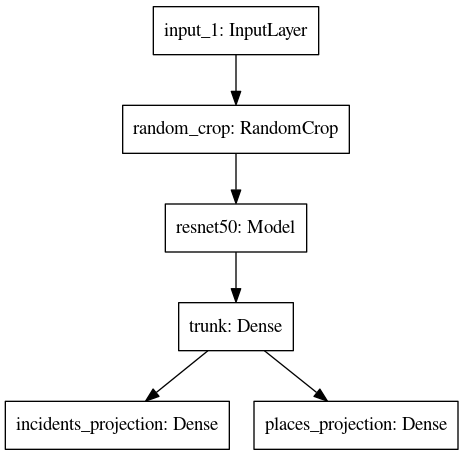

In [21]:
keras.utils.plot_model(mdl)

In [39]:
mdl.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
random_crop_1 (RandomCrop)      (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
resnet50 (Model)                (None, 2048)         23587712    random_crop_1[0][0]              
__________________________________________________________________________________________________
trunk (Dense)                   (None, 1024)         2098176     resnet50[1][0]                   
____________________________________________________________________________________________